## Assignment #3 :  Building a RNN (Recurrent Neural Network) with Keras

#### Course ID: COMPSCIX461-002 Artificial Intelligence Foundations
#### Student Name : Joe Fernandez
#### Submission Date : 09 Dec, 2024

### Building a RNN (Recurrent Neural Network) with Keras

A **Recurrent Neural Network** or **RNN** is a deep neural network trained on ***sequential*** or ***time series*** data to create a machine learning (ML) model that can make sequential predictions or conclusions based on sequential inputs

#### Objective:
The goal of this assignment is to gain hands-on experience in designing and implementing a recurrent neural network using the Keras library in Python. Select a dataset from kaggle and apply a deep learning model to it. The focus is on experimenting with different activation functions and optimization techniques to understand their impact on the model's performance.

Compare between RELU and TanH and also with Dropout and no-Dropout. Use more layers vs. less layers. Find the best results and compare against the others to see which would be the best.

##### **Model Design**
- Design a recurrent neural network using Keras.
- Network should have a minimum of 3 layers

##### **Activation Functions**
- Experiment with three different activation functions: Sigmoid, Tanh, and ReLU.
- Implement these activation functions in different models (or layers) to observe their effects on the network's performance.

##### **Optimization Technique**
- Use either Gradient Descent or Stochastic Gradient Descent (SGD) as optimization technique.
- Discuss how the chosen optimizer influences the training process and outcomes.

##### **Model Evaluation**
- Evaluate the performance of the models using appropriate metrics (such as accuracy.).
- Compare the results obtained with different activation functions and discuss the findings.

**Submission**:
- Submit your Jupyter Notebook containing the code, along with the report. Submit a ipynb or html file.

In [1]:
# Load the Kaggle API Key 
#!mkdir -p ~/.kaggle                 # per Kaggle, create the .kaggle folder
#!cp kaggle/kaggle.json ~/.kaggle/   # per Kaggle, copy the kaggle.json file into the folder
#!chmod 600 ~/.kaggle/kaggle.json    # per Kaggle, ensure the chmod is 600 for the kaggle.json file

In [2]:
# Download the dataset from Kaggle using the API Key
# Ensure kaggle package is loaded into Jupyter Notebook before you use the below command

#!kaggle datasets download -d ananthr1/weather-prediction

In [3]:
# Unzip the file into fashion_mnist folder. Use -o to overwrite the files if one exists already

#!unzip -o weather-prediction.zip -d weather-prediction/

In [4]:
# Import the basic python packages for the assignment

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [5]:
# Import Tensorflow and Scikit Learn packages needed for the assignment

#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
#from tensorflow.keras.optimizers.legacy import Adam #Since I have M2 mac os, I need to use legacy for Adam optimizer

from scikeras.wrappers import KerasClassifier
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, LSTM, GRU, SimpleRNN
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam, SGD 
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError

from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error

In [6]:
# Load the weather prediction data into a dataframe

df = pd.read_csv('weather-prediction/seattle-weather.csv')

In [7]:
# Look at the first 10 rows of the dataframe

df.head(10)

date  precipitation  temp_max  temp_min  wind  weather
0  2012-01-01            0.0      12.8       5.0   4.7  drizzle
1  2012-01-02           10.9      10.6       2.8   4.5     rain
2  2012-01-03            0.8      11.7       7.2   2.3     rain
3  2012-01-04           20.3      12.2       5.6   4.7     rain
4  2012-01-05            1.3       8.9       2.8   6.1     rain
5  2012-01-06            2.5       4.4       2.2   2.2     rain
6  2012-01-07            0.0       7.2       2.8   2.3     rain
7  2012-01-08            0.0      10.0       2.8   2.0      sun
8  2012-01-09            4.3       9.4       5.0   3.4     rain
9  2012-01-10            1.0       6.1       0.6   3.4     rain

In [8]:
# Summarize the information in the dataframe using df.info()

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           1461 non-null   object 
 1   precipitation  1461 non-null   float64
 2   temp_max       1461 non-null   float64
 3   temp_min       1461 non-null   float64
 4   wind           1461 non-null   float64
 5   weather        1461 non-null   object 
dtypes: float64(4), object(2)
memory usage: 68.6+ KB


In [9]:
# Info already shows that there are no null values
# Check for count of null values using isnull statement

df.isnull().sum()

date             0
precipitation    0
temp_max         0
temp_min         0
wind             0
weather          0
dtype: int64

In [10]:
# Check for duplciates in the dataset

print (f'Total number of duplicate rows are : {df.duplicated().sum()}')

Total number of duplicate rows are : 0


In [11]:
# For Chi Square test, import chi2_contingency
#from scipy.stats import chi2_contingency

In [12]:
#for column in df.columns[1:-1]:  # Exclude the target variable 'weather'
#    contingency_table = pd.crosstab(df['weather'], df[column])
#    chi2, p, _, _ = chi2_contingency(contingency_table)
#    print(f"Chi-square test for independence between {column} and Weather:\n")
#    print(f"Chi2 value: {chi2:,.2f}, p-value: {p:0.18f}")
#    if p < 0.05: 
#        print(f"The variable {column} is likely not independent of Weather.")
#    else:
#        print(f"The variable {column} is likely independent of Weather.")
#    print()

In [13]:
# We are not going to use Chi Square Test to look at dependency between each of the column against Weather. 
# If we were to do so, we can use the above Chi Square Test

#### Use `temp_max` column for RNN implementation
Use numpy sliding window view to create Training and Test Datasets

Per IBM's Recurrent Neural Network article, (Link: https://www.ibm.com/topics/recurrent-neural-networks)

It statate that ....

While traditional deep learning networks assume that inputs and outputs are independent of each other, the output of recurrent neural networks depend on the prior elements within the sequence. While future events would also be helpful in determining the output of a given sequence, unidirectional recurrent neural networks cannot account for these events in their predictions.

This indicates that we should select one of the 4 columns and use that for RNN
precipitation, temp_max, temp_min, wind

We will use `temp_max` column for RNN and we will use the prior elements within the sequence of data as training and future ones as test

In [14]:
# We will use 'temp_max' column as our primary driver to predict the temparature of the next few days
# Create a sliding window view of 'temp_max' column for consecutive 15 days and have the 16th day as test data

# For that, we need to import sliding_window_view from Numpy 

from numpy.lib.stride_tricks import sliding_window_view

# Create the XY values for sliding 16 days. Use the first 15 for training and 16th for test
XY_values = sliding_window_view(df.temp_max, 16)

In [15]:
# Let's review the first set of values. This should show the temp_max values for the first 16 days.

XY_values[0]

array([12.8, 10.6, 11.7, 12.2,  8.9,  4.4,  7.2, 10. ,  9.4,  6.1,  6.1,
        6.1,  5. ,  4.4,  1.1,  1.7])

In [16]:
# Let's check this against the first 16 rows from 'temp_max' column
df.temp_max[:16].to_numpy()

array([12.8, 10.6, 11.7, 12.2,  8.9,  4.4,  7.2, 10. ,  9.4,  6.1,  6.1,
        6.1,  5. ,  4.4,  1.1,  1.7])

In [17]:
# Check if both of the values are same. Let's use the first 16 rows

if XY_values[0].sum() == df.temp_max[:16].to_numpy().sum():
    print ('Matched: The sliding window view method matches with the next 16 rows of data (test = first 16 rows)') 
else: 
    print ('Error: The sliding window view method is NOT the correct way to get next 16 rows of data')

# If both are same, result will be 'Matches' else it will say 'Error'

Matched: The sliding window view method matches with the next 16 rows of data (test = first 16 rows)


In [18]:
# Check if both of the values are same. Let's use the last 16 rows

if XY_values[-1].sum() == df.temp_max[-16:].to_numpy().sum():
    print ('Matched: The sliding window view method matches with the next 16 rows of data (test = last 16 rows)') 
else: 
    print ('Error: The sliding window view method is NOT the correct way to get next 16 rows of data')

# If both are same, result will be 'Matches' else it will say 'Error'

Matched: The sliding window view method matches with the next 16 rows of data (test = last 16 rows)


In [19]:
# Let's look at total number of rows available for Training, Test, and Validation split

XY_values.shape

(1446, 16)

#### Train - Test - Val split approach 
Now that we have the sequence of data from the `temp_max` column, we will create the Training and Test datasets

There are 1446 rows to consider for Training, Test, and Validation.

We will use 1000 records for Training, 200 records for Validation, and 246 for Test

In [20]:
# First 1000 rows will be considered as training dataset

train_count = 1000
val_count = train_count + 200

X_train = XY_values[:train_count,:15]
y_train = XY_values[:train_count,-1]

# Next 200 rows will be considered as validation dataset

X_val = XY_values[train_count:val_count,:15]
y_val = XY_values[train_count:val_count,-1]

# The last 246 rows will be considered as Test dataset

X_test = XY_values[val_count:,:15]
y_test = XY_values[val_count:,-1]

X_train.shape, X_val.shape, X_test.shape

((1000, 15), (200, 15), (246, 15))

In [21]:
# Splitting the data shows that y_train has the next day's temperature. That indicates we can use this to train the model to learn y_train

X_train[0], y_train[0], X_train[1]

(array([12.8, 10.6, 11.7, 12.2,  8.9,  4.4,  7.2, 10. ,  9.4,  6.1,  6.1,
         6.1,  5. ,  4.4,  1.1]),
 1.7,
 array([10.6, 11.7, 12.2,  8.9,  4.4,  7.2, 10. ,  9.4,  6.1,  6.1,  6.1,
         5. ,  4.4,  1.1,  1.7]))

In [22]:
# Similarly, Splitting the data shows that y_val has the next day's temperature. 
# This indicates we can use y_val to validate if our model is effective before we test on target dataset

X_val[0], y_val[0], X_val[1]

(array([20.6, 18.9, 16.7, 19.4, 18.3, 19.4, 22.2, 21.7, 23.9, 25.6, 18.9,
        20.6, 17.2, 18.3, 18.3]),
 17.8,
 array([18.9, 16.7, 19.4, 18.3, 19.4, 22.2, 21.7, 23.9, 25.6, 18.9, 20.6,
        17.2, 18.3, 18.3, 17.8]))

In [23]:
# Splitting the data shows that y_test has the next day's temperature. That indicates we are predicting for y_test

X_test[0], y_test[0], X_test[1]

(array([13.9, 17.8, 18.9, 18.9, 21.1, 22.8, 17.2, 15.6, 12.2, 12.2, 13.3,
        15.6, 25. , 15.6, 16.1]),
 17.2,
 array([17.8, 18.9, 18.9, 21.1, 22.8, 17.2, 15.6, 12.2, 12.2, 13.3, 15.6,
        25. , 15.6, 16.1, 17.2]))

In [24]:
# Review the shape of X_train
X_train[0].shape

(15,)

In [25]:
# Reshape this into a tensor for RNN model training

X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
X_test  = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
X_val   = np.reshape(X_val,(X_val.shape[0],X_val.shape[1],1))

In [26]:
X_train[0].shape

(15, 1)

### Model Design

#### Simple RNN

We will use Simple RNN first to see how the model behaves. We will run the Simple RNN using the three activation functions - sigmoid, ReLU, and TanH

#### **1. Simple RNN with Optimize: Adam Optimizer, Activation Function : Sigmoid**

In [27]:
# Evaluate with Adam Optimizer, Activation Sigmoid, With Dropouts

SimpleRNN_model_with_adam_optimizer_sigmoid = Sequential()

SimpleRNN_model_with_adam_optimizer_sigmoid.add(SimpleRNN(units=100, return_sequences = True, input_shape=(X_train.shape[1], 1)))
SimpleRNN_model_with_adam_optimizer_sigmoid.add(Dropout(0.2))

SimpleRNN_model_with_adam_optimizer_sigmoid.add(SimpleRNN(units=100, return_sequences = False))
SimpleRNN_model_with_adam_optimizer_sigmoid.add(Dropout(0.2))

#Output layer
SimpleRNN_model_with_adam_optimizer_sigmoid.add(Dense(units=1, activation='sigmoid'))

In [28]:
# Let's review the summary of the model - Loss function is mean squared error, Adam learning rate is 0.001
# Since we are predicting a regression value, we will use mean squared error loss function and mean absolute error as metrics

SimpleRNN_model_with_adam_optimizer_sigmoid.summary()

#Compiling
SimpleRNN_model_with_adam_optimizer_sigmoid.compile(optimizer=Adam(learning_rate=0.001),
                                                loss='mean_squared_error', 
                                                metrics=['mean_absolute_error']
                                               )

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 15, 100)        │        10,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,401 (118.75 KB)

 Trainable params: 30,401 (118.75 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
#fitting the RNN to the training dataset with 50 epochs and batch size 64

SimpleRNN_scores_with_adam_optimizer_sigmoid=SimpleRNN_model_with_adam_optimizer_sigmoid.fit(X_train,
                                                                                     y_train,
                                                                                     validation_data=(X_val,y_val),
                                                                                     epochs=50, 
                                                                                     batch_size=64
                                                                                    )

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 308.0704 - mean_absolute_error: 15.9647 - val_loss: 150.9263 - val_mean_absolute_error: 11.6827
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 299.7684 - mean_absolute_error: 15.5577 - val_loss: 150.9236 - val_mean_absolute_error: 11.6826
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 292.6778 - mean_absolute_error: 15.4841 - val_loss: 150.9233 - val_mean_absolute_error: 11.6826
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 292.5158 - mean_absolute_error: 15.4470 - val_loss: 150.9232 - val_mean_absolute_error: 11.6826
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 288.7957 - mean_absolute_error: 15.4416 - val_loss: 150.9231 - val_mean_absolute_error: 11.6826
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 295.8076 - mean_absolute_error: 15.6334 - val_loss: 150.9230 - val_mean_absolute_error: 11.6826
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 297.0216 - mean_

In [30]:
SimpleRNN_sigmoid_loss = SimpleRNN_scores_with_adam_optimizer_sigmoid.history['loss']
SimpleRNN_sigmoid_val_loss = SimpleRNN_scores_with_adam_optimizer_sigmoid.history['val_loss']

SimpleRNN_sigmoid_maerror = SimpleRNN_scores_with_adam_optimizer_sigmoid.history['mean_absolute_error']
SimpleRNN_sigmoid_val_maerror = SimpleRNN_scores_with_adam_optimizer_sigmoid.history['val_mean_absolute_error']

SimpleRNN_scores_with_adam_optimizer_sigmoid.history.keys()

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])

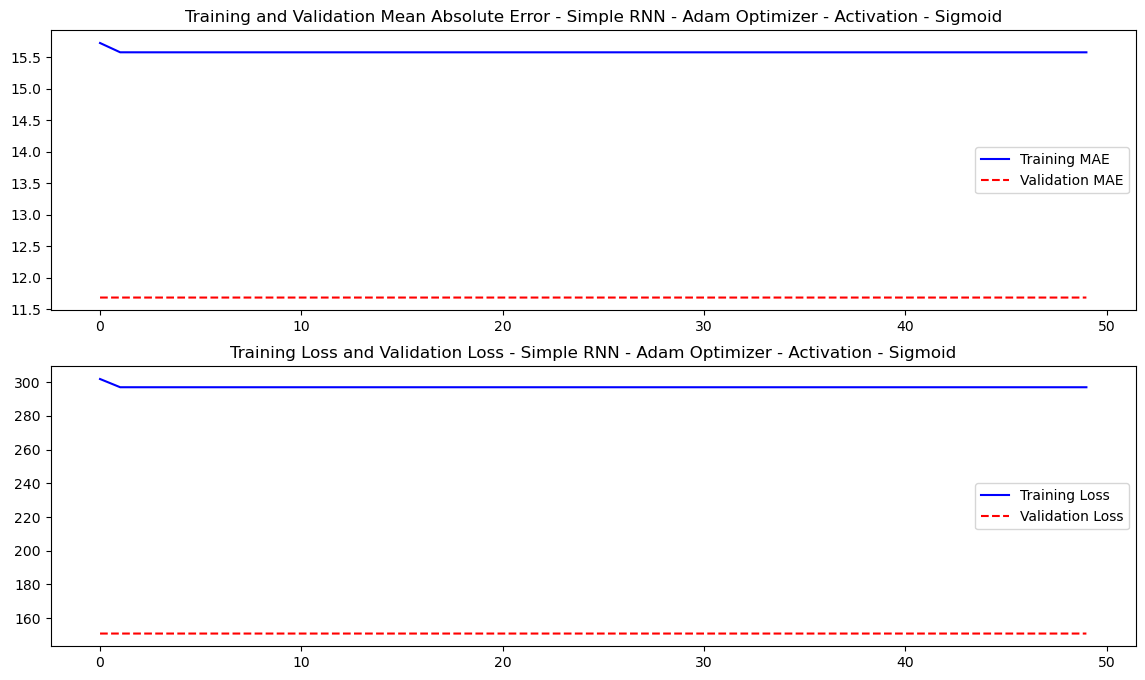

In [31]:
# Plot the Loss and MAE values for Training and Validation

fig,axes = plt.subplots(2,1,figsize=(14,8))
plt.subplot(2,1,1)
plt.plot(SimpleRNN_sigmoid_maerror, 'b', label='Training MAE')
plt.plot(SimpleRNN_sigmoid_val_maerror, 'r--', label='Validation MAE')
plt.title('Training and Validation Mean Absolute Error - Simple RNN - Adam Optimizer - Activation - Sigmoid')
plt.legend()
plt.subplot(2,1,2)
plt.plot(SimpleRNN_sigmoid_loss, 'b', label='Training Loss')
plt.plot(SimpleRNN_sigmoid_val_loss, 'r--', label='Validation Loss')
plt.title('Training Loss and Validation Loss - Simple RNN - Adam Optimizer - Activation - Sigmoid')
plt.legend()
plt.show()

In [32]:
# Calculate the RMSE for Simple RNN with Activation Function Sigmoid

# Root Mean Square Error (RMSE) measures the average magnitude of errors in a set of predictions, 
# where a lower value signifies better prediction accuracy. 

SimpleRNN_adam_sigmoid_predict = SimpleRNN_model_with_adam_optimizer_sigmoid.predict(X_test)

SimpleRNN_adam_sigmoid_rmse = np.sqrt(mean_squared_error(y_test, SimpleRNN_adam_sigmoid_predict))

print('Simple RNN - Adam - Sigmoid - Root Mean Squared Error : {:.4f}'.format(SimpleRNN_adam_sigmoid_rmse))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Simple RNN - Adam - Sigmoid - Root Mean Squared Error : 20.0809


#### **2. Simple RNN with Optimize: Adam Optimizer, Activation Function : ReLU**

In [33]:
# Evaluate with Adam Optimizer, Activation Sigmoid, With Dropouts

SimpleRNN_model_with_adam_optimizer_relu = Sequential()

SimpleRNN_model_with_adam_optimizer_relu.add(SimpleRNN(units=100, return_sequences = True, input_shape=(X_train.shape[1], 1)))
SimpleRNN_model_with_adam_optimizer_relu.add(Dropout(0.2))

SimpleRNN_model_with_adam_optimizer_relu.add(SimpleRNN(units=100, return_sequences = False))
SimpleRNN_model_with_adam_optimizer_relu.add(Dropout(0.2))

#Output layer
SimpleRNN_model_with_adam_optimizer_relu.add(Dense(units=1,activation='relu'))

In [34]:
# Let's review the summary of the model - Loss function is mean squared error, Adam learning rate is 0.001

SimpleRNN_model_with_adam_optimizer_relu.summary()

#Compiling
SimpleRNN_model_with_adam_optimizer_relu.compile(optimizer=Adam(learning_rate=0.001),
                                                loss='mean_squared_error', 
                                                metrics=['mean_absolute_error']
                                               )

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)        │ (None, 15, 100)        │        10,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 15, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,401 (118.75 KB)

 Trainable params: 30,401 (118.75 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
#fitting the RNN to the training dataset with 50 epochs and batch size 64

SimpleRNN_scores_with_adam_optimizer_relu=SimpleRNN_model_with_adam_optimizer_relu.fit(X_train,
                                                                                     y_train,
                                                                                     validation_data=(X_val,y_val),
                                                                                     epochs=50, 
                                                                                     batch_size=64
                                                                                    )

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 224.2580 - mean_absolute_error: 12.8988 - val_loss: 15.1023 - val_mean_absolute_error: 3.0367
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 67.7153 - mean_absolute_error: 6.5090 - val_loss: 10.4932 - val_mean_absolute_error: 2.4840
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 46.0502 - mean_absolute_error: 5.1700 - val_loss: 7.8008 - val_mean_absolute_error: 2.1346
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 38.4369 - mean_absolute_error: 4.6106 - val_loss: 6.4506 - val_mean_absolute_error: 1.9733
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 30.4984 - mean_absolute_error: 4.0495 - val_loss: 6.8411 - val_mean_absolute_error: 2.0717
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 25.8229 - mean_absolute_error: 3.6938 - val_loss: 6.2467 - val_mean_absolute_error: 2.0116
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 21.6009 - mean_absolute_error: 3.4647 - val

In [36]:
SimpleRNN_relu_loss = SimpleRNN_scores_with_adam_optimizer_relu.history['loss']
SimpleRNN_relu_val_loss = SimpleRNN_scores_with_adam_optimizer_relu.history['val_loss']

SimpleRNN_relu_maerror = SimpleRNN_scores_with_adam_optimizer_relu.history['mean_absolute_error']
SimpleRNN_relu_val_maerror = SimpleRNN_scores_with_adam_optimizer_relu.history['val_mean_absolute_error']

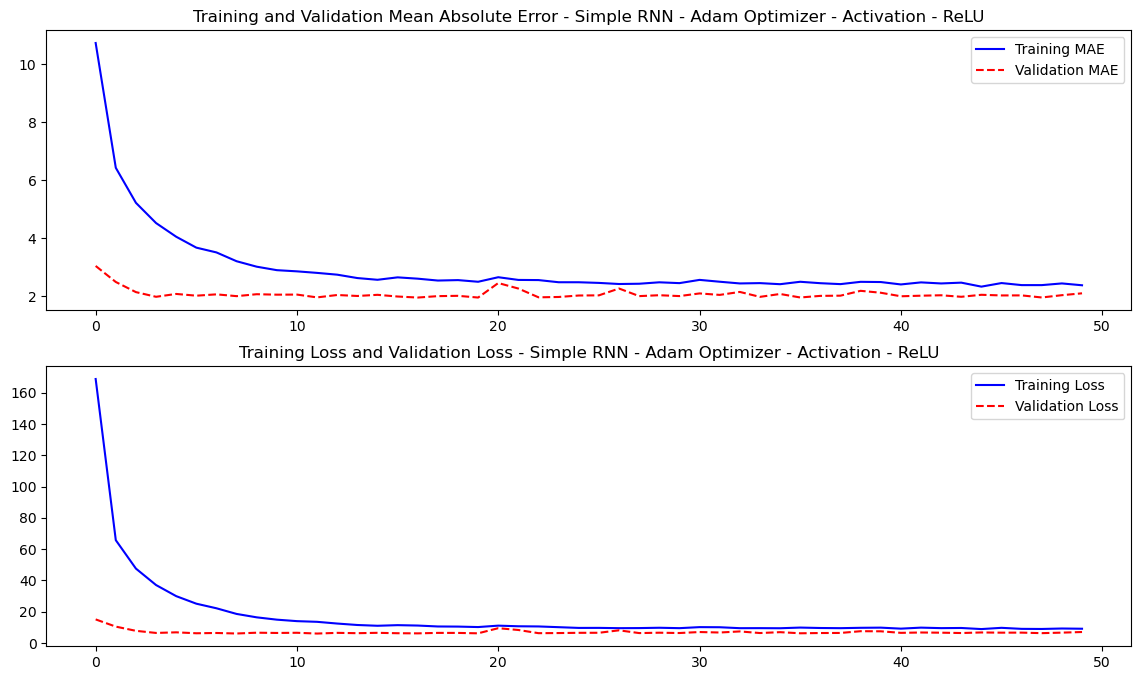

In [37]:
# Plot the Loss and MAE values for Training and Validation

fig,axes = plt.subplots(2,1,figsize=(14,8))
plt.subplot(2,1,1)
plt.plot(SimpleRNN_relu_maerror, 'b', label='Training MAE')
plt.plot(SimpleRNN_relu_val_maerror, 'r--', label='Validation MAE')
plt.title('Training and Validation Mean Absolute Error - Simple RNN - Adam Optimizer - Activation - ReLU')
plt.legend()
plt.subplot(2,1,2)
plt.plot(SimpleRNN_relu_loss, 'b', label='Training Loss')
plt.plot(SimpleRNN_relu_val_loss, 'r--', label='Validation Loss')
plt.title('Training Loss and Validation Loss - Simple RNN - Adam Optimizer - Activation - ReLU')
plt.legend()
plt.show()

In [38]:
# Calculate the RMSE for Simple RNN with Activation Function ReLU

# Root Mean Square Error (RMSE) measures the average magnitude of errors in a set of predictions, 
# where a lower value signifies better prediction accuracy. 

SimpleRNN_adam_relu_predict = SimpleRNN_model_with_adam_optimizer_relu.predict(X_test)

SimpleRNN_adam_relu_rmse = np.sqrt(mean_squared_error(y_test, SimpleRNN_adam_relu_predict))

print('Simple RNN - Adam - ReLU - Root Mean Squared Error : {:.4f}'.format(SimpleRNN_adam_relu_rmse))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Simple RNN - Adam - ReLU - Root Mean Squared Error : 3.1969


#### **3. Simple RNN with Optimize: Adam Optimizer, Activation Function : TanH**

In [39]:
# Evaluate with Adam Optimizer, Activation Sigmoid, With Dropouts

SimpleRNN_model_with_adam_optimizer_tanh = Sequential()

SimpleRNN_model_with_adam_optimizer_tanh.add(SimpleRNN(units=100, return_sequences = True, input_shape=(X_train.shape[1], 1)))
SimpleRNN_model_with_adam_optimizer_tanh.add(Dropout(0.2))

SimpleRNN_model_with_adam_optimizer_tanh.add(SimpleRNN(units=100, return_sequences = False))
SimpleRNN_model_with_adam_optimizer_tanh.add(Dropout(0.2))

#Output layer
SimpleRNN_model_with_adam_optimizer_tanh.add(Dense(units=1,activation='tanh'))

In [40]:
# Let's review the summary of the model - Loss function is mean squared error, Adam learning rate is 0.001

SimpleRNN_model_with_adam_optimizer_tanh.summary()

#Compiling
SimpleRNN_model_with_adam_optimizer_tanh.compile(optimizer=Adam(learning_rate=0.001),
                                                loss='mean_squared_error', 
                                                metrics=['mean_absolute_error']
                                               )

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_4 (SimpleRNN)        │ (None, 15, 100)        │        10,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 15, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_5 (SimpleRNN)        │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,401 (118.75 KB)

 Trainable params: 30,401 (118.75 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
#fitting the RNN to the training dataset with 50 epochs and batch size 64

SimpleRNN_scores_with_adam_optimizer_tanh=SimpleRNN_model_with_adam_optimizer_tanh.fit(X_train,
                                                                                     y_train,
                                                                                     validation_data=(X_val,y_val),
                                                                                     epochs=50, 
                                                                                     batch_size=64
                                                                                    )

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 306.3582 - mean_absolute_error: 15.8714 - val_loss: 150.9219 - val_mean_absolute_error: 11.6825
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 294.6611 - mean_absolute_error: 15.4895 - val_loss: 150.9219 - val_mean_absolute_error: 11.6825
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 302.7475 - mean_absolute_error: 15.7284 - val_loss: 150.9219 - val_mean_absolute_error: 11.6825
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 290.7502 - mean_absolute_error: 15.3418 - val_loss: 150.9219 - val_mean_absolute_error: 11.6825
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 308.9198 - mean_absolute_error: 15.9113 - val_loss: 150.9219 - val_mean_absolute_error: 11.6825
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 295.7256 - mean_absolute_error: 15.5309 - val_loss: 150.9219 - val_mean_absolute_error: 11.6825
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 298.7021 - mean_

In [42]:
SimpleRNN_tanh_loss = SimpleRNN_scores_with_adam_optimizer_tanh.history['loss']
SimpleRNN_tanh_val_loss = SimpleRNN_scores_with_adam_optimizer_tanh.history['val_loss']

SimpleRNN_tanh_maerror = SimpleRNN_scores_with_adam_optimizer_tanh.history['mean_absolute_error']
SimpleRNN_tanh_val_maerror = SimpleRNN_scores_with_adam_optimizer_tanh.history['val_mean_absolute_error']

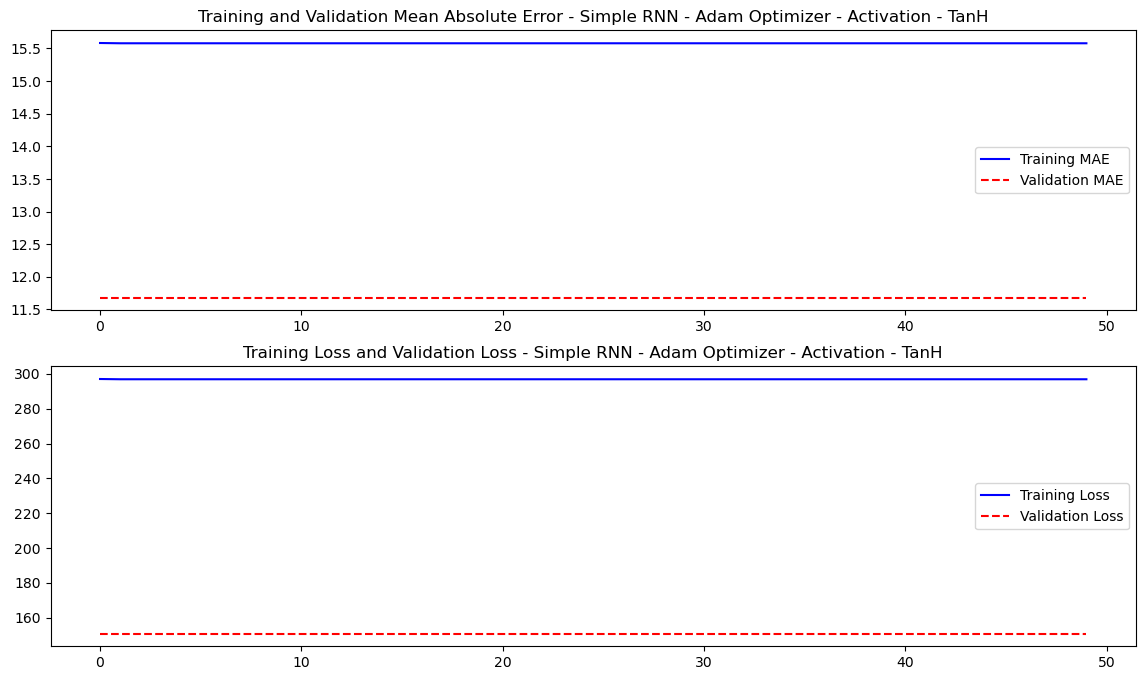

In [43]:
# Plot the Loss and MAE values for Training and Validation

fig,axes = plt.subplots(2,1,figsize=(14,8))
plt.subplot(2,1,1)
plt.plot(SimpleRNN_tanh_maerror, 'b', label='Training MAE')
plt.plot(SimpleRNN_tanh_val_maerror, 'r--', label='Validation MAE')
plt.title('Training and Validation Mean Absolute Error - Simple RNN - Adam Optimizer - Activation - TanH')
plt.legend()
plt.subplot(2,1,2)
plt.plot(SimpleRNN_tanh_loss, 'b', label='Training Loss')
plt.plot(SimpleRNN_tanh_val_loss, 'r--', label='Validation Loss')
plt.title('Training Loss and Validation Loss - Simple RNN - Adam Optimizer - Activation - TanH')
plt.legend()
plt.show()

In [44]:
# Calculate the RMSE for Simple RNN with Activation Function TanH

# Root Mean Square Error (RMSE) measures the average magnitude of errors in a set of predictions, 
# where a lower value signifies better prediction accuracy. 

SimpleRNN_adam_tanh_predict = SimpleRNN_model_with_adam_optimizer_tanh.predict(X_test)

SimpleRNN_adam_tanh_rmse = np.sqrt(mean_squared_error(y_test, SimpleRNN_adam_tanh_predict))

print('Simple RNN - Adam - TanH - Root Mean Squared Error : {:.4f}'.format(SimpleRNN_adam_tanh_rmse))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Simple RNN - Adam - TanH - Root Mean Squared Error : 20.0809


### Model Design

#### LSTM - Long Short Term Memory 

We will use LSTM - Long Short Term Memory to see how the model behaves. We will run the LSTM - Long Short Term Memory using the three activation functions - sigmoid, ReLU, and TanH

#### **1. LSTM - Long Short Term Memory with Optimize: Adam Optimizer, Activation Function : Sigmoid**

In [45]:
# Evaluate with Adam Optimizer, Activation Sigmoid, With Dropouts

LSTM_model_with_adam_optimizer_sigmoid = Sequential()

LSTM_model_with_adam_optimizer_sigmoid.add(LSTM(units=100, return_sequences = True, input_shape=(X_train.shape[1], 1)))
LSTM_model_with_adam_optimizer_sigmoid.add(Dropout(0.2))

LSTM_model_with_adam_optimizer_sigmoid.add(LSTM(units=100, return_sequences = False))
LSTM_model_with_adam_optimizer_sigmoid.add(Dropout(0.2))

#Output layer
LSTM_model_with_adam_optimizer_sigmoid.add(Dense(units=1, activation='sigmoid'))

In [46]:
# Let's review the summary of the model - Loss function is mean squared error, Adam learning rate is 0.001
# Since we are predicting a regression value, we will use mean squared error loss function and mean absolute error as metrics

LSTM_model_with_adam_optimizer_sigmoid.summary()

#Compiling
LSTM_model_with_adam_optimizer_sigmoid.compile(optimizer=Adam(learning_rate=0.001),
                                                loss='mean_squared_error', 
                                                metrics=['mean_absolute_error']
                                               )

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 15, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 15, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,301 (473.83 KB)

 Trainable params: 121,301 (473.83 KB)

 Non-trainable params: 0 (0.00 B)

In [47]:
#fitting the LSTM Model on the training dataset with 50 epochs and batch size 64

LSTM_scores_with_adam_optimizer_sigmoid=LSTM_model_with_adam_optimizer_sigmoid.fit(X_train,
                                                                                     y_train,
                                                                                     validation_data=(X_val,y_val),
                                                                                     epochs=50, 
                                                                                     batch_size=64
                                                                                    )

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 293.6092 - mean_absolute_error: 15.5138 - val_loss: 150.9375 - val_mean_absolute_error: 11.6832
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 297.0613 - mean_absolute_error: 15.5479 - val_loss: 150.9262 - val_mean_absolute_error: 11.6827
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 291.0010 - mean_absolute_error: 15.3617 - val_loss: 150.9247 - val_mean_absolute_error: 11.6826
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 290.8924 - mean_absolute_error: 15.4530 - val_loss: 150.9241 - val_mean_absolute_error: 11.6826
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 293.9582 - mean_absolute_error: 15.5432 - val_loss: 150.9238 - val_mean_absolute_error: 11.6826
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 294.4863 - mean_absolute_error: 15.5444 - val_loss: 150.9235 - val_mean_absolute_error: 11.6826
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 295.7039 - 

In [48]:
LSTM_sigmoid_loss = LSTM_scores_with_adam_optimizer_sigmoid.history['loss']
LSTM_sigmoid_val_loss = LSTM_scores_with_adam_optimizer_sigmoid.history['val_loss']

LSTM_sigmoid_maerror = LSTM_scores_with_adam_optimizer_sigmoid.history['mean_absolute_error']
LSTM_sigmoid_val_maerror = LSTM_scores_with_adam_optimizer_sigmoid.history['val_mean_absolute_error']

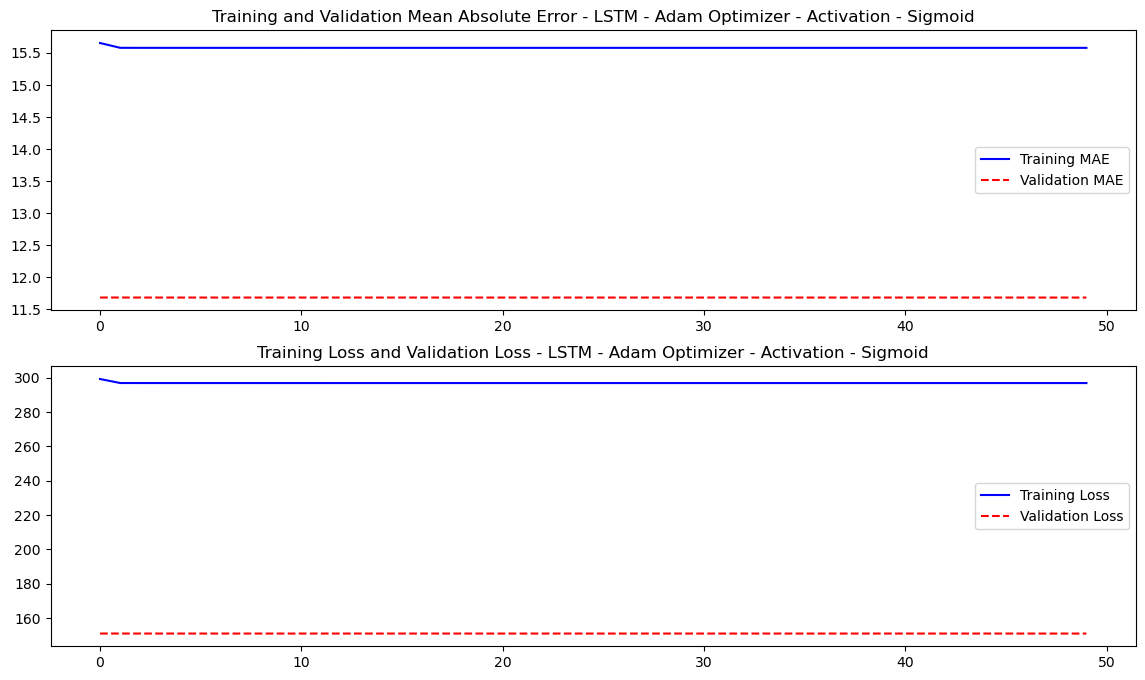

In [49]:
# Plot the Loss and MAE values for Training and Validation

fig,axes = plt.subplots(2,1,figsize=(14,8))
plt.subplot(2,1,1)
plt.plot(LSTM_sigmoid_maerror, 'b', label='Training MAE')
plt.plot(LSTM_sigmoid_val_maerror, 'r--', label='Validation MAE')
plt.title('Training and Validation Mean Absolute Error - LSTM - Adam Optimizer - Activation - Sigmoid')
plt.legend()
plt.subplot(2,1,2)
plt.plot(LSTM_sigmoid_loss, 'b', label='Training Loss')
plt.plot(LSTM_sigmoid_val_loss, 'r--', label='Validation Loss')
plt.title('Training Loss and Validation Loss - LSTM - Adam Optimizer - Activation - Sigmoid')
plt.legend()
plt.show()

In [50]:
# Calculate the RMSE for LSTM with Recurrant with Activation Function Sigmoid 

# Root Mean Square Error (RMSE) measures the average magnitude of errors in a set of predictions, 
# where a lower value signifies better prediction accuracy. 

LSTM_adam_sigmoid_predict = LSTM_model_with_adam_optimizer_sigmoid.predict(X_test)

LSTM_adam_sigmoid_rmse = np.sqrt(mean_squared_error(y_test, LSTM_adam_sigmoid_predict))

print('LSTM - Adam - Sigmoid - Root Mean Squared Error : {:.4f}'.format(LSTM_adam_sigmoid_rmse))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
LSTM - Adam - Sigmoid - Root Mean Squared Error : 20.0809


#### **2. LSTM - Long Short Term Memory with Optimize: Adam Optimizer, Activation Function : ReLU**

In [51]:
# Evaluate with Adam Optimizer, Activation Sigmoid, With Dropouts

LSTM_model_with_adam_optimizer_relu = Sequential()

LSTM_model_with_adam_optimizer_relu.add(LSTM(units=100, return_sequences = True, input_shape=(X_train.shape[1], 1)))
LSTM_model_with_adam_optimizer_relu.add(Dropout(0.2))

LSTM_model_with_adam_optimizer_relu.add(LSTM(units=100, return_sequences = False))
LSTM_model_with_adam_optimizer_relu.add(Dropout(0.2))

#Output layer
LSTM_model_with_adam_optimizer_relu.add(Dense(units=1,activation='relu'))

In [52]:
# Let's review the summary of the model - Loss function is mean squared error, Adam learning rate is 0.001

LSTM_model_with_adam_optimizer_relu.summary()

#Compiling
LSTM_model_with_adam_optimizer_relu.compile(optimizer=Adam(learning_rate=0.001),
                                                loss='mean_squared_error', 
                                                metrics=['mean_absolute_error']
                                               )

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 15, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 15, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,301 (473.83 KB)

 Trainable params: 121,301 (473.83 KB)

 Non-trainable params: 0 (0.00 B)

In [53]:
#fitting the LSTM Model on the training dataset with 50 epochs and batch size 64

LSTM_scores_with_adam_optimizer_relu=LSTM_model_with_adam_optimizer_relu.fit(X_train,
                                                                                     y_train,
                                                                                     validation_data=(X_val,y_val),
                                                                                     epochs=50, 
                                                                                     batch_size=64
                                                                                    )

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 267.2245 - mean_absolute_error: 14.4028 - val_loss: 25.0563 - val_mean_absolute_error: 4.1355
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 90.8954 - mean_absolute_error: 7.5384 - val_loss: 15.8303 - val_mean_absolute_error: 3.0804
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 62.8741 - mean_absolute_error: 6.4887 - val_loss: 21.5934 - val_mean_absolute_error: 3.7051
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 57.4440 - mean_absolute_error: 6.3615 - val_loss: 24.3436 - val_mean_absolute_error: 3.9894
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 52.0646 - mean_absolute_error: 6.0060 - val_loss: 17.0306 - val_mean_absolute_error: 3.2656
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 38.4565 - mean_absolute_error: 4.9004 - val_loss: 8.7054 - val_mean_absolute_error: 2.3268
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 26.5857 - mean_absolute_error: 3.8

In [54]:
LSTM_relu_loss = LSTM_scores_with_adam_optimizer_relu.history['loss']
LSTM_relu_val_loss = LSTM_scores_with_adam_optimizer_relu.history['val_loss']

LSTM_relu_maerror = LSTM_scores_with_adam_optimizer_relu.history['mean_absolute_error']
LSTM_relu_val_maerror = LSTM_scores_with_adam_optimizer_relu.history['val_mean_absolute_error']

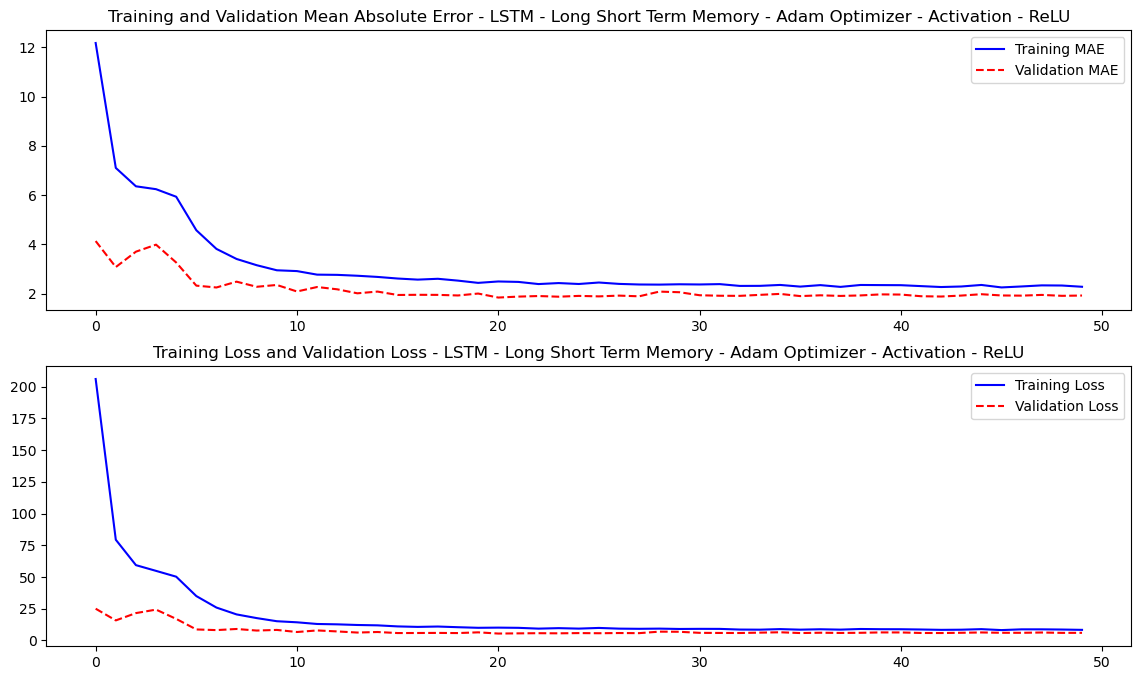

In [55]:
# Plot the Loss and MAE values for Training and Validation

fig,axes = plt.subplots(2,1,figsize=(14,8))
plt.subplot(2,1,1)
plt.plot(LSTM_relu_maerror, 'b', label='Training MAE')
plt.plot(LSTM_relu_val_maerror, 'r--', label='Validation MAE')
plt.title('Training and Validation Mean Absolute Error - LSTM - Long Short Term Memory - Adam Optimizer - Activation - ReLU')
plt.legend()
plt.subplot(2,1,2)
plt.plot(LSTM_relu_loss, 'b', label='Training Loss')
plt.plot(LSTM_relu_val_loss, 'r--', label='Validation Loss')
plt.title('Training Loss and Validation Loss - LSTM - Long Short Term Memory - Adam Optimizer - Activation - ReLU')
plt.legend()
plt.show()

In [56]:
# Calculate the RMSE for LSTM with Activation Function ReLU

# Root Mean Square Error (RMSE) measures the average magnitude of errors in a set of predictions, 
# where a lower value signifies better prediction accuracy. 

LSTM_adam_relu_predict = LSTM_model_with_adam_optimizer_relu.predict(X_test)

LSTM_adam_relu_rmse = np.sqrt(mean_squared_error(y_test, LSTM_adam_relu_predict))

print('LSTM - Adam - ReLU - Root Mean Squared Error : {:.4f}'.format(LSTM_adam_relu_rmse))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
LSTM - Adam - ReLU - Root Mean Squared Error : 2.9795


#### **3. LSTM - Long Short Term Memory with Optimize: Adam Optimizer, Activation Function : TanH**

In [57]:
# Evaluate with Adam Optimizer, Activation Sigmoid, With Dropouts

LSTM_model_with_adam_optimizer_tanh = Sequential()

LSTM_model_with_adam_optimizer_tanh.add(LSTM(units=100, return_sequences = True, input_shape=(X_train.shape[1], 1)))
LSTM_model_with_adam_optimizer_tanh.add(Dropout(0.2))

LSTM_model_with_adam_optimizer_tanh.add(LSTM(units=100, return_sequences = False))
LSTM_model_with_adam_optimizer_tanh.add(Dropout(0.2))

#Output layer
LSTM_model_with_adam_optimizer_tanh.add(Dense(units=1,activation='tanh'))

In [58]:
# Let's review the summary of the model - Loss function is mean squared error, Adam learning rate is 0.001

LSTM_model_with_adam_optimizer_tanh.summary()

#Compiling
LSTM_model_with_adam_optimizer_tanh.compile(optimizer=Adam(learning_rate=0.001),
                                                loss='mean_squared_error', 
                                                metrics=['mean_absolute_error']
                                               )

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 15, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 15, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,301 (473.83 KB)

 Trainable params: 121,301 (473.83 KB)

 Non-trainable params: 0 (0.00 B)

In [59]:
#fitting the LSTM Model on the training dataset with 50 epochs and batch size 64

LSTM_scores_with_adam_optimizer_tanh=LSTM_model_with_adam_optimizer_tanh.fit(X_train,
                                                                                     y_train,
                                                                                     validation_data=(X_val,y_val),
                                                                                     epochs=50, 
                                                                                     batch_size=64
                                                                                    )

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 303.1038 - mean_absolute_error: 15.7929 - val_loss: 150.9243 - val_mean_absolute_error: 11.6826
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 294.2651 - mean_absolute_error: 15.5037 - val_loss: 150.9227 - val_mean_absolute_error: 11.6825
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 291.8407 - mean_absolute_error: 15.3678 - val_loss: 150.9225 - val_mean_absolute_error: 11.6825
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 291.7082 - mean_absolute_error: 15.4543 - val_loss: 150.9224 - val_mean_absolute_error: 11.6825
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 307.0686 - mean_absolute_error: 15.8013 - val_loss: 150.9223 - val_mean_absolute_error: 11.6825
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 299.5263 - mean_absolute_error: 15.6576 - val_loss: 150.9223 - val_mean_absolute_error: 11.6825
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 296.8866 - 

In [60]:
LSTM_tanh_loss = LSTM_scores_with_adam_optimizer_tanh.history['loss']
LSTM_tanh_val_loss = LSTM_scores_with_adam_optimizer_tanh.history['val_loss']

LSTM_tanh_maerror = LSTM_scores_with_adam_optimizer_tanh.history['mean_absolute_error']
LSTM_tanh_val_maerror = LSTM_scores_with_adam_optimizer_tanh.history['val_mean_absolute_error']

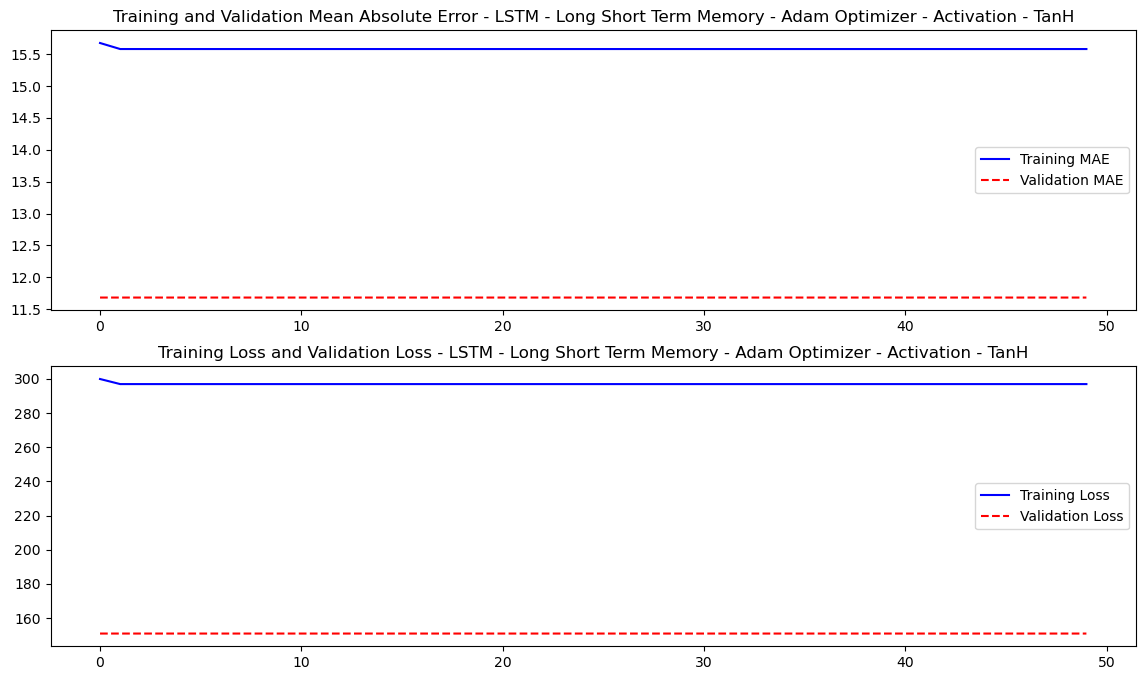

In [61]:
# Plot the Loss and MAE values for Training and Validation

fig,axes = plt.subplots(2,1,figsize=(14,8))
plt.subplot(2,1,1)
plt.plot(LSTM_tanh_maerror, 'b', label='Training MAE')
plt.plot(LSTM_tanh_val_maerror, 'r--', label='Validation MAE')
plt.title('Training and Validation Mean Absolute Error - LSTM - Long Short Term Memory - Adam Optimizer - Activation - TanH')
plt.legend()
plt.subplot(2,1,2)
plt.plot(LSTM_tanh_loss, 'b', label='Training Loss')
plt.plot(LSTM_tanh_val_loss, 'r--', label='Validation Loss')
plt.title('Training Loss and Validation Loss - LSTM - Long Short Term Memory - Adam Optimizer - Activation - TanH')
plt.legend()
plt.show()

In [62]:
# Calculate the RMSE for LSTM with Activation Function TanH 

# Root Mean Square Error (RMSE) measures the average magnitude of errors in a set of predictions, 
# where a lower value signifies better prediction accuracy. 

LSTM_adam_tanh_predict = LSTM_model_with_adam_optimizer_tanh.predict(X_test)

LSTM_adam_tanh_rmse = np.sqrt(mean_squared_error(y_test, LSTM_adam_tanh_predict))

print('LSTM - Adam - TanH - Root Mean Squared Error : {:.4f}'.format(LSTM_adam_tanh_rmse))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
LSTM - Adam - TanH - Root Mean Squared Error : 20.0809


### Model Design

#### LSTM - Long Short Term Memory with Recurrent Dropout

In an LSTM network, **"dropout"** refers to randomly dropping units (neurons) within a single layer at each training iteration, while **"recurrent dropout"** specifically drops units within the hidden state that is passed between time steps in the recurrent connection, essentially preventing overfitting by reducing the dependence on the previous hidden state across time

We will use LSTM - Long Short Term Memory to see how the model behaves. We will run the LSTM - Long Short Term Memory using the three activation functions - sigmoid, ReLU, and TanH

#### **1. LSTM - Long Short Term Memory with Optimize and Recurrent Dropout: Adam Optimizer, Activation Function : Sigmoid**

In [63]:
# Evaluate with Adam Optimizer, Activation Sigmoid, With Dropouts

LSTM_model_with_adam_optimizer_sigmoid_recurrent = Sequential()

LSTM_model_with_adam_optimizer_sigmoid_recurrent.add(LSTM(units=100, return_sequences = True, recurrent_dropout= 0.2, 
                                                input_shape=(X_train.shape[1], 1)))
LSTM_model_with_adam_optimizer_sigmoid_recurrent.add(Dropout(0.2))

LSTM_model_with_adam_optimizer_sigmoid_recurrent.add(LSTM(units=100, return_sequences = False, recurrent_dropout = 0.2))
LSTM_model_with_adam_optimizer_sigmoid_recurrent.add(Dropout(0.2))

#Output layer
LSTM_model_with_adam_optimizer_sigmoid_recurrent.add(Dense(units=1, activation='sigmoid'))

In [64]:
# Let's review the summary of the model - Loss function is mean squared error, Adam learning rate is 0.001
# Since we are predicting a regression value, we will use mean squared error loss function and mean absolute error as metrics

LSTM_model_with_adam_optimizer_sigmoid_recurrent.summary()

#Compiling
LSTM_model_with_adam_optimizer_sigmoid_recurrent.compile(optimizer=Adam(learning_rate=0.001),
                                                loss='mean_squared_error', 
                                                metrics=['mean_absolute_error']
                                               )

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 15, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 15, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,301 (473.83 KB)

 Trainable params: 121,301 (473.83 KB)

 Non-trainable params: 0 (0.00 B)

In [65]:
#fitting the LSTM Model on the training dataset with 50 epochs and batch size 64

LSTM_scores_with_adam_optimizer_sigmoid_recurrent=LSTM_model_with_adam_optimizer_sigmoid_recurrent.fit(X_train,
                                                                                     y_train,
                                                                                     validation_data=(X_val,y_val),
                                                                                     epochs=50, 
                                                                                     batch_size=64
                                                                                    )

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 298.8550 - mean_absolute_error: 15.6793 - val_loss: 150.9512 - val_mean_absolute_error: 11.6838
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 299.2003 - mean_absolute_error: 15.6627 - val_loss: 150.9293 - val_mean_absolute_error: 11.6828
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 299.3143 - mean_absolute_error: 15.7223 - val_loss: 150.9265 - val_mean_absolute_error: 11.6827
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 291.1961 - mean_absolute_error: 15.4499 - val_loss: 150.9254 - val_mean_absolute_error: 11.6827
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 297.8965 - mean_absolute_error: 15.5322 - val_loss: 150.9248 - val_mean_absolute_error: 11.6826
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 300.3448 - mean_absolute_error: 15.6017 - val_loss: 150.9243 - val_mean_absolute_error: 11.6826
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 296.6184 - 

In [66]:
LSTM_sigmoid_recurrent_loss = LSTM_scores_with_adam_optimizer_sigmoid_recurrent.history['loss']
LSTM_sigmoid_recurrent_val_loss = LSTM_scores_with_adam_optimizer_sigmoid_recurrent.history['val_loss']

LSTM_sigmoid_recurrent_maerror = LSTM_scores_with_adam_optimizer_sigmoid_recurrent.history['mean_absolute_error']
LSTM_sigmoid_recurrent_val_maerror = LSTM_scores_with_adam_optimizer_sigmoid_recurrent.history['val_mean_absolute_error']

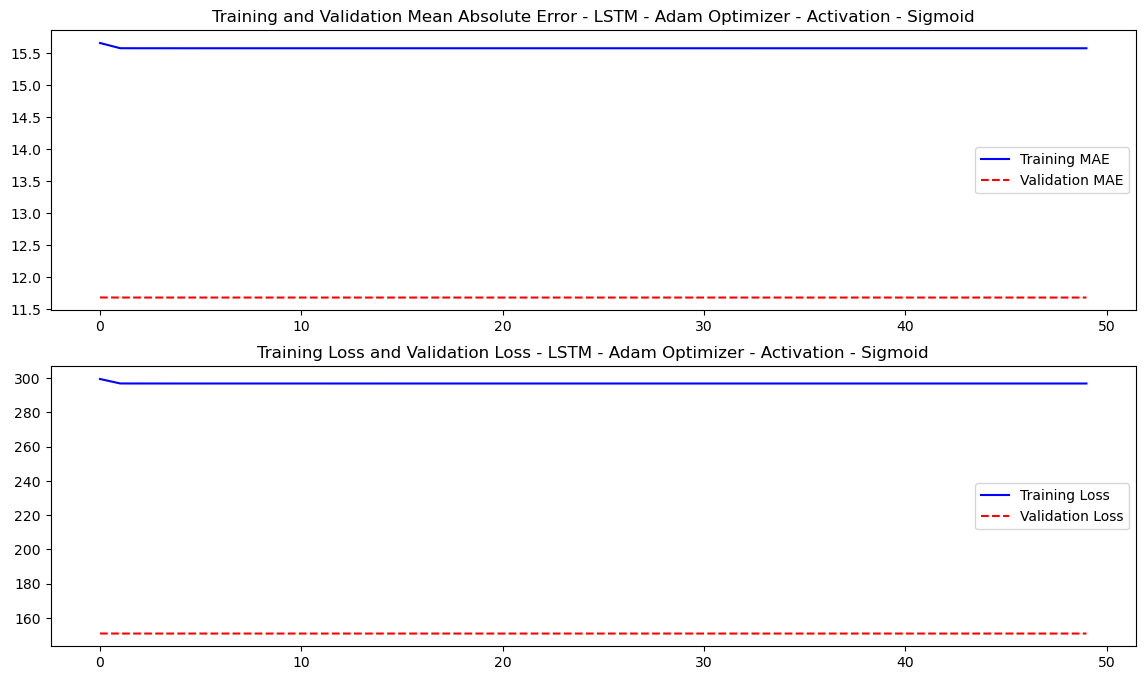

In [67]:
# Plot the Loss and MAE values for Training and Validation

fig,axes = plt.subplots(2,1,figsize=(14,8))
plt.subplot(2,1,1)
plt.plot(LSTM_sigmoid_recurrent_maerror, 'b', label='Training MAE')
plt.plot(LSTM_sigmoid_recurrent_val_maerror, 'r--', label='Validation MAE')
plt.title('Training and Validation Mean Absolute Error - LSTM - Adam Optimizer - Activation - Sigmoid')
plt.legend()
plt.subplot(2,1,2)
plt.plot(LSTM_sigmoid_recurrent_loss, 'b', label='Training Loss')
plt.plot(LSTM_sigmoid_recurrent_val_loss, 'r--', label='Validation Loss')
plt.title('Training Loss and Validation Loss - LSTM - Adam Optimizer - Activation - Sigmoid')
plt.legend()
plt.show()

In [68]:
# Calculate the RMSE for LSTM with Recurrant with Activation Function Sigmoid 

# Root Mean Square Error (RMSE) measures the average magnitude of errors in a set of predictions, 
# where a lower value signifies better prediction accuracy. 

LSTM_adam_sigmoid_recurrent_predict = LSTM_model_with_adam_optimizer_sigmoid_recurrent.predict(X_test)

LSTM_adam_sigmoid_recurrent_rmse = np.sqrt(mean_squared_error(y_test, LSTM_adam_sigmoid_recurrent_predict))

print('LSTM - Adam - Sigmoid - Recurrent - Root Mean Squared Error : {:.4f}'.format(LSTM_adam_sigmoid_recurrent_rmse))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
LSTM - Adam - Sigmoid - Recurrent - Root Mean Squared Error : 20.0809


#### **2. LSTM - Long Short Term Memory with Optimize and Recurrent Dropout: Adam Optimizer, Activation Function : ReLU**

In [69]:
# Evaluate with Adam Optimizer, Activation Sigmoid, With Dropouts and Recurrent Dropout in LSTM

LSTM_model_with_adam_optimizer_relu_recurrent = Sequential()

LSTM_model_with_adam_optimizer_relu_recurrent.add(LSTM(units=100, return_sequences = True, recurrent_dropout= 0.2,
                                             input_shape=(X_train.shape[1], 1)))
LSTM_model_with_adam_optimizer_relu_recurrent.add(Dropout(0.2))

LSTM_model_with_adam_optimizer_relu_recurrent.add(LSTM(units=100, return_sequences = False, recurrent_dropout= 0.2))
LSTM_model_with_adam_optimizer_relu_recurrent.add(Dropout(0.2))

#Output layer
LSTM_model_with_adam_optimizer_relu_recurrent.add(Dense(units=1,activation='relu'))

In [70]:
# Let's review the summary of the model - Loss function is mean squared error, Adam learning rate is 0.001

LSTM_model_with_adam_optimizer_relu_recurrent.summary()

#Compiling
LSTM_model_with_adam_optimizer_relu_recurrent.compile(optimizer=Adam(learning_rate=0.001),
                                                loss='mean_squared_error', 
                                                metrics=['mean_absolute_error']
                                               )

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 15, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 15, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,301 (473.83 KB)

 Trainable params: 121,301 (473.83 KB)

 Non-trainable params: 0 (0.00 B)

In [71]:
#fitting the LSTM Model on the training dataset with 50 epochs and batch size 64

LSTM_scores_with_adam_optimizer_relu_recurrent=LSTM_model_with_adam_optimizer_relu_recurrent.fit(X_train,
                                                                                     y_train,
                                                                                     validation_data=(X_val,y_val),
                                                                                     epochs=50, 
                                                                                     batch_size=64
                                                                                    )

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 282.8648 - mean_absolute_error: 14.9852 - val_loss: 30.5615 - val_mean_absolute_error: 4.6644
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 100.7487 - mean_absolute_error: 8.0115 - val_loss: 16.0021 - val_mean_absolute_error: 3.1006
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 56.4857 - mean_absolute_error: 6.1366 - val_loss: 22.7185 - val_mean_absolute_error: 3.8128
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 52.5406 - mean_absolute_error: 6.0597 - val_loss: 25.1418 - val_mean_absolute_error: 4.0730
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 50.6571 - mean_absolute_error: 5.9653 - val_loss: 11.2664 - val_mean_absolute_error: 2.5518
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 37.6185 - mean_absolute_error: 4.8084 - val_loss: 8.6769 - val_mean_absolute_error: 2.2743
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 30.3163 - mean_absolute_error: 4.

In [72]:
LSTM_relu_recurrent_loss = LSTM_scores_with_adam_optimizer_relu_recurrent.history['loss']
LSTM_relu_recurrent_val_loss = LSTM_scores_with_adam_optimizer_relu_recurrent.history['val_loss']

LSTM_relu_recurrent_maerror = LSTM_scores_with_adam_optimizer_relu_recurrent.history['mean_absolute_error']
LSTM_relu_recurrent_val_maerror = LSTM_scores_with_adam_optimizer_relu_recurrent.history['val_mean_absolute_error']

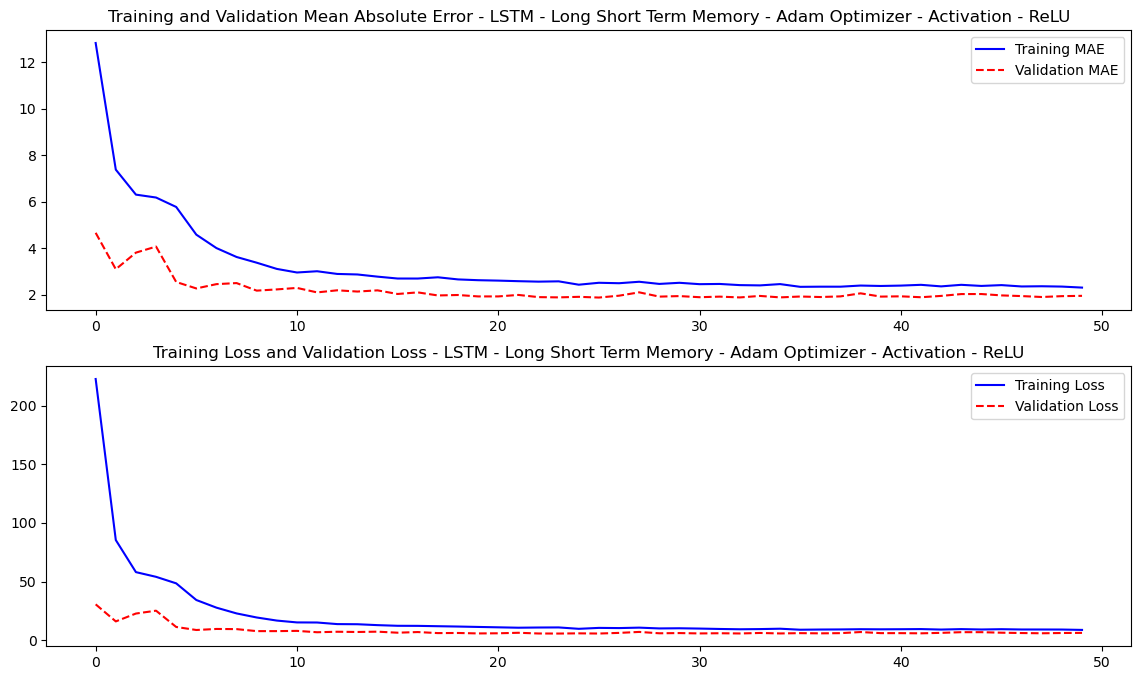

In [73]:
# Plot the Loss and MAE values for Training and Validation

fig,axes = plt.subplots(2,1,figsize=(14,8))
plt.subplot(2,1,1)
plt.plot(LSTM_relu_recurrent_maerror, 'b', label='Training MAE')
plt.plot(LSTM_relu_recurrent_val_maerror, 'r--', label='Validation MAE')
plt.title('Training and Validation Mean Absolute Error - LSTM - Long Short Term Memory - Adam Optimizer - Activation - ReLU')
plt.legend()
plt.subplot(2,1,2)
plt.plot(LSTM_relu_recurrent_loss, 'b', label='Training Loss')
plt.plot(LSTM_relu_recurrent_val_loss, 'r--', label='Validation Loss')
plt.title('Training Loss and Validation Loss - LSTM - Long Short Term Memory - Adam Optimizer - Activation - ReLU')
plt.legend()
plt.show()

In [74]:
# Calculate the RMSE for LSTM with Recurrant with Activation Function ReLU 

# Root Mean Square Error (RMSE) measures the average magnitude of errors in a set of predictions, 
# where a lower value signifies better prediction accuracy. 
LSTM_adam_relu_recurrent_predict = LSTM_model_with_adam_optimizer_relu_recurrent.predict(X_test)

LSTM_adam_relu_recurrent_rmse = np.sqrt(mean_squared_error(y_test, LSTM_adam_relu_recurrent_predict))

print('LSTM - Adam - ReLU - Recurrent - Root Mean Squared Error : {:.4f}'.format(LSTM_adam_relu_recurrent_rmse))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
LSTM - Adam - ReLU - Recurrent - Root Mean Squared Error : 3.1055


#### **3. LSTM - Long Short Term Memory with Optimize and Recurrent Dropout: Adam Optimizer, Activation Function : TanH**

In [75]:
# Evaluate with Adam Optimizer, Activation Sigmoid, With Dropouts

LSTM_model_with_adam_optimizer_tanh_recurrent = Sequential()

LSTM_model_with_adam_optimizer_tanh_recurrent.add(LSTM(units=100, return_sequences = True, recurrent_dropout= 0.2,
                                             input_shape=(X_train.shape[1], 1)))
LSTM_model_with_adam_optimizer_tanh_recurrent.add(Dropout(0.2))

LSTM_model_with_adam_optimizer_tanh_recurrent.add(LSTM(units=100, return_sequences = False, recurrent_dropout= 0.2))
LSTM_model_with_adam_optimizer_tanh_recurrent.add(Dropout(0.2))

#Output layer
LSTM_model_with_adam_optimizer_tanh_recurrent.add(Dense(units=1,activation='tanh'))

In [76]:
# Let's review the summary of the model - Loss function is mean squared error, Adam learning rate is 0.001

LSTM_model_with_adam_optimizer_tanh_recurrent.summary()

#Compiling
LSTM_model_with_adam_optimizer_tanh_recurrent.compile(optimizer=Adam(learning_rate=0.001),
                                                loss='mean_squared_error', 
                                                metrics=['mean_absolute_error']
                                               )

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 15, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 15, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,301 (473.83 KB)

 Trainable params: 121,301 (473.83 KB)

 Non-trainable params: 0 (0.00 B)

In [77]:
#fitting the LSTM Model on the training dataset with 50 epochs and batch size 64

LSTM_scores_with_adam_optimizer_tanh_recurrent=LSTM_model_with_adam_optimizer_tanh_recurrent.fit(X_train,
                                                                                     y_train,
                                                                                     validation_data=(X_val,y_val),
                                                                                     epochs=50, 
                                                                                     batch_size=64
                                                                                    )

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 306.5645 - mean_absolute_error: 15.9174 - val_loss: 150.9246 - val_mean_absolute_error: 11.6826
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 302.4234 - mean_absolute_error: 15.7630 - val_loss: 150.9227 - val_mean_absolute_error: 11.6825
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 302.3076 - mean_absolute_error: 15.7760 - val_loss: 150.9225 - val_mean_absolute_error: 11.6825
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 295.9552 - mean_absolute_error: 15.5744 - val_loss: 150.9224 - val_mean_absolute_error: 11.6825
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 298.8060 - mean_absolute_error: 15.6949 - val_loss: 150.9223 - val_mean_absolute_error: 11.6825
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 297.2701 - mean_absolute_error: 15.5106 - val_loss: 150.9223 - val_mean_absolute_error: 11.6825
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 297.8380 - 

In [78]:
LSTM_tanh_recurrent_loss = LSTM_scores_with_adam_optimizer_tanh_recurrent.history['loss']
LSTM_tanh_recurrent_val_loss = LSTM_scores_with_adam_optimizer_tanh_recurrent.history['val_loss']

LSTM_tanh_recurrent_maerror = LSTM_scores_with_adam_optimizer_tanh_recurrent.history['mean_absolute_error']
LSTM_tanh_recurrent_val_maerror = LSTM_scores_with_adam_optimizer_tanh_recurrent.history['val_mean_absolute_error']

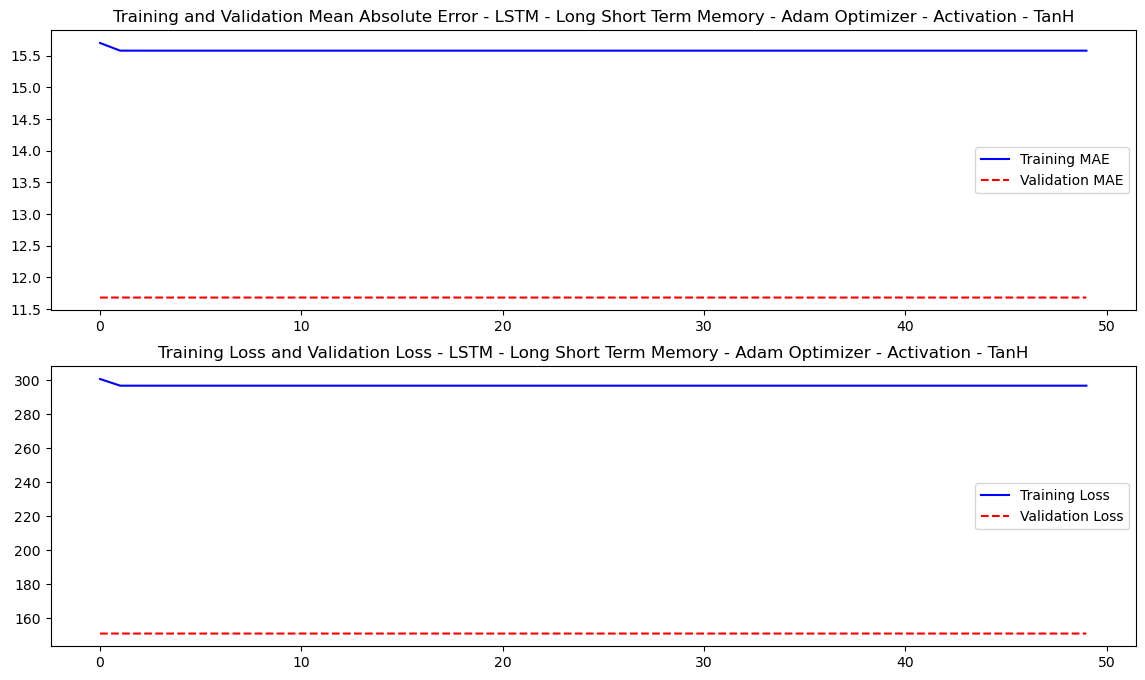

In [79]:
# Plot the Loss and MAE values for Training and Validation

fig,axes = plt.subplots(2,1,figsize=(14,8))
plt.subplot(2,1,1)
plt.plot(LSTM_tanh_recurrent_maerror, 'b', label='Training MAE')
plt.plot(LSTM_tanh_recurrent_val_maerror, 'r--', label='Validation MAE')
plt.title('Training and Validation Mean Absolute Error - LSTM - Long Short Term Memory - Adam Optimizer - Activation - TanH')
plt.legend()
plt.subplot(2,1,2)
plt.plot(LSTM_tanh_recurrent_loss, 'b', label='Training Loss')
plt.plot(LSTM_tanh_recurrent_val_loss, 'r--', label='Validation Loss')
plt.title('Training Loss and Validation Loss - LSTM - Long Short Term Memory - Adam Optimizer - Activation - TanH')
plt.legend()
plt.show()

In [80]:
# Calculate the RMSE for LSTM with Recurrant with Activation Function TanH 

# Root Mean Square Error (RMSE) measures the average magnitude of errors in a set of predictions, 
# where a lower value signifies better prediction accuracy. 

LSTM_adam_tanh_recurrent_predict = LSTM_model_with_adam_optimizer_tanh_recurrent.predict(X_test)

LSTM_adam_tanh_recurrent_rmse = np.sqrt(mean_squared_error(y_test, LSTM_adam_tanh_recurrent_predict))

print('LSTM - Adam - TanH - Recurrent - Root Mean Squared Error : {:.4f}'.format(LSTM_adam_tanh_recurrent_rmse))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
LSTM - Adam - TanH - Recurrent - Root Mean Squared Error : 20.0809


### Model Design

#### GRU - Gated Recurrent Unit

Introduced by Cho, et al. in 2014, **GRU (Gated Recurrent Unit)** aims to solve the vanishing gradient problem which comes with a standard recurrent neural network. GRU's are a variation on the LSTM.

We will use GRU - Gated Recurrent Unit to see how the model behaves. We will run the GRU - Gated Recurrent Unit using the three activation functions - sigmoid, ReLU, and TanH

#### **1. GRU - Gated Recurrent Unit with Optimize: Adam Optimizer, Activation Function : Sigmoid**

In [81]:
# Evaluate with Adam Optimizer, Activation Sigmoid, With Dropouts

GRU_model_with_adam_optimizer_sigmoid = Sequential()

GRU_model_with_adam_optimizer_sigmoid.add(GRU(units=300, return_sequences = True, input_shape=(X_train.shape[1], 1)))
GRU_model_with_adam_optimizer_sigmoid.add(Dropout(0.2))

GRU_model_with_adam_optimizer_sigmoid.add(GRU(units=300, return_sequences = False))
GRU_model_with_adam_optimizer_sigmoid.add(Dropout(0.2))

#Output layer
GRU_model_with_adam_optimizer_sigmoid.add(Dense(units=1, activation='sigmoid'))

In [82]:
# Let's review the summary of the model - Loss function is mean squared error, Adam learning rate is 0.001
# Since we are predicting a regression value, we will use mean squared error loss function and mean absolute error as metrics

GRU_model_with_adam_optimizer_sigmoid.summary()

#Compiling
GRU_model_with_adam_optimizer_sigmoid.compile(optimizer=Adam(learning_rate=0.001),
                                                loss='mean_squared_error', 
                                                metrics=['mean_absolute_error']
                                               )

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 15, 300)        │       272,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 15, 300)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 300)            │       541,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           301 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 814,801 (3.11 MB)

 Trainable params: 814,801 (3.11 MB)

 Non-trainable params: 0 (0.00 B)

In [83]:
#fitting the GRU Model on the training dataset with 50 epochs and batch size 64

GRU_scores_with_adam_optimizer_sigmoid = GRU_model_with_adam_optimizer_sigmoid.fit(X_train,
                                                                                     y_train,
                                                                                     validation_data=(X_val,y_val),
                                                                                     epochs=50, 
                                                                                     batch_size=64
                                                                                    )

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 292.0196 - mean_absolute_error: 15.4941 - val_loss: 150.9219 - val_mean_absolute_error: 11.6825
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 290.7119 - mean_absolute_error: 15.4959 - val_loss: 150.9219 - val_mean_absolute_error: 11.6825
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 286.9368 - mean_absolute_error: 15.2882 - val_loss: 150.9219 - val_mean_absolute_error: 11.6825
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 293.3035 - mean_absolute_error: 15.5224 - val_loss: 150.9219 - val_mean_absolute_error: 11.6825
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 297.9572 - mean_absolute_error: 15.6211 - val_loss: 150.9219 - val_mean_absolute_error: 11.6825
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 300.1425 - mean_absolute_error: 15.6815 - val_loss: 150.9219 - val_mean_absolute_error: 11.6825
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 293.9116 - 

In [84]:
GRU_sigmoid_loss = GRU_scores_with_adam_optimizer_sigmoid.history['loss']
GRU_sigmoid_val_loss = GRU_scores_with_adam_optimizer_sigmoid.history['val_loss']

GRU_sigmoid_maerror = GRU_scores_with_adam_optimizer_sigmoid.history['mean_absolute_error']
GRU_sigmoid_val_maerror = GRU_scores_with_adam_optimizer_sigmoid.history['val_mean_absolute_error']

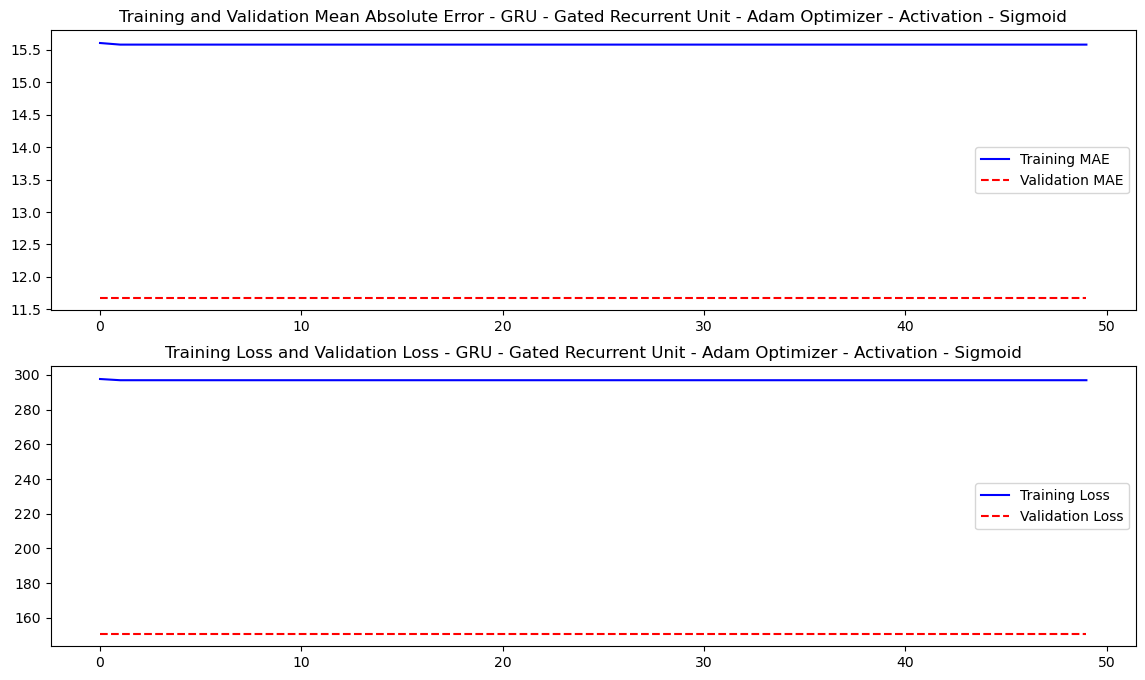

In [85]:
# Plot the Loss and MAE values for Training and Validation

fig,axes = plt.subplots(2,1,figsize=(14,8))
plt.subplot(2,1,1)
plt.plot(GRU_sigmoid_maerror, 'b', label='Training MAE')
plt.plot(GRU_sigmoid_val_maerror, 'r--', label='Validation MAE')
plt.title('Training and Validation Mean Absolute Error - GRU - Gated Recurrent Unit - Adam Optimizer - Activation - Sigmoid')
plt.legend()
plt.subplot(2,1,2)
plt.plot(GRU_sigmoid_loss, 'b', label='Training Loss')
plt.plot(GRU_sigmoid_val_loss, 'r--', label='Validation Loss')
plt.title('Training Loss and Validation Loss - GRU - Gated Recurrent Unit - Adam Optimizer - Activation - Sigmoid')
plt.legend()
plt.show()

In [86]:
# Calculate the RMSE for GRU with Activation Function Sigmoid 

# Root Mean Square Error (RMSE) measures the average magnitude of errors in a set of predictions, 
# where a lower value signifies better prediction accuracy. 

GRU_adam_sigmoid_predict = GRU_model_with_adam_optimizer_sigmoid.predict(X_test)

GRU_adam_sigmoid_rmse = np.sqrt(mean_squared_error(y_test, GRU_adam_sigmoid_predict))

print('GRU - Adam - Sigmoid - Root Mean Squared Error : {:.4f}'.format(GRU_adam_sigmoid_rmse))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
GRU - Adam - Sigmoid - Root Mean Squared Error : 20.0809


#### **2. GRU - Gated Recurrent Unit with Optimize: Adam Optimizer, Activation Function : ReLU**

In [87]:
# Evaluate with Adam Optimizer, Activation Sigmoid, With Dropouts and Recurrent Dropout in GRU

GRU_model_with_adam_optimizer_relu = Sequential()

GRU_model_with_adam_optimizer_relu.add(GRU(units=300, return_sequences = True, input_shape=(X_train.shape[1], 1)))
GRU_model_with_adam_optimizer_relu.add(Dropout(0.2))

GRU_model_with_adam_optimizer_relu.add(GRU(units=300, return_sequences = False))
GRU_model_with_adam_optimizer_relu.add(Dropout(0.2))

#Output layer
GRU_model_with_adam_optimizer_relu.add(Dense(units=1,activation='relu'))

In [88]:
# Let's review the summary of the model - Loss function is mean squared error, Adam learning rate is 0.001

GRU_model_with_adam_optimizer_relu.summary()

#Compiling
GRU_model_with_adam_optimizer_relu.compile(optimizer=Adam(learning_rate=0.001),
                                                loss='mean_squared_error', 
                                                metrics=['mean_absolute_error']
                                               )

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 15, 300)        │       272,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 15, 300)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 300)            │       541,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │           301 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 814,801 (3.11 MB)

 Trainable params: 814,801 (3.11 MB)

 Non-trainable params: 0 (0.00 B)

In [89]:
#fitting the GRU Model on the training dataset with 50 epochs and batch size 64

GRU_scores_with_adam_optimizer_relu = GRU_model_with_adam_optimizer_relu.fit(X_train,
                                                                                     y_train,
                                                                                     validation_data=(X_val,y_val),
                                                                                     epochs=50, 
                                                                                     batch_size=64
                                                                                    )

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 128.2293 - mean_absolute_error: 9.0432 - val_loss: 9.9761 - val_mean_absolute_error: 2.4596
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 30.0250 - mean_absolute_error: 4.2176 - val_loss: 8.4936 - val_mean_absolute_error: 2.3138
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 17.5649 - mean_absolute_error: 3.1746 - val_loss: 7.4646 - val_mean_absolute_error: 2.1897
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 11.4646 - mean_absolute_error: 2.6268 - val_loss: 6.0981 - val_mean_absolute_error: 1.9582
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 9.6201 - mean_absolute_error: 2.3944 - val_loss: 5.9854 - val_mean_absolute_error: 1.9398
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 8.5327 - mean_absolute_error: 2.2882 - val_loss: 7.7512 - val_mean_absolute_error: 2.2200
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 8.7560 - mean_absolute_error: 2.3293 - val

In [90]:
GRU_relu_loss = GRU_scores_with_adam_optimizer_relu.history['loss']
GRU_relu_val_loss = GRU_scores_with_adam_optimizer_relu.history['val_loss']

GRU_relu_maerror = GRU_scores_with_adam_optimizer_relu.history['mean_absolute_error']
GRU_relu_val_maerror = GRU_scores_with_adam_optimizer_relu.history['val_mean_absolute_error']

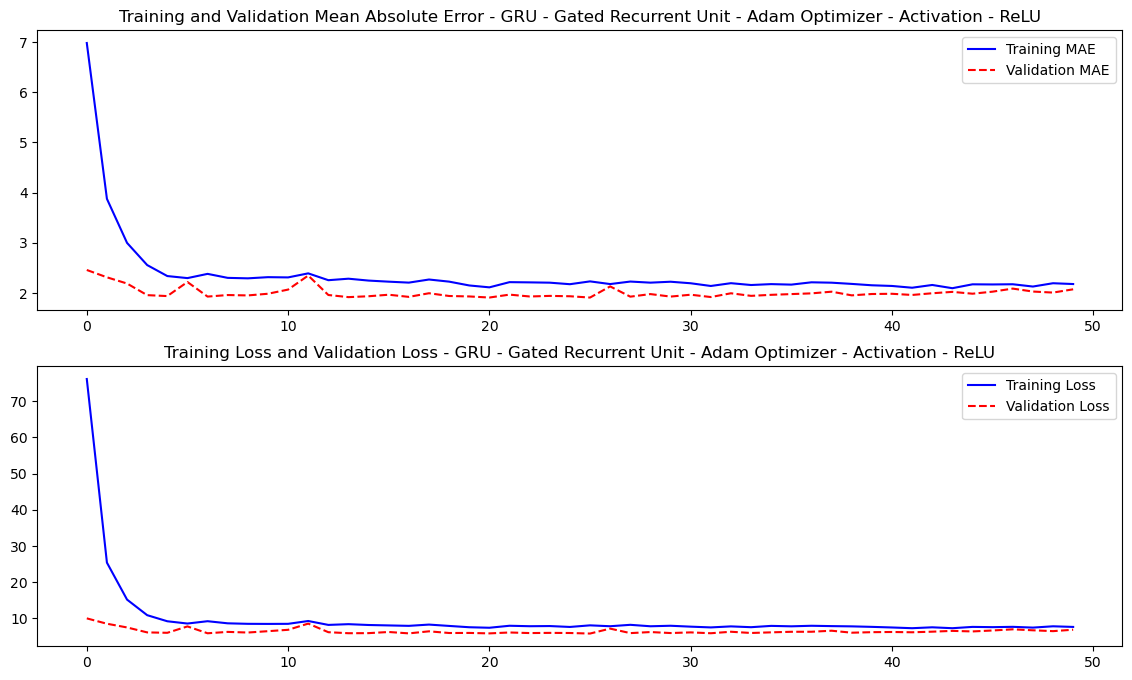

In [91]:
# Plot the Loss and MAE values for Training and Validation

fig,axes = plt.subplots(2,1,figsize=(14,8))
plt.subplot(2,1,1)
plt.plot(GRU_relu_maerror, 'b', label='Training MAE')
plt.plot(GRU_relu_val_maerror, 'r--', label='Validation MAE')
plt.title('Training and Validation Mean Absolute Error - GRU - Gated Recurrent Unit - Adam Optimizer - Activation - ReLU')
plt.legend()
plt.subplot(2,1,2)
plt.plot(GRU_relu_loss, 'b', label='Training Loss')
plt.plot(GRU_relu_val_loss, 'r--', label='Validation Loss')
plt.title('Training Loss and Validation Loss - GRU - Gated Recurrent Unit - Adam Optimizer - Activation - ReLU')
plt.legend()
plt.show()

In [92]:
# Calculate the RMSE for GRU with Activation Function ReLU 

# Root Mean Square Error (RMSE) measures the average magnitude of errors in a set of predictions, 
# where a lower value signifies better prediction accuracy. 

GRU_adam_relu_predict = GRU_model_with_adam_optimizer_relu.predict(X_test)

GRU_adam_relu_rmse = np.sqrt(mean_squared_error(y_test, GRU_adam_relu_predict))

print('GRU - Adam - ReLU - Root Mean Squared Error : {:.4f}'.format(GRU_adam_relu_rmse))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
GRU - Adam - ReLU - Root Mean Squared Error : 3.0510


#### **3. GRU - Gated Recurrent Unit with Optimize: Adam Optimizer, Activation Function : TanH**

In [93]:
# Evaluate with Adam Optimizer, Activation Sigmoid, With Dropouts

GRU_model_with_adam_optimizer_tanh = Sequential()

GRU_model_with_adam_optimizer_tanh.add(GRU(units=300, return_sequences = True, input_shape=(X_train.shape[1], 1)))
GRU_model_with_adam_optimizer_tanh.add(Dropout(0.2))

GRU_model_with_adam_optimizer_tanh.add(GRU(units=300, return_sequences = False))
GRU_model_with_adam_optimizer_tanh.add(Dropout(0.2))

#Output layer
GRU_model_with_adam_optimizer_tanh.add(Dense(units=1,activation='tanh'))

In [94]:
# Let's review the summary of the model - Loss function is mean squared error, Adam learning rate is 0.001

GRU_model_with_adam_optimizer_tanh.summary()

#Compiling
GRU_model_with_adam_optimizer_tanh.compile(optimizer=Adam(learning_rate=0.001),
                                                loss='mean_squared_error', 
                                                metrics=['mean_absolute_error']
                                               )

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_4 (GRU)                     │ (None, 15, 300)        │       272,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 15, 300)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 300)            │       541,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           301 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 814,801 (3.11 MB)

 Trainable params: 814,801 (3.11 MB)

 Non-trainable params: 0 (0.00 B)

In [95]:
#fitting the GRU Model on the training dataset with 50 epochs and batch size 64

GRU_scores_with_adam_optimizer_tanh = GRU_model_with_adam_optimizer_tanh.fit(X_train,
                                                                                     y_train,
                                                                                     validation_data=(X_val,y_val),
                                                                                     epochs=50, 
                                                                                     batch_size=64
                                                                                    )

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 305.1290 - mean_absolute_error: 15.8949 - val_loss: 150.9219 - val_mean_absolute_error: 11.6825
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 292.8138 - mean_absolute_error: 15.4896 - val_loss: 150.9219 - val_mean_absolute_error: 11.6825
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 293.6505 - mean_absolute_error: 15.4951 - val_loss: 150.9219 - val_mean_absolute_error: 11.6825
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 301.7462 - mean_absolute_error: 15.7204 - val_loss: 150.9219 - val_mean_absolute_error: 11.6825
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 297.5126 - mean_absolute_error: 15.5793 - val_loss: 150.9219 - val_mean_absolute_error: 11.6825
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 306.9050 - mean_absolute_error: 15.8288 - val_loss: 150.9219 - val_mean_absolute_error: 11.6825
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 293.0239 - 

In [96]:
GRU_tanh_loss = GRU_scores_with_adam_optimizer_tanh.history['loss']
GRU_tanh_val_loss = GRU_scores_with_adam_optimizer_tanh.history['val_loss']

GRU_tanh_maerror = GRU_scores_with_adam_optimizer_tanh.history['mean_absolute_error']
GRU_tanh_val_maerror = GRU_scores_with_adam_optimizer_tanh.history['val_mean_absolute_error']

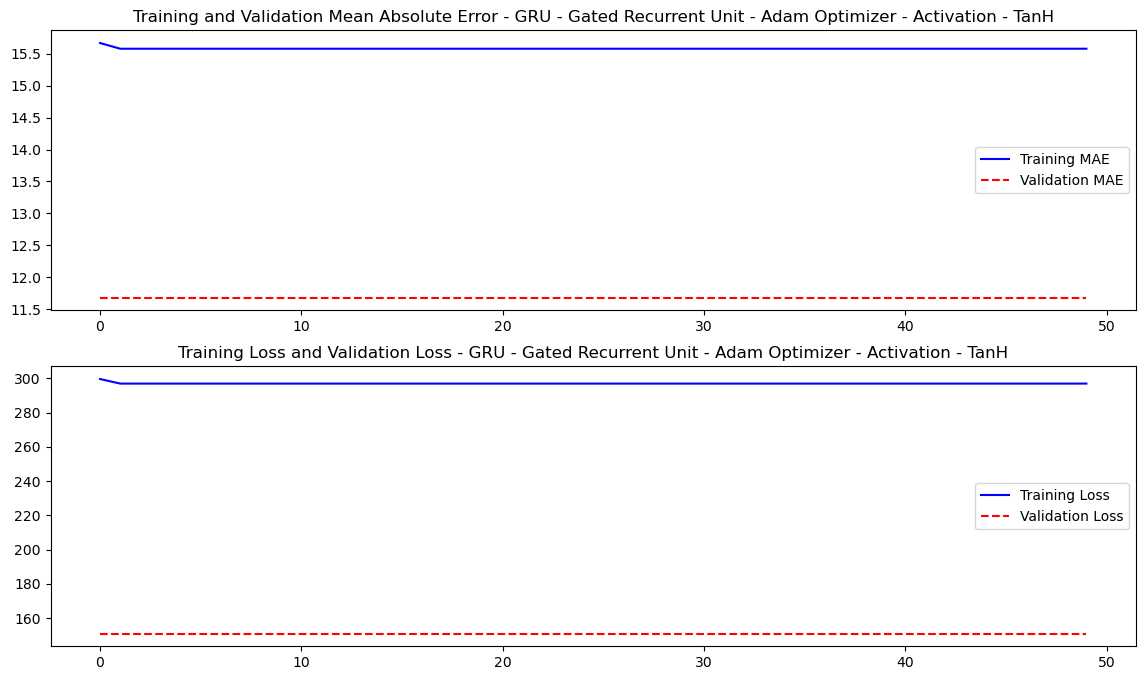

In [97]:
# Plot the Loss and MAE values for Training and Validation

fig,axes = plt.subplots(2,1,figsize=(14,8))
plt.subplot(2,1,1)
plt.plot(GRU_tanh_maerror, 'b', label='Training MAE')
plt.plot(GRU_tanh_val_maerror, 'r--', label='Validation MAE')
plt.title('Training and Validation Mean Absolute Error - GRU - Gated Recurrent Unit - Adam Optimizer - Activation - TanH')
plt.legend()
plt.subplot(2,1,2)
plt.plot(GRU_tanh_loss, 'b', label='Training Loss')
plt.plot(GRU_tanh_val_loss, 'r--', label='Validation Loss')
plt.title('Training Loss and Validation Loss - GRU - Gated Recurrent Unit - Adam Optimizer - Activation - TanH')
plt.legend()
plt.show()

In [98]:
# Calculate the RMSE for GRU with Activation Function TanH 

# Root Mean Square Error (RMSE) measures the average magnitude of errors in a set of predictions, 
# where a lower value signifies better prediction accuracy. 

GRU_adam_tanh_predict = GRU_model_with_adam_optimizer_tanh.predict(X_test)

GRU_adam_tanh_rmse = np.sqrt(mean_squared_error(y_test, GRU_adam_tanh_predict))

print('GRU - Adam - TanH - Root Mean Squared Error : {:.4f}'.format(GRU_adam_tanh_rmse))


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
GRU - Adam - TanH - Root Mean Squared Error : 20.0809


### SGD (Stochastic Gradient Descent) Optimizer

### Model Design

#### Simple RNN

We will use Simple RNN first to see how the model behaves. We will run the Simple RNN using the three activation functions - sigmoid, ReLU, and TanH

#### **1. Simple RNN with Optimize: SGD Optimizer, Activation Function : Sigmoid**

In [99]:
# Evaluate with SGD Optimizer, Activation Sigmoid, With Dropouts

SimpleRNN_model_with_SGD_optimizer_sigmoid = Sequential()

SimpleRNN_model_with_SGD_optimizer_sigmoid.add(SimpleRNN(units=100, return_sequences = True, input_shape=(X_train.shape[1], 1)))
SimpleRNN_model_with_SGD_optimizer_sigmoid.add(Dropout(0.2))

SimpleRNN_model_with_SGD_optimizer_sigmoid.add(SimpleRNN(units=100, return_sequences = False))
SimpleRNN_model_with_SGD_optimizer_sigmoid.add(Dropout(0.2))

#Output layer
SimpleRNN_model_with_SGD_optimizer_sigmoid.add(Dense(units=1, activation='sigmoid'))

In [100]:
# Let's review the summary of the model - Loss function is mean squared error, SGD learning rate is 0.001
# Since we are predicting a regression value, we will use mean squared error loss function and mean absolute error as metrics

SimpleRNN_model_with_SGD_optimizer_sigmoid.summary()

#Compiling
SimpleRNN_model_with_SGD_optimizer_sigmoid.compile(optimizer=SGD(learning_rate=0.001),
                                                loss='mean_squared_error', 
                                                metrics=['mean_absolute_error']
                                               )

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_6 (SimpleRNN)        │ (None, 15, 100)        │        10,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 15, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_7 (SimpleRNN)        │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,401 (118.75 KB)

 Trainable params: 30,401 (118.75 KB)

 Non-trainable params: 0 (0.00 B)

In [101]:
#fitting the RNN to the training dataset with 50 epochs and batch size 64

SimpleRNN_scores_with_SGD_optimizer_sigmoid=SimpleRNN_model_with_SGD_optimizer_sigmoid.fit(X_train,
                                                                                     y_train,
                                                                                     validation_data=(X_val,y_val),
                                                                                     epochs=50, 
                                                                                     batch_size=64
                                                                                    )

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 301.6397 - mean_absolute_error: 15.7481 - val_loss: 151.0769 - val_mean_absolute_error: 11.6894
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 287.1652 - mean_absolute_error: 15.2999 - val_loss: 151.0038 - val_mean_absolute_error: 11.6862
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 285.7804 - mean_absolute_error: 15.2751 - val_loss: 150.9765 - val_mean_absolute_error: 11.6850
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 297.4142 - mean_absolute_error: 15.5453 - val_loss: 150.9633 - val_mean_absolute_error: 11.6844
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 298.1115 - mean_absolute_error: 15.6459 - val_loss: 150.9554 - val_mean_absolute_error: 11.6840
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 301.2198 - mean_absolute_error: 15.7369 - val_loss: 150.9497 - val_mean_absolute_error: 11.6838
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 298.8680 - mean_a

In [102]:
SimpleRNN_sigmoid_loss = SimpleRNN_scores_with_SGD_optimizer_sigmoid.history['loss']
SimpleRNN_sigmoid_val_loss = SimpleRNN_scores_with_SGD_optimizer_sigmoid.history['val_loss']

SimpleRNN_sigmoid_maerror = SimpleRNN_scores_with_SGD_optimizer_sigmoid.history['mean_absolute_error']
SimpleRNN_sigmoid_val_maerror = SimpleRNN_scores_with_SGD_optimizer_sigmoid.history['val_mean_absolute_error']

SimpleRNN_scores_with_SGD_optimizer_sigmoid.history.keys()

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])

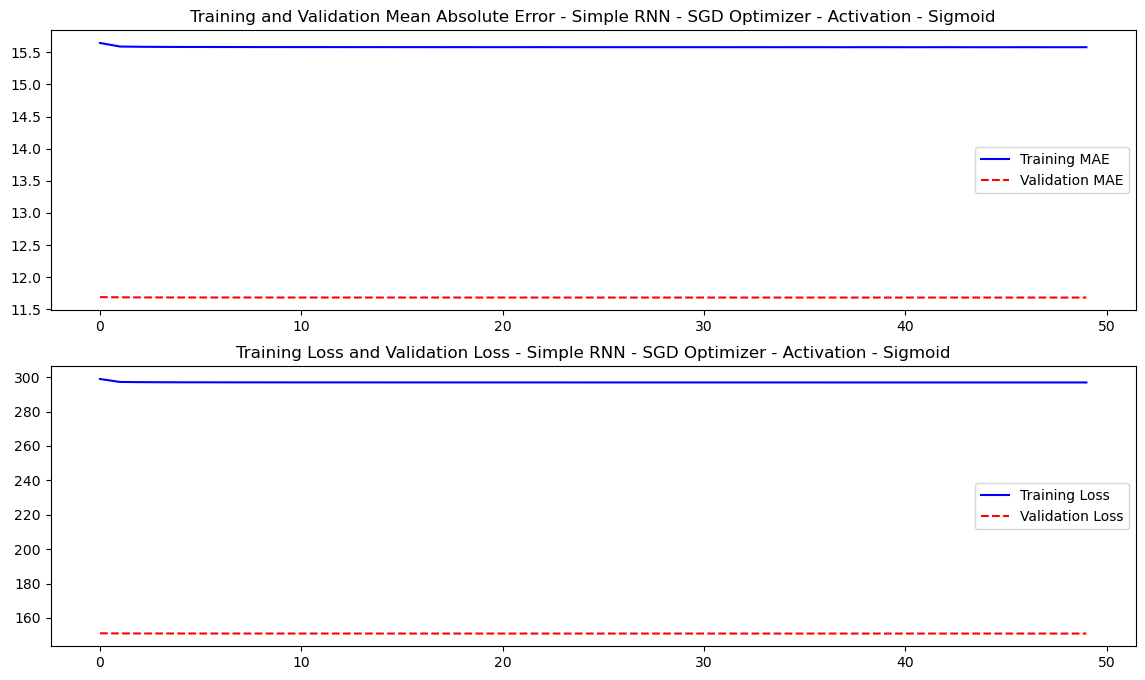

In [103]:
# Plot the Loss and MAE values for Training and Validation

fig,axes = plt.subplots(2,1,figsize=(14,8))
plt.subplot(2,1,1)
plt.plot(SimpleRNN_sigmoid_maerror, 'b', label='Training MAE')
plt.plot(SimpleRNN_sigmoid_val_maerror, 'r--', label='Validation MAE')
plt.title('Training and Validation Mean Absolute Error - Simple RNN - SGD Optimizer - Activation - Sigmoid')
plt.legend()
plt.subplot(2,1,2)
plt.plot(SimpleRNN_sigmoid_loss, 'b', label='Training Loss')
plt.plot(SimpleRNN_sigmoid_val_loss, 'r--', label='Validation Loss')
plt.title('Training Loss and Validation Loss - Simple RNN - SGD Optimizer - Activation - Sigmoid')
plt.legend()
plt.show()

In [104]:
# Calculate the RMSE for Simple RNN with Activation Function Sigmoid

# Root Mean Square Error (RMSE) measures the average magnitude of errors in a set of predictions, 
# where a lower value signifies better prediction accuracy. 

SimpleRNN_SGD_sigmoid_predict = SimpleRNN_model_with_SGD_optimizer_sigmoid.predict(X_test)

SimpleRNN_SGD_sigmoid_rmse = np.sqrt(mean_squared_error(y_test, SimpleRNN_SGD_sigmoid_predict))

print('Simple RNN - SGD - Sigmoid - Root Mean Squared Error : {:.4f}'.format(SimpleRNN_SGD_sigmoid_rmse))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Simple RNN - SGD - Sigmoid - Root Mean Squared Error : 20.0810


#### **2. Simple RNN with Optimize: SGD Optimizer, Activation Function : ReLU**

In [105]:
# Evaluate with SGD Optimizer, Activation Sigmoid, With Dropouts

SimpleRNN_model_with_SGD_optimizer_relu = Sequential()

SimpleRNN_model_with_SGD_optimizer_relu.add(SimpleRNN(units=100, return_sequences = True, input_shape=(X_train.shape[1], 1)))
SimpleRNN_model_with_SGD_optimizer_relu.add(Dropout(0.2))

SimpleRNN_model_with_SGD_optimizer_relu.add(SimpleRNN(units=100, return_sequences = False))
SimpleRNN_model_with_SGD_optimizer_relu.add(Dropout(0.2))

#Output layer
SimpleRNN_model_with_SGD_optimizer_relu.add(Dense(units=1,activation='relu'))

In [106]:
# Let's review the summary of the model - Loss function is mean squared error, SGD learning rate is 0.001

SimpleRNN_model_with_SGD_optimizer_relu.summary()

#Compiling
SimpleRNN_model_with_SGD_optimizer_relu.compile(optimizer=SGD(learning_rate=0.001),
                                                loss='mean_squared_error', 
                                                metrics=['mean_absolute_error']
                                               )

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_8 (SimpleRNN)        │ (None, 15, 100)        │        10,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 15, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_9 (SimpleRNN)        │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,401 (118.75 KB)

 Trainable params: 30,401 (118.75 KB)

 Non-trainable params: 0 (0.00 B)

In [107]:
#fitting the RNN to the training dataset with 50 epochs and batch size 64

SimpleRNN_scores_with_SGD_optimizer_relu=SimpleRNN_model_with_SGD_optimizer_relu.fit(X_train,
                                                                                     y_train,
                                                                                     validation_data=(X_val,y_val),
                                                                                     epochs=50, 
                                                                                     batch_size=64
                                                                                    )

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 181.4646 - mean_absolute_error: 10.9624 - val_loss: 9.2676 - val_mean_absolute_error: 2.3379
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 32.8964 - mean_absolute_error: 4.5137 - val_loss: 40.7662 - val_mean_absolute_error: 5.8584
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 23.0230 - mean_absolute_error: 3.7613 - val_loss: 23.2750 - val_mean_absolute_error: 4.0293
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 20.3415 - mean_absolute_error: 3.5391 - val_loss: 7.4511 - val_mean_absolute_error: 2.1488
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 16.7748 - mean_absolute_error: 3.2368 - val_loss: 8.0936 - val_mean_absolute_error: 2.1973
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 12.0576 - mean_absolute_error: 2.7552 - val_loss: 7.7691 - val_mean_absolute_error: 2.1850
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 13.0220 - mean_absolute_error: 2.8648 - val

In [108]:
SimpleRNN_relu_loss = SimpleRNN_scores_with_SGD_optimizer_relu.history['loss']
SimpleRNN_relu_val_loss = SimpleRNN_scores_with_SGD_optimizer_relu.history['val_loss']

SimpleRNN_relu_maerror = SimpleRNN_scores_with_SGD_optimizer_relu.history['mean_absolute_error']
SimpleRNN_relu_val_maerror = SimpleRNN_scores_with_SGD_optimizer_relu.history['val_mean_absolute_error']

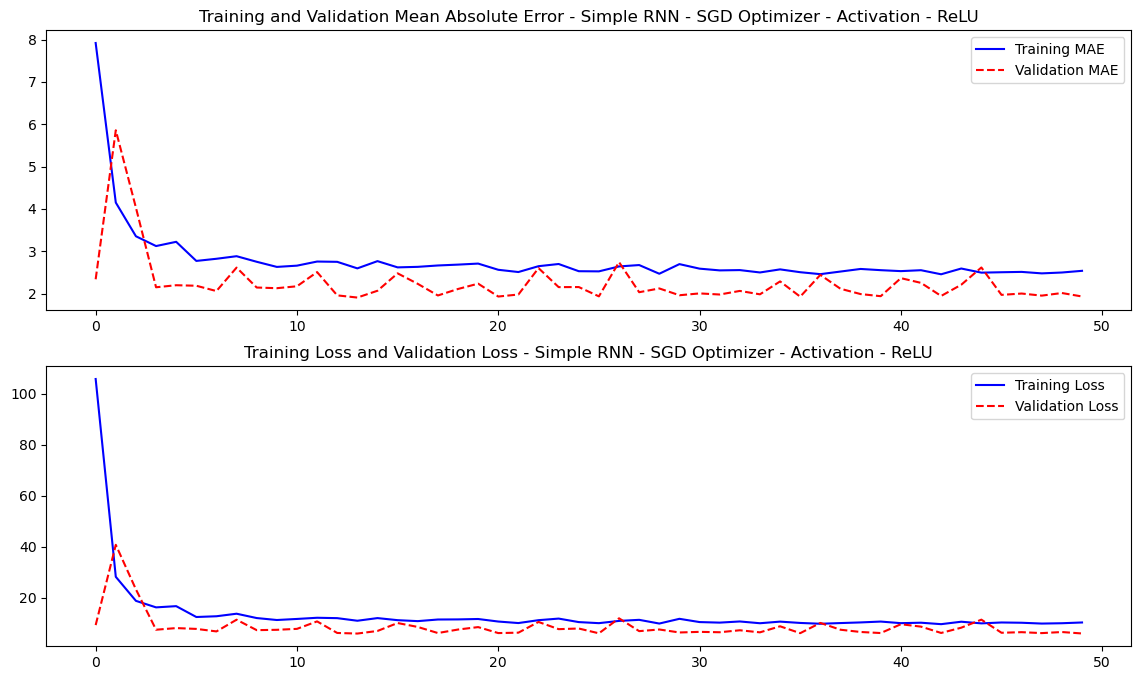

In [109]:
# Plot the Loss and MAE values for Training and Validation

fig,axes = plt.subplots(2,1,figsize=(14,8))
plt.subplot(2,1,1)
plt.plot(SimpleRNN_relu_maerror, 'b', label='Training MAE')
plt.plot(SimpleRNN_relu_val_maerror, 'r--', label='Validation MAE')
plt.title('Training and Validation Mean Absolute Error - Simple RNN - SGD Optimizer - Activation - ReLU')
plt.legend()
plt.subplot(2,1,2)
plt.plot(SimpleRNN_relu_loss, 'b', label='Training Loss')
plt.plot(SimpleRNN_relu_val_loss, 'r--', label='Validation Loss')
plt.title('Training Loss and Validation Loss - Simple RNN - SGD Optimizer - Activation - ReLU')
plt.legend()
plt.show()

In [110]:
# Calculate the RMSE for Simple RNN with Activation Function ReLU

# Root Mean Square Error (RMSE) measures the average magnitude of errors in a set of predictions, 
# where a lower value signifies better prediction accuracy. 

SimpleRNN_SGD_relu_predict = SimpleRNN_model_with_SGD_optimizer_relu.predict(X_test)

SimpleRNN_SGD_relu_rmse = np.sqrt(mean_squared_error(y_test, SimpleRNN_SGD_relu_predict))

print('Simple RNN - SGD - ReLU - Root Mean Squared Error : {:.4f}'.format(SimpleRNN_SGD_relu_rmse))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Simple RNN - SGD - ReLU - Root Mean Squared Error : 3.2937


#### **3. Simple RNN with Optimize: SGD Optimizer, Activation Function : TanH**

In [111]:
# Evaluate with SGD Optimizer, Activation Sigmoid, With Dropouts

SimpleRNN_model_with_SGD_optimizer_tanh = Sequential()

SimpleRNN_model_with_SGD_optimizer_tanh.add(SimpleRNN(units=100, return_sequences = True, input_shape=(X_train.shape[1], 1)))
SimpleRNN_model_with_SGD_optimizer_tanh.add(Dropout(0.2))

SimpleRNN_model_with_SGD_optimizer_tanh.add(SimpleRNN(units=100, return_sequences = False))
SimpleRNN_model_with_SGD_optimizer_tanh.add(Dropout(0.2))

#Output layer
SimpleRNN_model_with_SGD_optimizer_tanh.add(Dense(units=1,activation='tanh'))

In [112]:
# Let's review the summary of the model - Loss function is mean squared error, SGD learning rate is 0.001

SimpleRNN_model_with_SGD_optimizer_tanh.summary()

#Compiling
SimpleRNN_model_with_SGD_optimizer_tanh.compile(optimizer=SGD(learning_rate=0.001),
                                                loss='mean_squared_error', 
                                                metrics=['mean_absolute_error']
                                               )

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_10 (SimpleRNN)       │ (None, 15, 100)        │        10,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 15, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_11 (SimpleRNN)       │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,401 (118.75 KB)

 Trainable params: 30,401 (118.75 KB)

 Non-trainable params: 0 (0.00 B)

In [113]:
#fitting the RNN to the training dataset with 50 epochs and batch size 64

SimpleRNN_scores_with_SGD_optimizer_tanh=SimpleRNN_model_with_SGD_optimizer_tanh.fit(X_train,
                                                                                     y_train,
                                                                                     validation_data=(X_val,y_val),
                                                                                     epochs=50, 
                                                                                     batch_size=64
                                                                                    )

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 311.1716 - mean_absolute_error: 16.0019 - val_loss: 150.9517 - val_mean_absolute_error: 11.6841
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 307.6094 - mean_absolute_error: 15.8383 - val_loss: 150.9351 - val_mean_absolute_error: 11.6832
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 306.4908 - mean_absolute_error: 15.8166 - val_loss: 150.9305 - val_mean_absolute_error: 11.6830
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 289.3392 - mean_absolute_error: 15.3209 - val_loss: 150.9284 - val_mean_absolute_error: 11.6829
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 284.2708 - mean_absolute_error: 15.1746 - val_loss: 150.9268 - val_mean_absolute_error: 11.6828
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 297.0485 - mean_absolute_error: 15.6026 - val_loss: 150.9260 - val_mean_absolute_error: 11.6827
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 295.6003 - mean_a

In [114]:
SimpleRNN_tanh_loss = SimpleRNN_scores_with_SGD_optimizer_tanh.history['loss']
SimpleRNN_tanh_val_loss = SimpleRNN_scores_with_SGD_optimizer_tanh.history['val_loss']

SimpleRNN_tanh_maerror = SimpleRNN_scores_with_SGD_optimizer_tanh.history['mean_absolute_error']
SimpleRNN_tanh_val_maerror = SimpleRNN_scores_with_SGD_optimizer_tanh.history['val_mean_absolute_error']

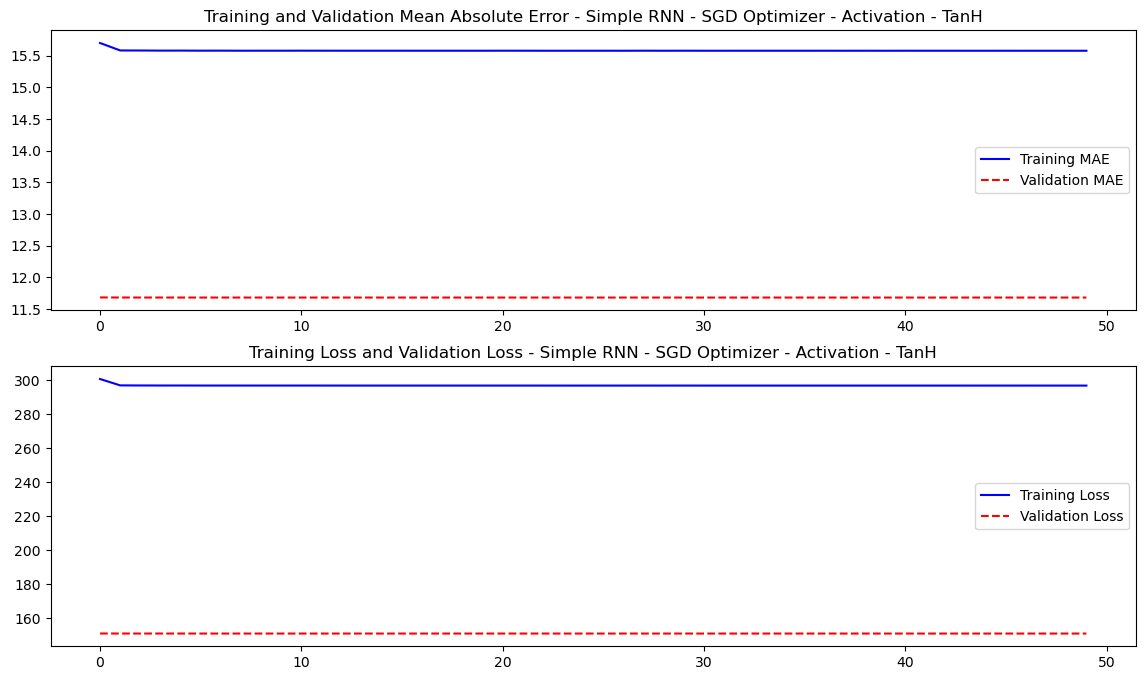

In [115]:
# Plot the Loss and MAE values for Training and Validation

fig,axes = plt.subplots(2,1,figsize=(14,8))
plt.subplot(2,1,1)
plt.plot(SimpleRNN_tanh_maerror, 'b', label='Training MAE')
plt.plot(SimpleRNN_tanh_val_maerror, 'r--', label='Validation MAE')
plt.title('Training and Validation Mean Absolute Error - Simple RNN - SGD Optimizer - Activation - TanH')
plt.legend()
plt.subplot(2,1,2)
plt.plot(SimpleRNN_tanh_loss, 'b', label='Training Loss')
plt.plot(SimpleRNN_tanh_val_loss, 'r--', label='Validation Loss')
plt.title('Training Loss and Validation Loss - Simple RNN - SGD Optimizer - Activation - TanH')
plt.legend()
plt.show()

In [116]:
# Calculate the RMSE for Simple RNN with Activation Function TanH

# Root Mean Square Error (RMSE) measures the average magnitude of errors in a set of predictions, 
# where a lower value signifies better prediction accuracy. 

SimpleRNN_SGD_tanh_predict = SimpleRNN_model_with_SGD_optimizer_tanh.predict(X_test)

SimpleRNN_SGD_tanh_rmse = np.sqrt(mean_squared_error(y_test, SimpleRNN_SGD_tanh_predict))

print('Simple RNN - SGD - TanH - Root Mean Squared Error : {:.4f}'.format(SimpleRNN_SGD_tanh_rmse))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Simple RNN - SGD - TanH - Root Mean Squared Error : 20.0809


### Model Design

#### LSTM - Long Short Term Memory 

We will use LSTM - Long Short Term Memory to see how the model behaves. We will run the LSTM - Long Short Term Memory using the three activation functions - sigmoid, ReLU, and TanH

#### **1. LSTM - Long Short Term Memory with Optimize: SGD Optimizer, Activation Function : Sigmoid**

In [117]:
# Evaluate with SGD Optimizer, Activation Sigmoid, With Dropouts

LSTM_model_with_SGD_optimizer_sigmoid = Sequential()

LSTM_model_with_SGD_optimizer_sigmoid.add(LSTM(units=100, return_sequences = True, input_shape=(X_train.shape[1], 1)))
LSTM_model_with_SGD_optimizer_sigmoid.add(Dropout(0.2))

LSTM_model_with_SGD_optimizer_sigmoid.add(LSTM(units=100, return_sequences = False))
LSTM_model_with_SGD_optimizer_sigmoid.add(Dropout(0.2))

#Output layer
LSTM_model_with_SGD_optimizer_sigmoid.add(Dense(units=1, activation='sigmoid'))

In [118]:
# Let's review the summary of the model - Loss function is mean squared error, SGD learning rate is 0.001
# Since we are predicting a regression value, we will use mean squared error loss function and mean absolute error as metrics

LSTM_model_with_SGD_optimizer_sigmoid.summary()

#Compiling
LSTM_model_with_SGD_optimizer_sigmoid.compile(optimizer=SGD(learning_rate=0.001),
                                                loss='mean_squared_error', 
                                                metrics=['mean_absolute_error']
                                               )

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 15, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 15, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,301 (473.83 KB)

 Trainable params: 121,301 (473.83 KB)

 Non-trainable params: 0 (0.00 B)

In [119]:
#fitting the LSTM Model on the training dataset with 50 epochs and batch size 64

LSTM_scores_with_SGD_optimizer_sigmoid=LSTM_model_with_SGD_optimizer_sigmoid.fit(X_train,
                                                                                     y_train,
                                                                                     validation_data=(X_val,y_val),
                                                                                     epochs=50, 
                                                                                     batch_size=64
                                                                                    )

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 314.4895 - mean_absolute_error: 16.0890 - val_loss: 152.5185 - val_mean_absolute_error: 11.7521
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 292.4569 - mean_absolute_error: 15.4419 - val_loss: 151.7547 - val_mean_absolute_error: 11.7190
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 308.3079 - mean_absolute_error: 15.8784 - val_loss: 151.4747 - val_mean_absolute_error: 11.7068
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 288.7523 - mean_absolute_error: 15.3593 - val_loss: 151.3323 - val_mean_absolute_error: 11.7006
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 298.3646 - mean_absolute_error: 15.5718 - val_loss: 151.2475 - val_mean_absolute_error: 11.6969
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 301.7750 - mean_absolute_error: 15.7329 - val_loss: 151.1895 - val_mean_absolute_error: 11.6943
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 296.6884 - 

In [120]:
LSTM_sigmoid_loss = LSTM_scores_with_SGD_optimizer_sigmoid.history['loss']
LSTM_sigmoid_val_loss = LSTM_scores_with_SGD_optimizer_sigmoid.history['val_loss']

LSTM_sigmoid_maerror = LSTM_scores_with_SGD_optimizer_sigmoid.history['mean_absolute_error']
LSTM_sigmoid_val_maerror = LSTM_scores_with_SGD_optimizer_sigmoid.history['val_mean_absolute_error']

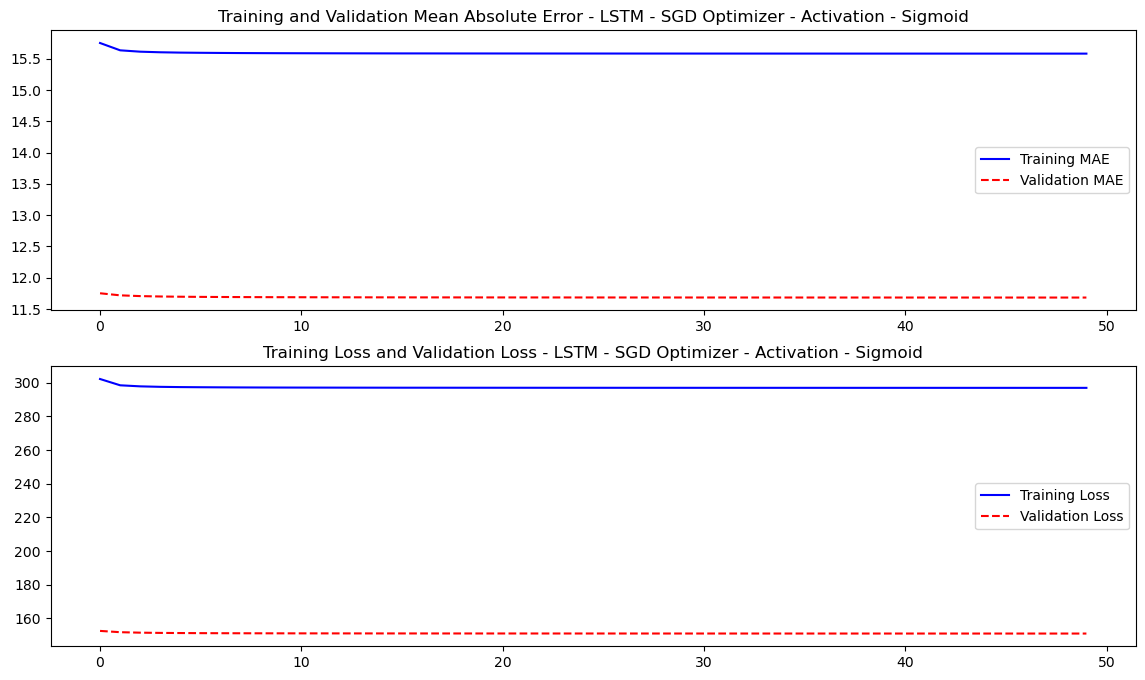

In [121]:
# Plot the Loss and MAE values for Training and Validation

fig,axes = plt.subplots(2,1,figsize=(14,8))
plt.subplot(2,1,1)
plt.plot(LSTM_sigmoid_maerror, 'b', label='Training MAE')
plt.plot(LSTM_sigmoid_val_maerror, 'r--', label='Validation MAE')
plt.title('Training and Validation Mean Absolute Error - LSTM - SGD Optimizer - Activation - Sigmoid')
plt.legend()
plt.subplot(2,1,2)
plt.plot(LSTM_sigmoid_loss, 'b', label='Training Loss')
plt.plot(LSTM_sigmoid_val_loss, 'r--', label='Validation Loss')
plt.title('Training Loss and Validation Loss - LSTM - SGD Optimizer - Activation - Sigmoid')
plt.legend()
plt.show()

In [122]:
# Calculate the RMSE for LSTM with Recurrant with Activation Function Sigmoid 

# Root Mean Square Error (RMSE) measures the average magnitude of errors in a set of predictions, 
# where a lower value signifies better prediction accuracy. 

LSTM_SGD_sigmoid_predict = LSTM_model_with_SGD_optimizer_sigmoid.predict(X_test)

LSTM_SGD_sigmoid_rmse = np.sqrt(mean_squared_error(y_test, LSTM_SGD_sigmoid_predict))

print('LSTM - SGD - Sigmoid - Root Mean Squared Error : {:.4f}'.format(LSTM_SGD_sigmoid_rmse))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
LSTM - SGD - Sigmoid - Root Mean Squared Error : 20.0817


#### **2. LSTM - Long Short Term Memory with Optimize: SGD Optimizer, Activation Function : ReLU**

In [123]:
# Evaluate with SGD Optimizer, Activation Sigmoid, With Dropouts

LSTM_model_with_SGD_optimizer_relu = Sequential()

LSTM_model_with_SGD_optimizer_relu.add(LSTM(units=100, return_sequences = True, input_shape=(X_train.shape[1], 1)))
LSTM_model_with_SGD_optimizer_relu.add(Dropout(0.2))

LSTM_model_with_SGD_optimizer_relu.add(LSTM(units=100, return_sequences = False))
LSTM_model_with_SGD_optimizer_relu.add(Dropout(0.2))

#Output layer
LSTM_model_with_SGD_optimizer_relu.add(Dense(units=1,activation='relu'))

In [124]:
# Let's review the summary of the model - Loss function is mean squared error, SGD learning rate is 0.001

LSTM_model_with_SGD_optimizer_relu.summary()

#Compiling
LSTM_model_with_SGD_optimizer_relu.compile(optimizer=SGD(learning_rate=0.001),
                                                loss='mean_squared_error', 
                                                metrics=['mean_absolute_error']
                                               )

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 15, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 15, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,301 (473.83 KB)

 Trainable params: 121,301 (473.83 KB)

 Non-trainable params: 0 (0.00 B)

In [125]:
#fitting the LSTM Model on the training dataset with 50 epochs and batch size 64

LSTM_scores_with_SGD_optimizer_relu=LSTM_model_with_SGD_optimizer_relu.fit(X_train,
                                                                                     y_train,
                                                                                     validation_data=(X_val,y_val),
                                                                                     epochs=50, 
                                                                                     batch_size=64
                                                                                    )

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 236.5036 - mean_absolute_error: 13.2291 - val_loss: 12.7808 - val_mean_absolute_error: 2.7398
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 56.6797 - mean_absolute_error: 5.9153 - val_loss: 21.7440 - val_mean_absolute_error: 3.8719
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 41.2669 - mean_absolute_error: 5.2279 - val_loss: 17.0854 - val_mean_absolute_error: 3.4230
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 34.2982 - mean_absolute_error: 4.7033 - val_loss: 22.1325 - val_mean_absolute_error: 4.0110
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 29.7219 - mean_absolute_error: 4.4694 - val_loss: 73.4371 - val_mean_absolute_error: 7.9782
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 33.1360 - mean_absolute_error: 4.6891 - val_loss: 17.3428 - val_mean_absolute_error: 3.5325
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 17.6289 - mean_absolute_error: 3.

In [126]:
LSTM_relu_loss = LSTM_scores_with_SGD_optimizer_relu.history['loss']
LSTM_relu_val_loss = LSTM_scores_with_SGD_optimizer_relu.history['val_loss']

LSTM_relu_maerror = LSTM_scores_with_SGD_optimizer_relu.history['mean_absolute_error']
LSTM_relu_val_maerror = LSTM_scores_with_SGD_optimizer_relu.history['val_mean_absolute_error']

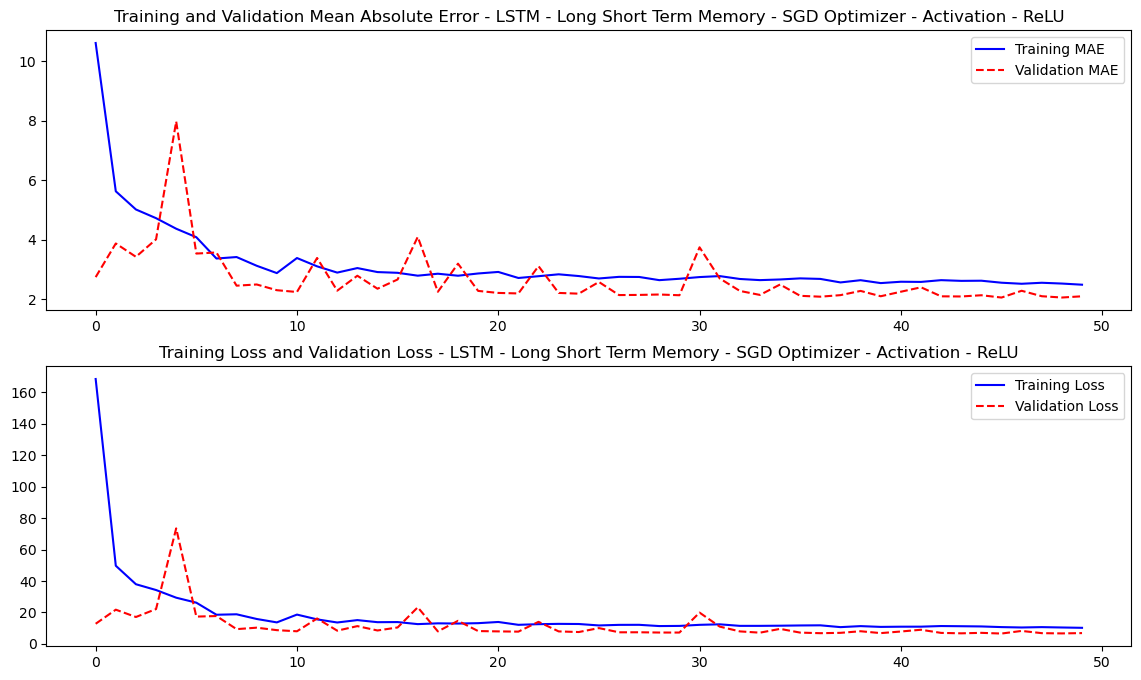

In [127]:
# Plot the Loss and MAE values for Training and Validation

fig,axes = plt.subplots(2,1,figsize=(14,8))
plt.subplot(2,1,1)
plt.plot(LSTM_relu_maerror, 'b', label='Training MAE')
plt.plot(LSTM_relu_val_maerror, 'r--', label='Validation MAE')
plt.title('Training and Validation Mean Absolute Error - LSTM - Long Short Term Memory - SGD Optimizer - Activation - ReLU')
plt.legend()
plt.subplot(2,1,2)
plt.plot(LSTM_relu_loss, 'b', label='Training Loss')
plt.plot(LSTM_relu_val_loss, 'r--', label='Validation Loss')
plt.title('Training Loss and Validation Loss - LSTM - Long Short Term Memory - SGD Optimizer - Activation - ReLU')
plt.legend()
plt.show()

In [128]:
# Calculate the RMSE for LSTM with Activation Function ReLU

# Root Mean Square Error (RMSE) measures the average magnitude of errors in a set of predictions, 
# where a lower value signifies better prediction accuracy. 

LSTM_SGD_relu_predict = LSTM_model_with_SGD_optimizer_relu.predict(X_test)

LSTM_SGD_relu_rmse = np.sqrt(mean_squared_error(y_test, LSTM_SGD_relu_predict))

print('LSTM - SGD - ReLU - Root Mean Squared Error : {:.4f}'.format(LSTM_SGD_relu_rmse))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
LSTM - SGD - ReLU - Root Mean Squared Error : 3.1940


#### **3. LSTM - Long Short Term Memory with Optimize: SGD Optimizer, Activation Function : TanH**

In [129]:
# Evaluate with SGD Optimizer, Activation Sigmoid, With Dropouts

LSTM_model_with_SGD_optimizer_tanh = Sequential()

LSTM_model_with_SGD_optimizer_tanh.add(LSTM(units=100, return_sequences = True, input_shape=(X_train.shape[1], 1)))
LSTM_model_with_SGD_optimizer_tanh.add(Dropout(0.2))

LSTM_model_with_SGD_optimizer_tanh.add(LSTM(units=100, return_sequences = False))
LSTM_model_with_SGD_optimizer_tanh.add(Dropout(0.2))

#Output layer
LSTM_model_with_SGD_optimizer_tanh.add(Dense(units=1,activation='tanh'))

In [130]:
# Let's review the summary of the model - Loss function is mean squared error, SGD learning rate is 0.001

LSTM_model_with_SGD_optimizer_tanh.summary()

#Compiling
LSTM_model_with_SGD_optimizer_tanh.compile(optimizer=SGD(learning_rate=0.001),
                                                loss='mean_squared_error', 
                                                metrics=['mean_absolute_error']
                                               )

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                  │ (None, 15, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 15, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,301 (473.83 KB)

 Trainable params: 121,301 (473.83 KB)

 Non-trainable params: 0 (0.00 B)

In [131]:
#fitting the LSTM Model on the training dataset with 50 epochs and batch size 64

LSTM_scores_with_SGD_optimizer_tanh=LSTM_model_with_SGD_optimizer_tanh.fit(X_train,
                                                                                     y_train,
                                                                                     validation_data=(X_val,y_val),
                                                                                     epochs=50, 
                                                                                     batch_size=64
                                                                                    )

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 313.1598 - mean_absolute_error: 16.0408 - val_loss: 151.2037 - val_mean_absolute_error: 11.6952
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 292.0775 - mean_absolute_error: 15.5352 - val_loss: 151.0712 - val_mean_absolute_error: 11.6893
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 291.9268 - mean_absolute_error: 15.4879 - val_loss: 151.0241 - val_mean_absolute_error: 11.6871
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 290.6519 - mean_absolute_error: 15.3827 - val_loss: 151.0001 - val_mean_absolute_error: 11.6861
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 298.1281 - mean_absolute_error: 15.5751 - val_loss: 150.9850 - val_mean_absolute_error: 11.6854
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 297.3987 - mean_absolute_error: 15.5536 - val_loss: 150.9748 - val_mean_absolute_error: 11.6849
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 291.5131 - 

In [132]:
LSTM_tanh_loss = LSTM_scores_with_SGD_optimizer_tanh.history['loss']
LSTM_tanh_val_loss = LSTM_scores_with_SGD_optimizer_tanh.history['val_loss']

LSTM_tanh_maerror = LSTM_scores_with_SGD_optimizer_tanh.history['mean_absolute_error']
LSTM_tanh_val_maerror = LSTM_scores_with_SGD_optimizer_tanh.history['val_mean_absolute_error']

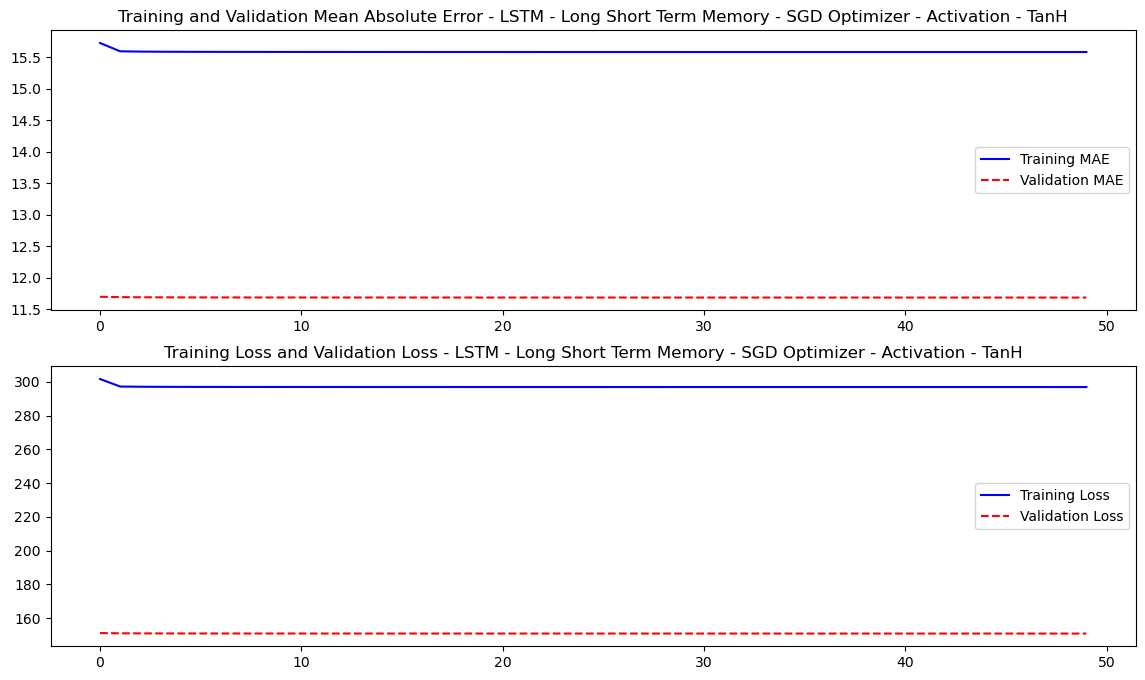

In [133]:
# Plot the Loss and MAE values for Training and Validation

fig,axes = plt.subplots(2,1,figsize=(14,8))
plt.subplot(2,1,1)
plt.plot(LSTM_tanh_maerror, 'b', label='Training MAE')
plt.plot(LSTM_tanh_val_maerror, 'r--', label='Validation MAE')
plt.title('Training and Validation Mean Absolute Error - LSTM - Long Short Term Memory - SGD Optimizer - Activation - TanH')
plt.legend()
plt.subplot(2,1,2)
plt.plot(LSTM_tanh_loss, 'b', label='Training Loss')
plt.plot(LSTM_tanh_val_loss, 'r--', label='Validation Loss')
plt.title('Training Loss and Validation Loss - LSTM - Long Short Term Memory - SGD Optimizer - Activation - TanH')
plt.legend()
plt.show()

In [134]:
# Calculate the RMSE for LSTM with Activation Function TanH 

# Root Mean Square Error (RMSE) measures the average magnitude of errors in a set of predictions, 
# where a lower value signifies better prediction accuracy. 

LSTM_SGD_tanh_predict = LSTM_model_with_SGD_optimizer_tanh.predict(X_test)

LSTM_SGD_tanh_rmse = np.sqrt(mean_squared_error(y_test, LSTM_SGD_tanh_predict))

print('LSTM - SGD - TanH - Root Mean Squared Error : {:.4f}'.format(LSTM_SGD_tanh_rmse))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
LSTM - SGD - TanH - Root Mean Squared Error : 20.0811


### Model Design

#### LSTM - Long Short Term Memory with Recurrent Dropout

In an LSTM network, **"dropout"** refers to randomly dropping units (neurons) within a single layer at each training iteration, while **"recurrent dropout"** specifically drops units within the hidden state that is passed between time steps in the recurrent connection, essentially preventing overfitting by reducing the dependence on the previous hidden state across time

We will use LSTM - Long Short Term Memory to see how the model behaves. We will run the LSTM - Long Short Term Memory using the three activation functions - sigmoid, ReLU, and TanH

#### **1. LSTM - Long Short Term Memory with Optimize and Recurrent Dropout: SGD Optimizer, Activation Function : Sigmoid**

In [135]:
# Evaluate with SGD Optimizer, Activation Sigmoid, With Dropouts

LSTM_model_with_SGD_optimizer_sigmoid_recurrent = Sequential()

LSTM_model_with_SGD_optimizer_sigmoid_recurrent.add(LSTM(units=100, return_sequences = True, recurrent_dropout= 0.2, 
                                                input_shape=(X_train.shape[1], 1)))
LSTM_model_with_SGD_optimizer_sigmoid_recurrent.add(Dropout(0.2))

LSTM_model_with_SGD_optimizer_sigmoid_recurrent.add(LSTM(units=100, return_sequences = False, recurrent_dropout = 0.2))
LSTM_model_with_SGD_optimizer_sigmoid_recurrent.add(Dropout(0.2))

#Output layer
LSTM_model_with_SGD_optimizer_sigmoid_recurrent.add(Dense(units=1, activation='sigmoid'))

In [136]:
# Let's review the summary of the model - Loss function is mean squared error, SGD learning rate is 0.001
# Since we are predicting a regression value, we will use mean squared error loss function and mean absolute error as metrics

LSTM_model_with_SGD_optimizer_sigmoid_recurrent.summary()

#Compiling
LSTM_model_with_SGD_optimizer_sigmoid_recurrent.compile(optimizer=SGD(learning_rate=0.001),
                                                loss='mean_squared_error', 
                                                metrics=['mean_absolute_error']
                                               )

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                  │ (None, 15, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 15, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,301 (473.83 KB)

 Trainable params: 121,301 (473.83 KB)

 Non-trainable params: 0 (0.00 B)

In [137]:
#fitting the LSTM Model on the training dataset with 50 epochs and batch size 64

LSTM_scores_with_SGD_optimizer_sigmoid_recurrent=LSTM_model_with_SGD_optimizer_sigmoid_recurrent.fit(X_train,
                                                                                     y_train,
                                                                                     validation_data=(X_val,y_val),
                                                                                     epochs=50, 
                                                                                     batch_size=64
                                                                                    )

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 306.1721 - mean_absolute_error: 15.8862 - val_loss: 152.4135 - val_mean_absolute_error: 11.7482
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 286.6334 - mean_absolute_error: 15.3738 - val_loss: 151.6581 - val_mean_absolute_error: 11.7152
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 294.8881 - mean_absolute_error: 15.5521 - val_loss: 151.4084 - val_mean_absolute_error: 11.7042
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 304.5571 - mean_absolute_error: 15.8406 - val_loss: 151.2835 - val_mean_absolute_error: 11.6986
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 292.2703 - mean_absolute_error: 15.4048 - val_loss: 151.2084 - val_mean_absolute_error: 11.6953
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 303.3176 - mean_absolute_error: 15.7687 - val_loss: 151.1580 - val_mean_absolute_error: 11.6930
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 300.7159 - 

In [138]:
LSTM_sigmoid_recurrent_loss = LSTM_scores_with_SGD_optimizer_sigmoid_recurrent.history['loss']
LSTM_sigmoid_recurrent_val_loss = LSTM_scores_with_SGD_optimizer_sigmoid_recurrent.history['val_loss']

LSTM_sigmoid_recurrent_maerror = LSTM_scores_with_SGD_optimizer_sigmoid_recurrent.history['mean_absolute_error']
LSTM_sigmoid_recurrent_val_maerror = LSTM_scores_with_SGD_optimizer_sigmoid_recurrent.history['val_mean_absolute_error']

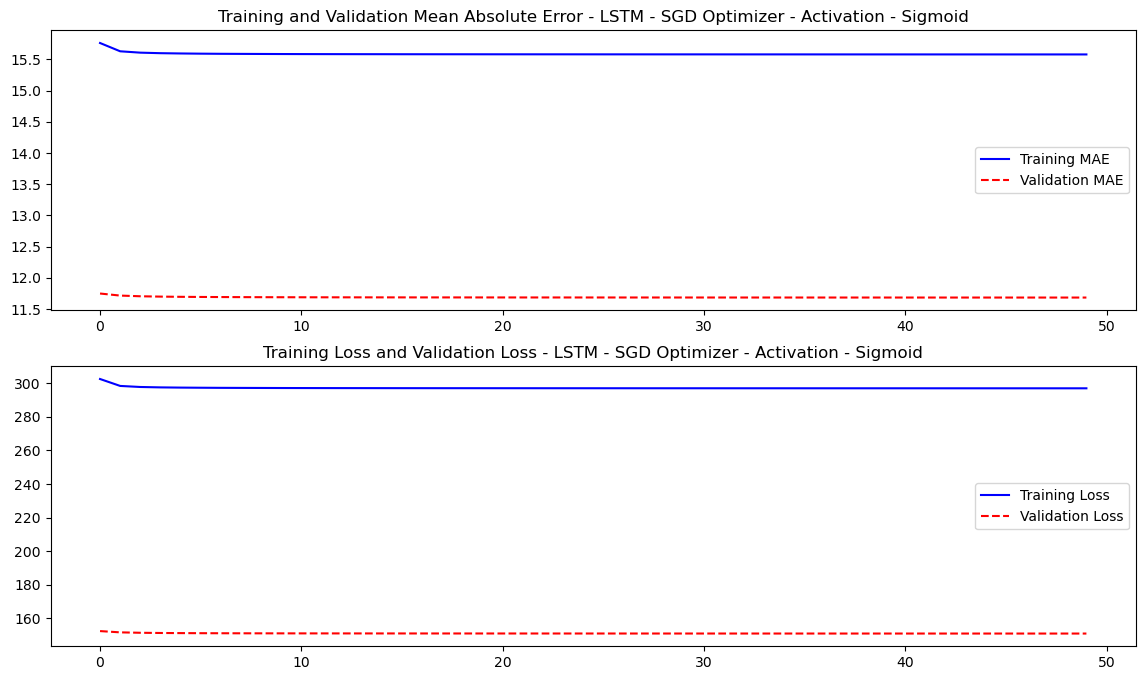

In [139]:
# Plot the Loss and MAE values for Training and Validation

fig,axes = plt.subplots(2,1,figsize=(14,8))
plt.subplot(2,1,1)
plt.plot(LSTM_sigmoid_recurrent_maerror, 'b', label='Training MAE')
plt.plot(LSTM_sigmoid_recurrent_val_maerror, 'r--', label='Validation MAE')
plt.title('Training and Validation Mean Absolute Error - LSTM - SGD Optimizer - Activation - Sigmoid')
plt.legend()
plt.subplot(2,1,2)
plt.plot(LSTM_sigmoid_recurrent_loss, 'b', label='Training Loss')
plt.plot(LSTM_sigmoid_recurrent_val_loss, 'r--', label='Validation Loss')
plt.title('Training Loss and Validation Loss - LSTM - SGD Optimizer - Activation - Sigmoid')
plt.legend()
plt.show()

In [140]:
# Calculate the RMSE for LSTM with Recurrant with Activation Function Sigmoid 

# Root Mean Square Error (RMSE) measures the average magnitude of errors in a set of predictions, 
# where a lower value signifies better prediction accuracy. 

LSTM_SGD_sigmoid_recurrent_predict = LSTM_model_with_SGD_optimizer_sigmoid_recurrent.predict(X_test)

LSTM_SGD_sigmoid_recurrent_rmse = np.sqrt(mean_squared_error(y_test, LSTM_SGD_sigmoid_recurrent_predict))

print('LSTM - SGD - Sigmoid - Recurrent - Root Mean Squared Error : {:.4f}'.format(LSTM_SGD_sigmoid_recurrent_rmse))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
LSTM - SGD - Sigmoid - Recurrent - Root Mean Squared Error : 20.0816


#### **2. LSTM - Long Short Term Memory with Optimize and Recurrent Dropout: SGD Optimizer, Activation Function : ReLU**

In [141]:
# Evaluate with SGD Optimizer, Activation Sigmoid, With Dropouts and Recurrent Dropout in LSTM

LSTM_model_with_SGD_optimizer_relu_recurrent = Sequential()

LSTM_model_with_SGD_optimizer_relu_recurrent.add(LSTM(units=100, return_sequences = True, recurrent_dropout= 0.2,
                                             input_shape=(X_train.shape[1], 1)))
LSTM_model_with_SGD_optimizer_relu_recurrent.add(Dropout(0.2))

LSTM_model_with_SGD_optimizer_relu_recurrent.add(LSTM(units=100, return_sequences = False, recurrent_dropout= 0.2))
LSTM_model_with_SGD_optimizer_relu_recurrent.add(Dropout(0.2))

#Output layer
LSTM_model_with_SGD_optimizer_relu_recurrent.add(Dense(units=1,activation='relu'))

In [142]:
# Let's review the summary of the model - Loss function is mean squared error, SGD learning rate is 0.001

LSTM_model_with_SGD_optimizer_relu_recurrent.summary()

#Compiling
LSTM_model_with_SGD_optimizer_relu_recurrent.compile(optimizer=SGD(learning_rate=0.001),
                                                loss='mean_squared_error', 
                                                metrics=['mean_absolute_error']
                                               )

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                  │ (None, 15, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 15, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,301 (473.83 KB)

 Trainable params: 121,301 (473.83 KB)

 Non-trainable params: 0 (0.00 B)

In [143]:
#fitting the LSTM Model on the training dataset with 50 epochs and batch size 64

LSTM_scores_with_SGD_optimizer_relu_recurrent=LSTM_model_with_SGD_optimizer_relu_recurrent.fit(X_train,
                                                                                     y_train,
                                                                                     validation_data=(X_val,y_val),
                                                                                     epochs=50, 
                                                                                     batch_size=64
                                                                                    )

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 216.3936 - mean_absolute_error: 12.6464 - val_loss: 13.0817 - val_mean_absolute_error: 2.7650
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 50.9141 - mean_absolute_error: 5.7467 - val_loss: 14.7940 - val_mean_absolute_error: 3.0630
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 36.5196 - mean_absolute_error: 4.8793 - val_loss: 17.0977 - val_mean_absolute_error: 3.4864
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 31.2075 - mean_absolute_error: 4.4538 - val_loss: 9.1189 - val_mean_absolute_error: 2.3565
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 28.9365 - mean_absolute_error: 4.3095 - val_loss: 36.9929 - val_mean_absolute_error: 5.3902
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 21.6673 - mean_absolute_error: 3.6717 - val_loss: 31.2607 - val_mean_absolute_error: 4.8827
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 18.3431 - mean_absolute_error: 3.4

In [144]:
LSTM_relu_recurrent_loss = LSTM_scores_with_SGD_optimizer_relu_recurrent.history['loss']
LSTM_relu_recurrent_val_loss = LSTM_scores_with_SGD_optimizer_relu_recurrent.history['val_loss']

LSTM_relu_recurrent_maerror = LSTM_scores_with_SGD_optimizer_relu_recurrent.history['mean_absolute_error']
LSTM_relu_recurrent_val_maerror = LSTM_scores_with_SGD_optimizer_relu_recurrent.history['val_mean_absolute_error']

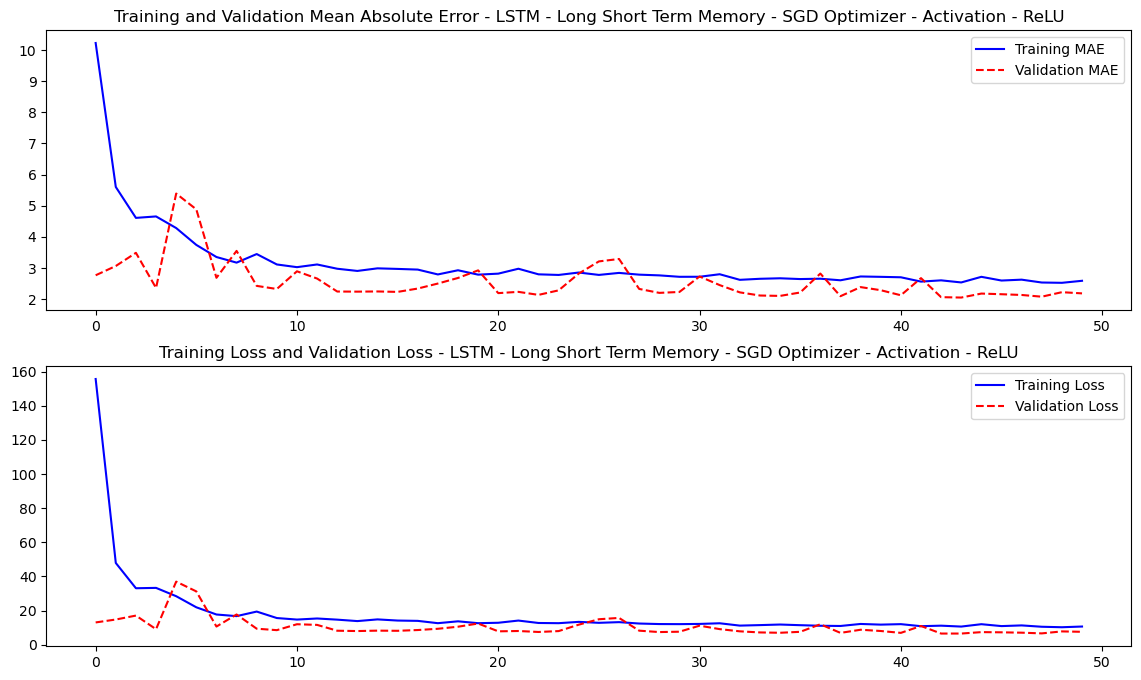

In [145]:
# Plot the Loss and MAE values for Training and Validation

fig,axes = plt.subplots(2,1,figsize=(14,8))
plt.subplot(2,1,1)
plt.plot(LSTM_relu_recurrent_maerror, 'b', label='Training MAE')
plt.plot(LSTM_relu_recurrent_val_maerror, 'r--', label='Validation MAE')
plt.title('Training and Validation Mean Absolute Error - LSTM - Long Short Term Memory - SGD Optimizer - Activation - ReLU')
plt.legend()
plt.subplot(2,1,2)
plt.plot(LSTM_relu_recurrent_loss, 'b', label='Training Loss')
plt.plot(LSTM_relu_recurrent_val_loss, 'r--', label='Validation Loss')
plt.title('Training Loss and Validation Loss - LSTM - Long Short Term Memory - SGD Optimizer - Activation - ReLU')
plt.legend()
plt.show()

In [146]:
# Calculate the RMSE for LSTM with Recurrant with Activation Function ReLU 

# Root Mean Square Error (RMSE) measures the average magnitude of errors in a set of predictions, 
# where a lower value signifies better prediction accuracy. 
LSTM_SGD_relu_recurrent_predict = LSTM_model_with_SGD_optimizer_relu_recurrent.predict(X_test)

LSTM_SGD_relu_recurrent_rmse = np.sqrt(mean_squared_error(y_test, LSTM_SGD_relu_recurrent_predict))

print('LSTM - SGD - ReLU - Recurrent - Root Mean Squared Error : {:.4f}'.format(LSTM_SGD_relu_recurrent_rmse))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
LSTM - SGD - ReLU - Recurrent - Root Mean Squared Error : 3.3571


#### **3. LSTM - Long Short Term Memory with Optimize and Recurrent Dropout: SGD Optimizer, Activation Function : TanH**

In [147]:
# Evaluate with SGD Optimizer, Activation Sigmoid, With Dropouts

LSTM_model_with_SGD_optimizer_tanh_recurrent = Sequential()

LSTM_model_with_SGD_optimizer_tanh_recurrent.add(LSTM(units=100, return_sequences = True, recurrent_dropout= 0.2,
                                             input_shape=(X_train.shape[1], 1)))
LSTM_model_with_SGD_optimizer_tanh_recurrent.add(Dropout(0.2))

LSTM_model_with_SGD_optimizer_tanh_recurrent.add(LSTM(units=100, return_sequences = False, recurrent_dropout= 0.2))
LSTM_model_with_SGD_optimizer_tanh_recurrent.add(Dropout(0.2))

#Output layer
LSTM_model_with_SGD_optimizer_tanh_recurrent.add(Dense(units=1,activation='tanh'))

In [148]:
# Let's review the summary of the model - Loss function is mean squared error, SGD learning rate is 0.001

LSTM_model_with_SGD_optimizer_tanh_recurrent.summary()

#Compiling
LSTM_model_with_SGD_optimizer_tanh_recurrent.compile(optimizer=SGD(learning_rate=0.001),
                                                loss='mean_squared_error', 
                                                metrics=['mean_absolute_error']
                                               )

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_22 (LSTM)                  │ (None, 15, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 15, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_23 (LSTM)                  │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,301 (473.83 KB)

 Trainable params: 121,301 (473.83 KB)

 Non-trainable params: 0 (0.00 B)

In [149]:
#fitting the LSTM Model on the training dataset with 50 epochs and batch size 64

LSTM_scores_with_SGD_optimizer_tanh_recurrent=LSTM_model_with_SGD_optimizer_tanh_recurrent.fit(X_train,
                                                                                     y_train,
                                                                                     validation_data=(X_val,y_val),
                                                                                     epochs=50, 
                                                                                     batch_size=64
                                                                                    )

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 305.7605 - mean_absolute_error: 15.9635 - val_loss: 151.2486 - val_mean_absolute_error: 11.6975
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 302.6446 - mean_absolute_error: 15.6934 - val_loss: 151.0873 - val_mean_absolute_error: 11.6901
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 303.0099 - mean_absolute_error: 15.7656 - val_loss: 151.0308 - val_mean_absolute_error: 11.6875
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 282.2174 - mean_absolute_error: 15.1400 - val_loss: 151.0020 - val_mean_absolute_error: 11.6862
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 294.6797 - mean_absolute_error: 15.5917 - val_loss: 150.9851 - val_mean_absolute_error: 11.6854
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 296.5998 - mean_absolute_error: 15.5860 - val_loss: 150.9744 - val_mean_absolute_error: 11.6849
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 304.8313 - 

In [150]:
LSTM_tanh_recurrent_loss = LSTM_scores_with_SGD_optimizer_tanh_recurrent.history['loss']
LSTM_tanh_recurrent_val_loss = LSTM_scores_with_SGD_optimizer_tanh_recurrent.history['val_loss']

LSTM_tanh_recurrent_maerror = LSTM_scores_with_SGD_optimizer_tanh_recurrent.history['mean_absolute_error']
LSTM_tanh_recurrent_val_maerror = LSTM_scores_with_SGD_optimizer_tanh_recurrent.history['val_mean_absolute_error']

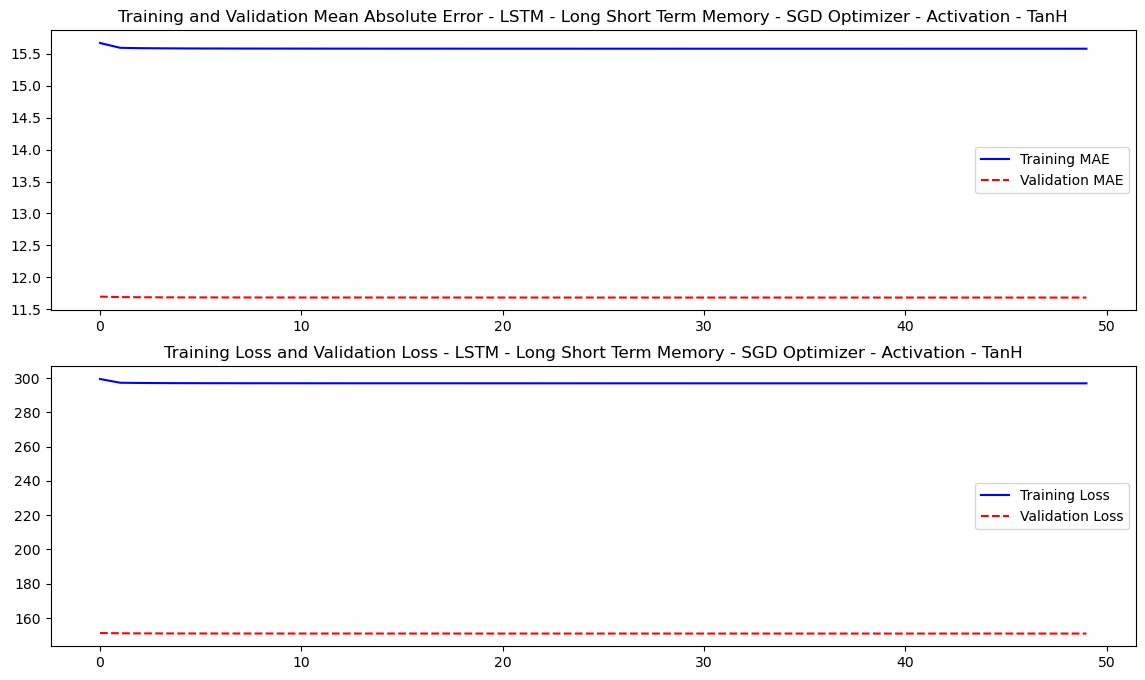

In [151]:
# Plot the Loss and MAE values for Training and Validation

fig,axes = plt.subplots(2,1,figsize=(14,8))
plt.subplot(2,1,1)
plt.plot(LSTM_tanh_recurrent_maerror, 'b', label='Training MAE')
plt.plot(LSTM_tanh_recurrent_val_maerror, 'r--', label='Validation MAE')
plt.title('Training and Validation Mean Absolute Error - LSTM - Long Short Term Memory - SGD Optimizer - Activation - TanH')
plt.legend()
plt.subplot(2,1,2)
plt.plot(LSTM_tanh_recurrent_loss, 'b', label='Training Loss')
plt.plot(LSTM_tanh_recurrent_val_loss, 'r--', label='Validation Loss')
plt.title('Training Loss and Validation Loss - LSTM - Long Short Term Memory - SGD Optimizer - Activation - TanH')
plt.legend()
plt.show()

In [152]:
# Calculate the RMSE for LSTM with Recurrant with Activation Function TanH 

# Root Mean Square Error (RMSE) measures the average magnitude of errors in a set of predictions, 
# where a lower value signifies better prediction accuracy. 

LSTM_SGD_tanh_recurrent_predict = LSTM_model_with_SGD_optimizer_tanh_recurrent.predict(X_test)

LSTM_SGD_tanh_recurrent_rmse = np.sqrt(mean_squared_error(y_test, LSTM_SGD_tanh_recurrent_predict))

print('LSTM - SGD - TanH - Recurrent - Root Mean Squared Error : {:.4f}'.format(LSTM_SGD_tanh_recurrent_rmse))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
LSTM - SGD - TanH - Recurrent - Root Mean Squared Error : 20.0810


### Model Design

#### GRU - Gated Recurrent Unit

Introduced by Cho, et al. in 2014, **GRU (Gated Recurrent Unit)** aims to solve the vanishing gradient problem which comes with a standard recurrent neural network. GRU's are a variation on the LSTM.

We will use GRU - Gated Recurrent Unit to see how the model behaves. We will run the GRU - Gated Recurrent Unit using the three activation functions - sigmoid, ReLU, and TanH

#### **1. GRU - Gated Recurrent Unit with Optimize: SGD Optimizer, Activation Function : Sigmoid**

In [153]:
# Evaluate with SGD Optimizer, Activation Sigmoid, With Dropouts

GRU_model_with_SGD_optimizer_sigmoid = Sequential()

GRU_model_with_SGD_optimizer_sigmoid.add(GRU(units=300, return_sequences = True, input_shape=(X_train.shape[1], 1)))
GRU_model_with_SGD_optimizer_sigmoid.add(Dropout(0.2))

GRU_model_with_SGD_optimizer_sigmoid.add(GRU(units=300, return_sequences = False))
GRU_model_with_SGD_optimizer_sigmoid.add(Dropout(0.2))

#Output layer
GRU_model_with_SGD_optimizer_sigmoid.add(Dense(units=1, activation='sigmoid'))

In [154]:
# Let's review the summary of the model - Loss function is mean squared error, SGD learning rate is 0.001
# Since we are predicting a regression value, we will use mean squared error loss function and mean absolute error as metrics

GRU_model_with_SGD_optimizer_sigmoid.summary()

#Compiling
GRU_model_with_SGD_optimizer_sigmoid.compile(optimizer=SGD(learning_rate=0.001),
                                                loss='mean_squared_error', 
                                                metrics=['mean_absolute_error']
                                               )

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_6 (GRU)                     │ (None, 15, 300)        │       272,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 15, 300)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_7 (GRU)                     │ (None, 300)            │       541,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │           301 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 814,801 (3.11 MB)

 Trainable params: 814,801 (3.11 MB)

 Non-trainable params: 0 (0.00 B)

In [155]:
#fitting the GRU Model on the training dataset with 50 epochs and batch size 64

GRU_scores_with_SGD_optimizer_sigmoid = GRU_model_with_SGD_optimizer_sigmoid.fit(X_train,
                                                                                     y_train,
                                                                                     validation_data=(X_val,y_val),
                                                                                     epochs=50, 
                                                                                     batch_size=64
                                                                                    )

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 295.3621 - mean_absolute_error: 15.5988 - val_loss: 151.1705 - val_mean_absolute_error: 11.6952
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 303.6906 - mean_absolute_error: 15.7463 - val_loss: 151.0536 - val_mean_absolute_error: 11.6894
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 293.2391 - mean_absolute_error: 15.5454 - val_loss: 151.0123 - val_mean_absolute_error: 11.6874
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 302.6685 - mean_absolute_error: 15.7487 - val_loss: 150.9904 - val_mean_absolute_error: 11.6862
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 299.8451 - mean_absolute_error: 15.6313 - val_loss: 150.9770 - val_mean_absolute_error: 11.6855
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 290.3143 - mean_absolute_error: 15.4008 - val_loss: 150.9680 - val_mean_absolute_error: 11.6851
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 294.0835 - 

In [156]:
GRU_sigmoid_loss = GRU_scores_with_SGD_optimizer_sigmoid.history['loss']
GRU_sigmoid_val_loss = GRU_scores_with_SGD_optimizer_sigmoid.history['val_loss']

GRU_sigmoid_maerror = GRU_scores_with_SGD_optimizer_sigmoid.history['mean_absolute_error']
GRU_sigmoid_val_maerror = GRU_scores_with_SGD_optimizer_sigmoid.history['val_mean_absolute_error']

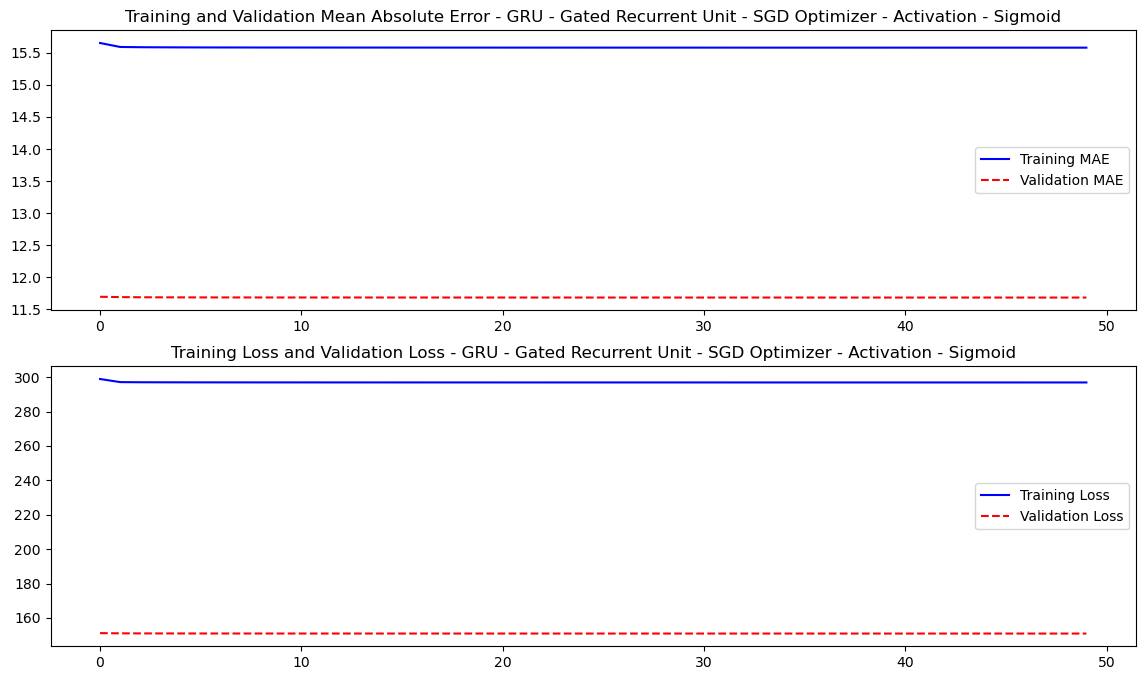

In [157]:
# Plot the Loss and MAE values for Training and Validation

fig,axes = plt.subplots(2,1,figsize=(14,8))
plt.subplot(2,1,1)
plt.plot(GRU_sigmoid_maerror, 'b', label='Training MAE')
plt.plot(GRU_sigmoid_val_maerror, 'r--', label='Validation MAE')
plt.title('Training and Validation Mean Absolute Error - GRU - Gated Recurrent Unit - SGD Optimizer - Activation - Sigmoid')
plt.legend()
plt.subplot(2,1,2)
plt.plot(GRU_sigmoid_loss, 'b', label='Training Loss')
plt.plot(GRU_sigmoid_val_loss, 'r--', label='Validation Loss')
plt.title('Training Loss and Validation Loss - GRU - Gated Recurrent Unit - SGD Optimizer - Activation - Sigmoid')
plt.legend()
plt.show()

In [158]:
# Calculate the RMSE for GRU with Activation Function Sigmoid 

# Root Mean Square Error (RMSE) measures the average magnitude of errors in a set of predictions, 
# where a lower value signifies better prediction accuracy. 

GRU_SGD_sigmoid_predict = GRU_model_with_SGD_optimizer_sigmoid.predict(X_test)

GRU_SGD_sigmoid_rmse = np.sqrt(mean_squared_error(y_test, GRU_SGD_sigmoid_predict))

print('GRU - SGD - Sigmoid - Root Mean Squared Error : {:.4f}'.format(GRU_SGD_sigmoid_rmse))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
GRU - SGD - Sigmoid - Root Mean Squared Error : 20.0810


#### **2. GRU - Gated Recurrent Unit with Optimize: SGD Optimizer, Activation Function : ReLU**

In [159]:
# Evaluate with SGD Optimizer, Activation Sigmoid, With Dropouts and Recurrent Dropout in GRU

GRU_model_with_SGD_optimizer_relu = Sequential()

GRU_model_with_SGD_optimizer_relu.add(GRU(units=300, return_sequences = True, input_shape=(X_train.shape[1], 1)))
GRU_model_with_SGD_optimizer_relu.add(Dropout(0.2))

GRU_model_with_SGD_optimizer_relu.add(GRU(units=300, return_sequences = False))
GRU_model_with_SGD_optimizer_relu.add(Dropout(0.2))

#Output layer
GRU_model_with_SGD_optimizer_relu.add(Dense(units=1,activation='relu'))

In [160]:
# Let's review the summary of the model - Loss function is mean squared error, SGD learning rate is 0.001

GRU_model_with_SGD_optimizer_relu.summary()

#Compiling
GRU_model_with_SGD_optimizer_relu.compile(optimizer=SGD(learning_rate=0.001),
                                                loss='mean_squared_error', 
                                                metrics=['mean_absolute_error']
                                               )

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_8 (GRU)                     │ (None, 15, 300)        │       272,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 15, 300)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_9 (GRU)                     │ (None, 300)            │       541,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1)              │           301 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 814,801 (3.11 MB)

 Trainable params: 814,801 (3.11 MB)

 Non-trainable params: 0 (0.00 B)

In [161]:
#fitting the GRU Model on the training dataset with 50 epochs and batch size 64

GRU_scores_with_SGD_optimizer_relu = GRU_model_with_SGD_optimizer_relu.fit(X_train,
                                                                                     y_train,
                                                                                     validation_data=(X_val,y_val),
                                                                                     epochs=50, 
                                                                                     batch_size=64
                                                                                    )

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 108.0648 - mean_absolute_error: 7.7251 - val_loss: 14.8314 - val_mean_absolute_error: 3.2029
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 20.9209 - mean_absolute_error: 3.6764 - val_loss: 15.2888 - val_mean_absolute_error: 3.2599
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 16.0583 - mean_absolute_error: 3.1785 - val_loss: 15.9835 - val_mean_absolute_error: 3.3189
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 16.4643 - mean_absolute_error: 3.2722 - val_loss: 12.9969 - val_mean_absolute_error: 2.9458
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 13.4245 - mean_absolute_error: 2.9372 - val_loss: 7.8311 - val_mean_absolute_error: 2.1978
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 13.6870 - mean_absolute_error: 2.9141 - val_loss: 17.7813 - val_mean_absolute_error: 3.4934
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 14.4715 - mean_absolute_error: 3.12

In [162]:
GRU_relu_loss = GRU_scores_with_SGD_optimizer_relu.history['loss']
GRU_relu_val_loss = GRU_scores_with_SGD_optimizer_relu.history['val_loss']

GRU_relu_maerror = GRU_scores_with_SGD_optimizer_relu.history['mean_absolute_error']
GRU_relu_val_maerror = GRU_scores_with_SGD_optimizer_relu.history['val_mean_absolute_error']

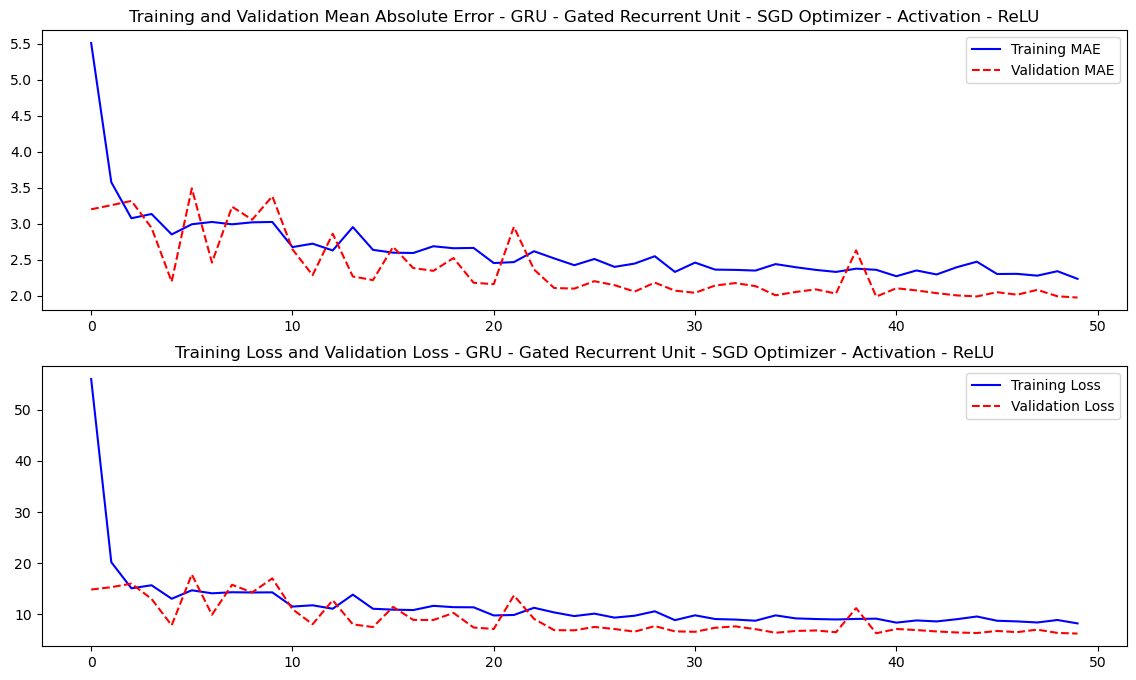

In [163]:
# Plot the Loss and MAE values for Training and Validation

fig,axes = plt.subplots(2,1,figsize=(14,8))
plt.subplot(2,1,1)
plt.plot(GRU_relu_maerror, 'b', label='Training MAE')
plt.plot(GRU_relu_val_maerror, 'r--', label='Validation MAE')
plt.title('Training and Validation Mean Absolute Error - GRU - Gated Recurrent Unit - SGD Optimizer - Activation - ReLU')
plt.legend()
plt.subplot(2,1,2)
plt.plot(GRU_relu_loss, 'b', label='Training Loss')
plt.plot(GRU_relu_val_loss, 'r--', label='Validation Loss')
plt.title('Training Loss and Validation Loss - GRU - Gated Recurrent Unit - SGD Optimizer - Activation - ReLU')
plt.legend()
plt.show()

In [164]:
# Calculate the RMSE for GRU with Activation Function ReLU 

# Root Mean Square Error (RMSE) measures the average magnitude of errors in a set of predictions, 
# where a lower value signifies better prediction accuracy. 

GRU_SGD_relu_predict = GRU_model_with_SGD_optimizer_relu.predict(X_test)

GRU_SGD_relu_rmse = np.sqrt(mean_squared_error(y_test, GRU_SGD_relu_predict))

print('GRU - SGD - ReLU - Root Mean Squared Error : {:.4f}'.format(GRU_SGD_relu_rmse))

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
GRU - SGD - ReLU - Root Mean Squared Error : 2.9570


#### **3. GRU - Gated Recurrent Unit with Optimize: SGD Optimizer, Activation Function : TanH**

In [165]:
# Evaluate with SGD Optimizer, Activation Sigmoid, With Dropouts

GRU_model_with_SGD_optimizer_tanh = Sequential()

GRU_model_with_SGD_optimizer_tanh.add(GRU(units=300, return_sequences = True, input_shape=(X_train.shape[1], 1)))
GRU_model_with_SGD_optimizer_tanh.add(Dropout(0.2))

GRU_model_with_SGD_optimizer_tanh.add(GRU(units=300, return_sequences = False))
GRU_model_with_SGD_optimizer_tanh.add(Dropout(0.2))

#Output layer
GRU_model_with_SGD_optimizer_tanh.add(Dense(units=1,activation='tanh'))

In [166]:
# Let's review the summary of the model - Loss function is mean squared error, SGD learning rate is 0.001

GRU_model_with_SGD_optimizer_tanh.summary()

#Compiling
GRU_model_with_SGD_optimizer_tanh.compile(optimizer=SGD(learning_rate=0.001),
                                                loss='mean_squared_error', 
                                                metrics=['mean_absolute_error']
                                               )

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_10 (GRU)                    │ (None, 15, 300)        │       272,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 15, 300)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_11 (GRU)                    │ (None, 300)            │       541,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │           301 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 814,801 (3.11 MB)

 Trainable params: 814,801 (3.11 MB)

 Non-trainable params: 0 (0.00 B)

In [167]:
#fitting the GRU Model on the training dataset with 50 epochs and batch size 64

GRU_scores_with_SGD_optimizer_tanh = GRU_model_with_SGD_optimizer_tanh.fit(X_train,
                                                                                     y_train,
                                                                                     validation_data=(X_val,y_val),
                                                                                     epochs=50, 
                                                                                     batch_size=64
                                                                                    )

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 311.2543 - mean_absolute_error: 15.9842 - val_loss: 150.9223 - val_mean_absolute_error: 11.6825
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 284.8995 - mean_absolute_error: 15.3113 - val_loss: 150.9223 - val_mean_absolute_error: 11.6825
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 298.5837 - mean_absolute_error: 15.6630 - val_loss: 150.9223 - val_mean_absolute_error: 11.6825
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 282.3333 - mean_absolute_error: 15.0798 - val_loss: 150.9223 - val_mean_absolute_error: 11.6825
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 308.6285 - mean_absolute_error: 15.9035 - val_loss: 150.9223 - val_mean_absolute_error: 11.6825
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 288.5733 - mean_absolute_error: 15.3221 - val_loss: 150.9223 - val_mean_absolute_error: 11.6825
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 301.6906 - 

In [168]:
GRU_tanh_loss = GRU_scores_with_SGD_optimizer_tanh.history['loss']
GRU_tanh_val_loss = GRU_scores_with_SGD_optimizer_tanh.history['val_loss']

GRU_tanh_maerror = GRU_scores_with_SGD_optimizer_tanh.history['mean_absolute_error']
GRU_tanh_val_maerror = GRU_scores_with_SGD_optimizer_tanh.history['val_mean_absolute_error']

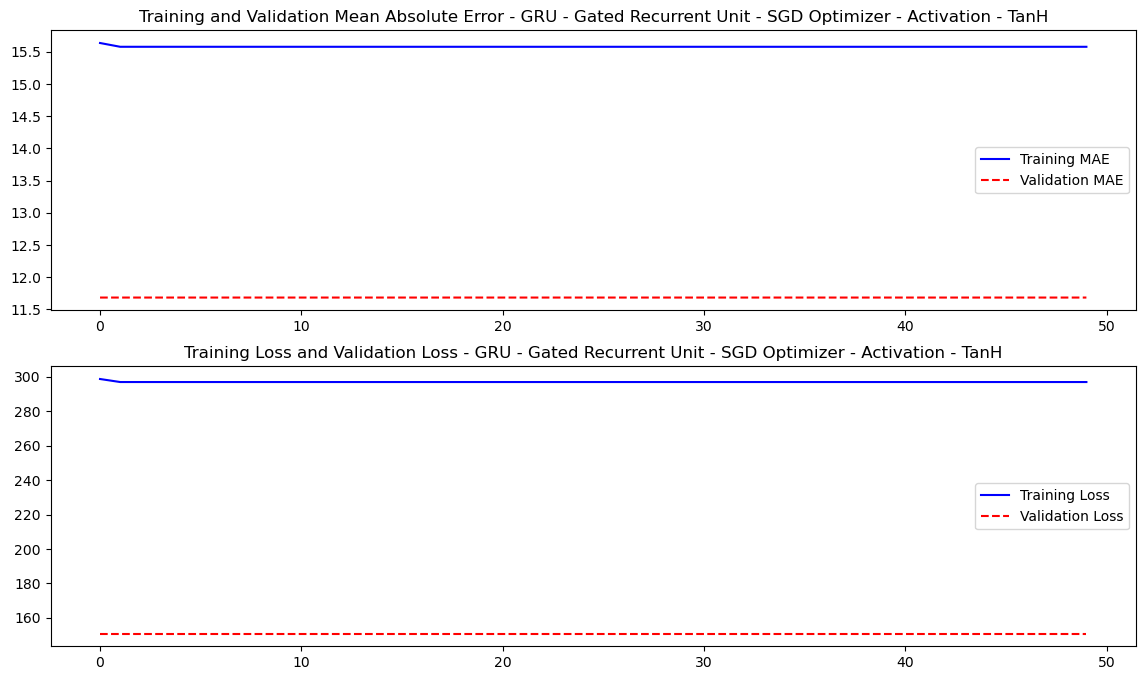

In [169]:
# Plot the Loss and MAE values for Training and Validation

fig,axes = plt.subplots(2,1,figsize=(14,8))
plt.subplot(2,1,1)
plt.plot(GRU_tanh_maerror, 'b', label='Training MAE')
plt.plot(GRU_tanh_val_maerror, 'r--', label='Validation MAE')
plt.title('Training and Validation Mean Absolute Error - GRU - Gated Recurrent Unit - SGD Optimizer - Activation - TanH')
plt.legend()
plt.subplot(2,1,2)
plt.plot(GRU_tanh_loss, 'b', label='Training Loss')
plt.plot(GRU_tanh_val_loss, 'r--', label='Validation Loss')
plt.title('Training Loss and Validation Loss - GRU - Gated Recurrent Unit - SGD Optimizer - Activation - TanH')
plt.legend()
plt.show()

In [170]:
# Calculate the RMSE for GRU with Activation Function TanH 

# Root Mean Square Error (RMSE) measures the average magnitude of errors in a set of predictions, 
# where a lower value signifies better prediction accuracy. 

GRU_SGD_tanh_predict = GRU_model_with_SGD_optimizer_tanh.predict(X_test)

GRU_SGD_tanh_rmse = np.sqrt(mean_squared_error(y_test, GRU_SGD_tanh_predict))

print('GRU - SGD - TanH - Root Mean Squared Error : {:.4f}'.format(GRU_SGD_tanh_rmse))


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
GRU - SGD - TanH - Root Mean Squared Error : 20.0809


### Summarize the Results into a DataFrame Table

Let's capture all the outputs and summarize them into a dataframe table and display the results

In [171]:
# Create a set of lists for all the values:
# Training Loss, Validation Loss, Training MAE, Validation MAE, and Root Mean Squared Error
# Also identify what kind of model we have:
# RNN Type (Simple RNN, LSTM, or GRU), Optimizer (Adam or SGD), and if Recurrent Dropout was used

train_loss_list     = [
                        round(SimpleRNN_scores_with_adam_optimizer_sigmoid.history['loss'][-1],4),
                        round(SimpleRNN_scores_with_adam_optimizer_relu.history['loss'][-1],4),
                        round(SimpleRNN_scores_with_adam_optimizer_tanh.history['loss'][-1],4),
                        round(SimpleRNN_scores_with_SGD_optimizer_sigmoid.history['loss'][-1],4),
                        round(SimpleRNN_scores_with_SGD_optimizer_relu.history['loss'][-1],4),
                        round(SimpleRNN_scores_with_SGD_optimizer_tanh.history['loss'][-1],4),

                        round(LSTM_scores_with_adam_optimizer_sigmoid.history['loss'][-1],4),
                        round(LSTM_scores_with_adam_optimizer_relu.history['loss'][-1],4),
                        round(LSTM_scores_with_adam_optimizer_tanh.history['loss'][-1],4),
                        round(LSTM_scores_with_SGD_optimizer_sigmoid.history['loss'][-1],4),
                        round(LSTM_scores_with_SGD_optimizer_relu.history['loss'][-1],4),
                        round(LSTM_scores_with_SGD_optimizer_tanh.history['loss'][-1],4),

                        round(LSTM_scores_with_adam_optimizer_sigmoid_recurrent.history['loss'][-1],4),
                        round(LSTM_scores_with_adam_optimizer_relu_recurrent.history['loss'][-1],4),
                        round(LSTM_scores_with_adam_optimizer_tanh_recurrent.history['loss'][-1],4),
                        round(LSTM_scores_with_SGD_optimizer_sigmoid_recurrent.history['loss'][-1],4),
                        round(LSTM_scores_with_SGD_optimizer_relu_recurrent.history['loss'][-1],4),
                        round(LSTM_scores_with_SGD_optimizer_tanh_recurrent.history['loss'][-1],4),

                        round(GRU_scores_with_adam_optimizer_sigmoid.history['loss'][-1],4),
                        round(GRU_scores_with_adam_optimizer_relu.history['loss'][-1],4),
                        round(GRU_scores_with_adam_optimizer_tanh.history['loss'][-1],4),
                        round(GRU_scores_with_SGD_optimizer_sigmoid.history['loss'][-1],4),
                        round(GRU_scores_with_SGD_optimizer_relu.history['loss'][-1],4),
                        round(GRU_scores_with_SGD_optimizer_tanh.history['loss'][-1],4),
                      ]

train_val_loss_list = [
                        round(SimpleRNN_scores_with_adam_optimizer_sigmoid.history['val_loss'][-1],4),
                        round(SimpleRNN_scores_with_adam_optimizer_relu.history['val_loss'][-1],4),
                        round(SimpleRNN_scores_with_adam_optimizer_tanh.history['val_loss'][-1],4),
                        round(SimpleRNN_scores_with_SGD_optimizer_sigmoid.history['val_loss'][-1],4),
                        round(SimpleRNN_scores_with_SGD_optimizer_relu.history['val_loss'][-1],4),
                        round(SimpleRNN_scores_with_SGD_optimizer_tanh.history['val_loss'][-1],4),
                        
                        round(LSTM_scores_with_adam_optimizer_sigmoid.history['val_loss'][-1],4),
                        round(LSTM_scores_with_adam_optimizer_relu.history['val_loss'][-1],4),
                        round(LSTM_scores_with_adam_optimizer_tanh.history['val_loss'][-1],4),
                        round(LSTM_scores_with_SGD_optimizer_sigmoid.history['val_loss'][-1],4),
                        round(LSTM_scores_with_SGD_optimizer_relu.history['val_loss'][-1],4),
                        round(LSTM_scores_with_SGD_optimizer_tanh.history['val_loss'][-1],4),
                        
                        round(LSTM_scores_with_adam_optimizer_sigmoid_recurrent.history['val_loss'][-1],4),
                        round(LSTM_scores_with_adam_optimizer_relu_recurrent.history['val_loss'][-1],4),
                        round(LSTM_scores_with_adam_optimizer_tanh_recurrent.history['val_loss'][-1],4),
                        round(LSTM_scores_with_SGD_optimizer_sigmoid_recurrent.history['val_loss'][-1],4),
                        round(LSTM_scores_with_SGD_optimizer_relu_recurrent.history['val_loss'][-1],4),
                        round(LSTM_scores_with_SGD_optimizer_tanh_recurrent.history['val_loss'][-1],4),

                        round(GRU_scores_with_adam_optimizer_sigmoid.history['val_loss'][-1],4),
                        round(GRU_scores_with_adam_optimizer_relu.history['val_loss'][-1],4),
                        round(GRU_scores_with_adam_optimizer_tanh.history['val_loss'][-1],4),
                        round(GRU_scores_with_SGD_optimizer_sigmoid.history['val_loss'][-1],4),
                        round(GRU_scores_with_SGD_optimizer_relu.history['val_loss'][-1],4),
                        round(GRU_scores_with_SGD_optimizer_tanh.history['val_loss'][-1],4),
                        
                      ]

mean_absolute_error_list = [
                        round(SimpleRNN_scores_with_adam_optimizer_sigmoid.history['mean_absolute_error'][-1],4),
                        round(SimpleRNN_scores_with_adam_optimizer_relu.history['mean_absolute_error'][-1],4),
                        round(SimpleRNN_scores_with_adam_optimizer_tanh.history['mean_absolute_error'][-1],4),
                        round(SimpleRNN_scores_with_SGD_optimizer_sigmoid.history['mean_absolute_error'][-1],4),
                        round(SimpleRNN_scores_with_SGD_optimizer_relu.history['mean_absolute_error'][-1],4),
                        round(SimpleRNN_scores_with_SGD_optimizer_tanh.history['mean_absolute_error'][-1],4),
                        
                        round(LSTM_scores_with_adam_optimizer_sigmoid.history['mean_absolute_error'][-1],4),
                        round(LSTM_scores_with_adam_optimizer_relu.history['mean_absolute_error'][-1],4),
                        round(LSTM_scores_with_adam_optimizer_tanh.history['mean_absolute_error'][-1],4),
                        round(LSTM_scores_with_SGD_optimizer_sigmoid.history['mean_absolute_error'][-1],4),
                        round(LSTM_scores_with_SGD_optimizer_relu.history['mean_absolute_error'][-1],4),
                        round(LSTM_scores_with_SGD_optimizer_tanh.history['mean_absolute_error'][-1],4),

                        round(LSTM_scores_with_adam_optimizer_sigmoid_recurrent.history['mean_absolute_error'][-1],4),
                        round(LSTM_scores_with_adam_optimizer_relu_recurrent.history['mean_absolute_error'][-1],4),
                        round(LSTM_scores_with_adam_optimizer_tanh_recurrent.history['mean_absolute_error'][-1],4),
                        round(LSTM_scores_with_SGD_optimizer_sigmoid_recurrent.history['mean_absolute_error'][-1],4),
                        round(LSTM_scores_with_SGD_optimizer_relu_recurrent.history['mean_absolute_error'][-1],4),
                        round(LSTM_scores_with_SGD_optimizer_tanh_recurrent.history['mean_absolute_error'][-1],4),

                        round(GRU_scores_with_adam_optimizer_sigmoid.history['mean_absolute_error'][-1],4),
                        round(GRU_scores_with_adam_optimizer_relu.history['mean_absolute_error'][-1],4),
                        round(GRU_scores_with_adam_optimizer_tanh.history['mean_absolute_error'][-1],4),
                        round(GRU_scores_with_SGD_optimizer_sigmoid.history['mean_absolute_error'][-1],4),
                        round(GRU_scores_with_SGD_optimizer_relu.history['mean_absolute_error'][-1],4),
                        round(GRU_scores_with_SGD_optimizer_tanh.history['mean_absolute_error'][-1],4),
                      ]

mean_absolute_error_val_list = [
                        round(SimpleRNN_scores_with_adam_optimizer_sigmoid.history['val_mean_absolute_error'][-1],4),
                        round(SimpleRNN_scores_with_adam_optimizer_relu.history['val_mean_absolute_error'][-1],4),
                        round(SimpleRNN_scores_with_adam_optimizer_tanh.history['val_mean_absolute_error'][-1],4),
                        round(SimpleRNN_scores_with_SGD_optimizer_sigmoid.history['val_mean_absolute_error'][-1],4),
                        round(SimpleRNN_scores_with_SGD_optimizer_relu.history['val_mean_absolute_error'][-1],4),
                        round(SimpleRNN_scores_with_SGD_optimizer_tanh.history['val_mean_absolute_error'][-1],4),

                        round(LSTM_scores_with_adam_optimizer_sigmoid.history['val_mean_absolute_error'][-1],4),
                        round(LSTM_scores_with_adam_optimizer_relu.history['val_mean_absolute_error'][-1],4),
                        round(LSTM_scores_with_adam_optimizer_tanh.history['val_mean_absolute_error'][-1],4),
                        round(LSTM_scores_with_SGD_optimizer_sigmoid.history['val_mean_absolute_error'][-1],4),
                        round(LSTM_scores_with_SGD_optimizer_relu.history['val_mean_absolute_error'][-1],4),
                        round(LSTM_scores_with_SGD_optimizer_tanh.history['val_mean_absolute_error'][-1],4),

                        round(LSTM_scores_with_adam_optimizer_sigmoid_recurrent.history['val_mean_absolute_error'][-1],4),
                        round(LSTM_scores_with_adam_optimizer_relu_recurrent.history['val_mean_absolute_error'][-1],4),
                        round(LSTM_scores_with_adam_optimizer_tanh_recurrent.history['val_mean_absolute_error'][-1],4),
                        round(LSTM_scores_with_SGD_optimizer_sigmoid_recurrent.history['val_mean_absolute_error'][-1],4),
                        round(LSTM_scores_with_SGD_optimizer_relu_recurrent.history['val_mean_absolute_error'][-1],4),
                        round(LSTM_scores_with_SGD_optimizer_tanh_recurrent.history['val_mean_absolute_error'][-1],4),

                        round(GRU_scores_with_adam_optimizer_sigmoid.history['val_mean_absolute_error'][-1],4),
                        round(GRU_scores_with_adam_optimizer_relu.history['val_mean_absolute_error'][-1],4),
                        round(GRU_scores_with_adam_optimizer_tanh.history['val_mean_absolute_error'][-1],4),
                        round(GRU_scores_with_SGD_optimizer_sigmoid.history['val_mean_absolute_error'][-1],4),
                        round(GRU_scores_with_SGD_optimizer_relu.history['val_mean_absolute_error'][-1],4),
                        round(GRU_scores_with_SGD_optimizer_tanh.history['val_mean_absolute_error'][-1],4),
                      ]

root_mean_squared_error_list = [
                        round(SimpleRNN_adam_sigmoid_rmse,4),
                        round(SimpleRNN_adam_relu_rmse,4),
                        round(SimpleRNN_adam_tanh_rmse,4),
                        round(SimpleRNN_SGD_sigmoid_rmse,4),
                        round(SimpleRNN_SGD_relu_rmse,4),
                        round(SimpleRNN_SGD_tanh_rmse,4),

                        round(LSTM_adam_sigmoid_rmse,4),
                        round(LSTM_adam_relu_rmse,4),
                        round(LSTM_adam_tanh_rmse,4),
                        round(LSTM_SGD_sigmoid_rmse,4),
                        round(LSTM_SGD_relu_rmse,4),
                        round(LSTM_SGD_tanh_rmse,4),

                        round(LSTM_adam_sigmoid_recurrent_rmse,4),
                        round(LSTM_adam_relu_recurrent_rmse,4),
                        round(LSTM_adam_tanh_recurrent_rmse,4),
                        round(LSTM_SGD_sigmoid_recurrent_rmse,4),
                        round(LSTM_SGD_relu_recurrent_rmse,4),
                        round(LSTM_SGD_tanh_recurrent_rmse,4),

                        round(GRU_adam_sigmoid_rmse,4),
                        round(GRU_adam_relu_rmse,4),
                        round(GRU_adam_tanh_rmse,4),
                        round(GRU_SGD_sigmoid_rmse,4),
                        round(GRU_SGD_relu_rmse,4),
                        round(GRU_SGD_tanh_rmse,4),
                      ]

RNN_List          = ['Simple RNN'] * 6 + ['LSTM'] * 12 + ['GRU'] * 6
Activation_list   = ['Sigmoid', 'ReLU', 'TanH'] * 8
Optimizer_list    = ['Adam', 'Adam',  'Adam', 'SDG', 'SDG', 'SGD'] * 4
Reccurent_list    = ['No'] * 12 + ['Yes'] * 6 + ['No'] * 6 

In [172]:

results_summary = pd.DataFrame({'RNN Type'         : RNN_List,
                                'Activation'       : Activation_list,
                                'Optimizer'        : Optimizer_list,
                                'Recurrent Dropout': Reccurent_list,
                                'Training Loss'    : train_loss_list,
                                'Validation Loss'  : train_val_loss_list,
                                'Training MAE'     : mean_absolute_error_list,
                                'Validation MAE'   : mean_absolute_error_val_list,
                                'Root Mean Squared Error' :  root_mean_squared_error_list
                               })
results_summary

RNN Type Activation Optimizer Recurrent Dropout  Training Loss  \
0   Simple RNN    Sigmoid      Adam                No       296.8972   
1   Simple RNN       ReLU      Adam                No         9.1420   
2   Simple RNN       TanH      Adam                No       296.8966   
3   Simple RNN    Sigmoid       SDG                No       296.9086   
4   Simple RNN       ReLU       SDG                No        10.2917   
5   Simple RNN       TanH       SGD                No       296.9003   
6         LSTM    Sigmoid      Adam                No       296.8969   
7         LSTM       ReLU      Adam                No         8.3863   
8         LSTM       TanH      Adam                No       296.8967   
9         LSTM    Sigmoid       SDG                No       296.9354   
10        LSTM       ReLU       SDG                No        10.2066   
11        LSTM       TanH       SGD                No       296.9081   
12        LSTM    Sigmoid      Adam               Yes       296.8969   
13        LSTM       ReLU      Adam               Yes         8.7568   
14        LSTM       TanH      Adam               Yes       296.8967   
15        LSTM    Sigmoid       SDG               Yes       296.9349   
16        LSTM       ReLU       SDG               Yes        10.6841   
17        LSTM       TanH       SGD               Yes       296.9075   
18         GRU    Sigmoid      Adam                No       296.8966   
19         GRU       ReLU      Adam                No         7.6104   
20         GRU       TanH      Adam                No       296.8966   
21         GRU    Sigmoid       SDG                No       296.9081   
22         GRU       ReLU       SDG                No         8.2064   
23         GRU       TanH       SGD                No       296.9006   

    Validation Loss  Training MAE  Validation MAE  Root Mean Squared Error  
0          150.9221       15.5791         11.6825                  20.0809  
1            7.0457        2.3708          2.0932                   3.1969  
2          150.9219       15.5791         11.6825                  20.0809  
3          150.9252       15.5797         11.6827                  20.0810  
4            5.9743        2.5374          1.9312                   3.2937  
5          150.9223       15.5793         11.6825                  20.0809  
6          150.9220       15.5791         11.6825                  20.0809  
7            6.0413        2.2813          1.9257                   2.9795  
8          150.9219       15.5791         11.6825                  20.0809  
9          150.9483       15.5806         11.6837                  20.0817  
10           6.8506        2.4846          2.0945                   3.1940  
11         150.9281       15.5796         11.6828                  20.0811  
12         150.9220       15.5791         11.6825                  20.0809  
13           6.2226        2.3110          1.9567                   3.1055  
14         150.9219       15.5791         11.6825                  20.0809  
15         150.9457       15.5806         11.6836                  20.0816  
16           7.5921        2.5875          2.1831                   3.3571  
17         150.9272       15.5796         11.6827                  20.0810  
18         150.9219       15.5791         11.6825                  20.0809  
19           6.8399        2.1795          2.0744                   3.0510  
20         150.9219       15.5791         11.6825                  20.0809  
21         150.9265       15.5801         11.6828                  20.0810  
22           6.2215        2.2370          1.9770                   2.9570  
23         150.9221       15.5795         11.6825                  20.0809

In [173]:
# Find the value with the least Root Mean Squared Error
results_summary[results_summary['Root Mean Squared Error'] == results_summary['Root Mean Squared Error'].min()]

RNN Type Activation Optimizer Recurrent Dropout  Training Loss  \
22      GRU       ReLU       SDG                No         8.2064   

    Validation Loss  Training MAE  Validation MAE  Root Mean Squared Error  
22           6.2215         2.237           1.977                    2.957

### Predict the Max Temp with Best Model

Evaluate all the models and based on the best Root Mean Squared Error

Select the best model and calculate the Validation and Test Predictions.

Then plot the Validation Results and Test Results against the actuals

Based on the results above, the best model is:

GRU, with SDG Optimizer, and ReLU Activation function, and no Recurrent Dropout.

Model : `GRU_model_with_SDG_optimizer_relu`

In [174]:
# Calculate the Validation Prediction and Test Predictions
# The best model is LSTM_model_with_adam_optimizer_relu

val_pred = GRU_model_with_SGD_optimizer_relu.predict(X_val).flatten()
test_pred = GRU_model_with_SGD_optimizer_relu.predict(X_test).flatten()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [175]:
# Since we used the first 15 rows as leading data to train and predict the 16th row, we have to exclude the first 15 rows
# We used 1000 rows for training, 200 rows for validation, and 246 rows for testing.

# From the original dataframe - df['temp_max'], we have to exclude first 1015 rows (0 through 1014).
# To compare against validation dataset, we have to take 1015 thru 1214 (next 200 rows)
# Then to compare against test dataset, we have to take 1216 thru 1461 (next 246 rows)

df_val = pd.DataFrame(df['temp_max'][1015:1215].copy())
df_val.columns = ['Actual']
df_val['Predict'] = np.round(val_pred,decimals=2)

df_test = pd.DataFrame(df['temp_max'][1215:].copy())
df_test.columns = ['Actual']
df_test['Predict'] = np.round(test_pred,decimals=2)

In [176]:
# Let's review the first 10 rows of Validation Dataset
df_val.head(10)

Actual    Predict
1015    17.8  19.360001
1016    21.1  18.959999
1017    16.7  21.549999
1018    16.1  17.549999
1019    20.6  17.639999
1020    16.7  21.059999
1021    19.4  17.430000
1022    22.2  20.250000
1023    16.1  22.020000
1024    16.1  16.809999

In [177]:
# Let's review the last 10 rows of Validation Dataset
df_val.tail(10)

Actual    Predict
1205    22.8  20.629999
1206    17.2  21.870001
1207    15.6  17.290001
1208    12.2  16.670000
1209    12.2  13.380000
1210    13.3  13.230000
1211    15.6  14.020000
1212    25.0  15.980000
1213    15.6  22.430000
1214    16.1  15.070000

In [178]:
# Let's review the first 10 rows of Test Dataset
df_test.head(10)

Actual    Predict
1215    17.2  17.030001
1216    18.3  17.750000
1217    18.3  18.709999
1218    20.6  18.670000
1219    17.2  20.610001
1220    14.4  17.530001
1221    16.7  15.490000
1222    20.6  17.500000
1223    23.9  20.410000
1224    26.7  22.740000

In [179]:
# Let's review the last 10 rows of Test Dataset
df_test.tail(10)

Actual  Predict
1451     7.8     5.82
1452     5.0     7.26
1453     5.6     5.30
1454     5.0     5.24
1455     4.4     4.80
1456     4.4     4.22
1457     5.0     4.08
1458     7.2     4.57
1459     5.6     6.59
1460     5.6     5.76

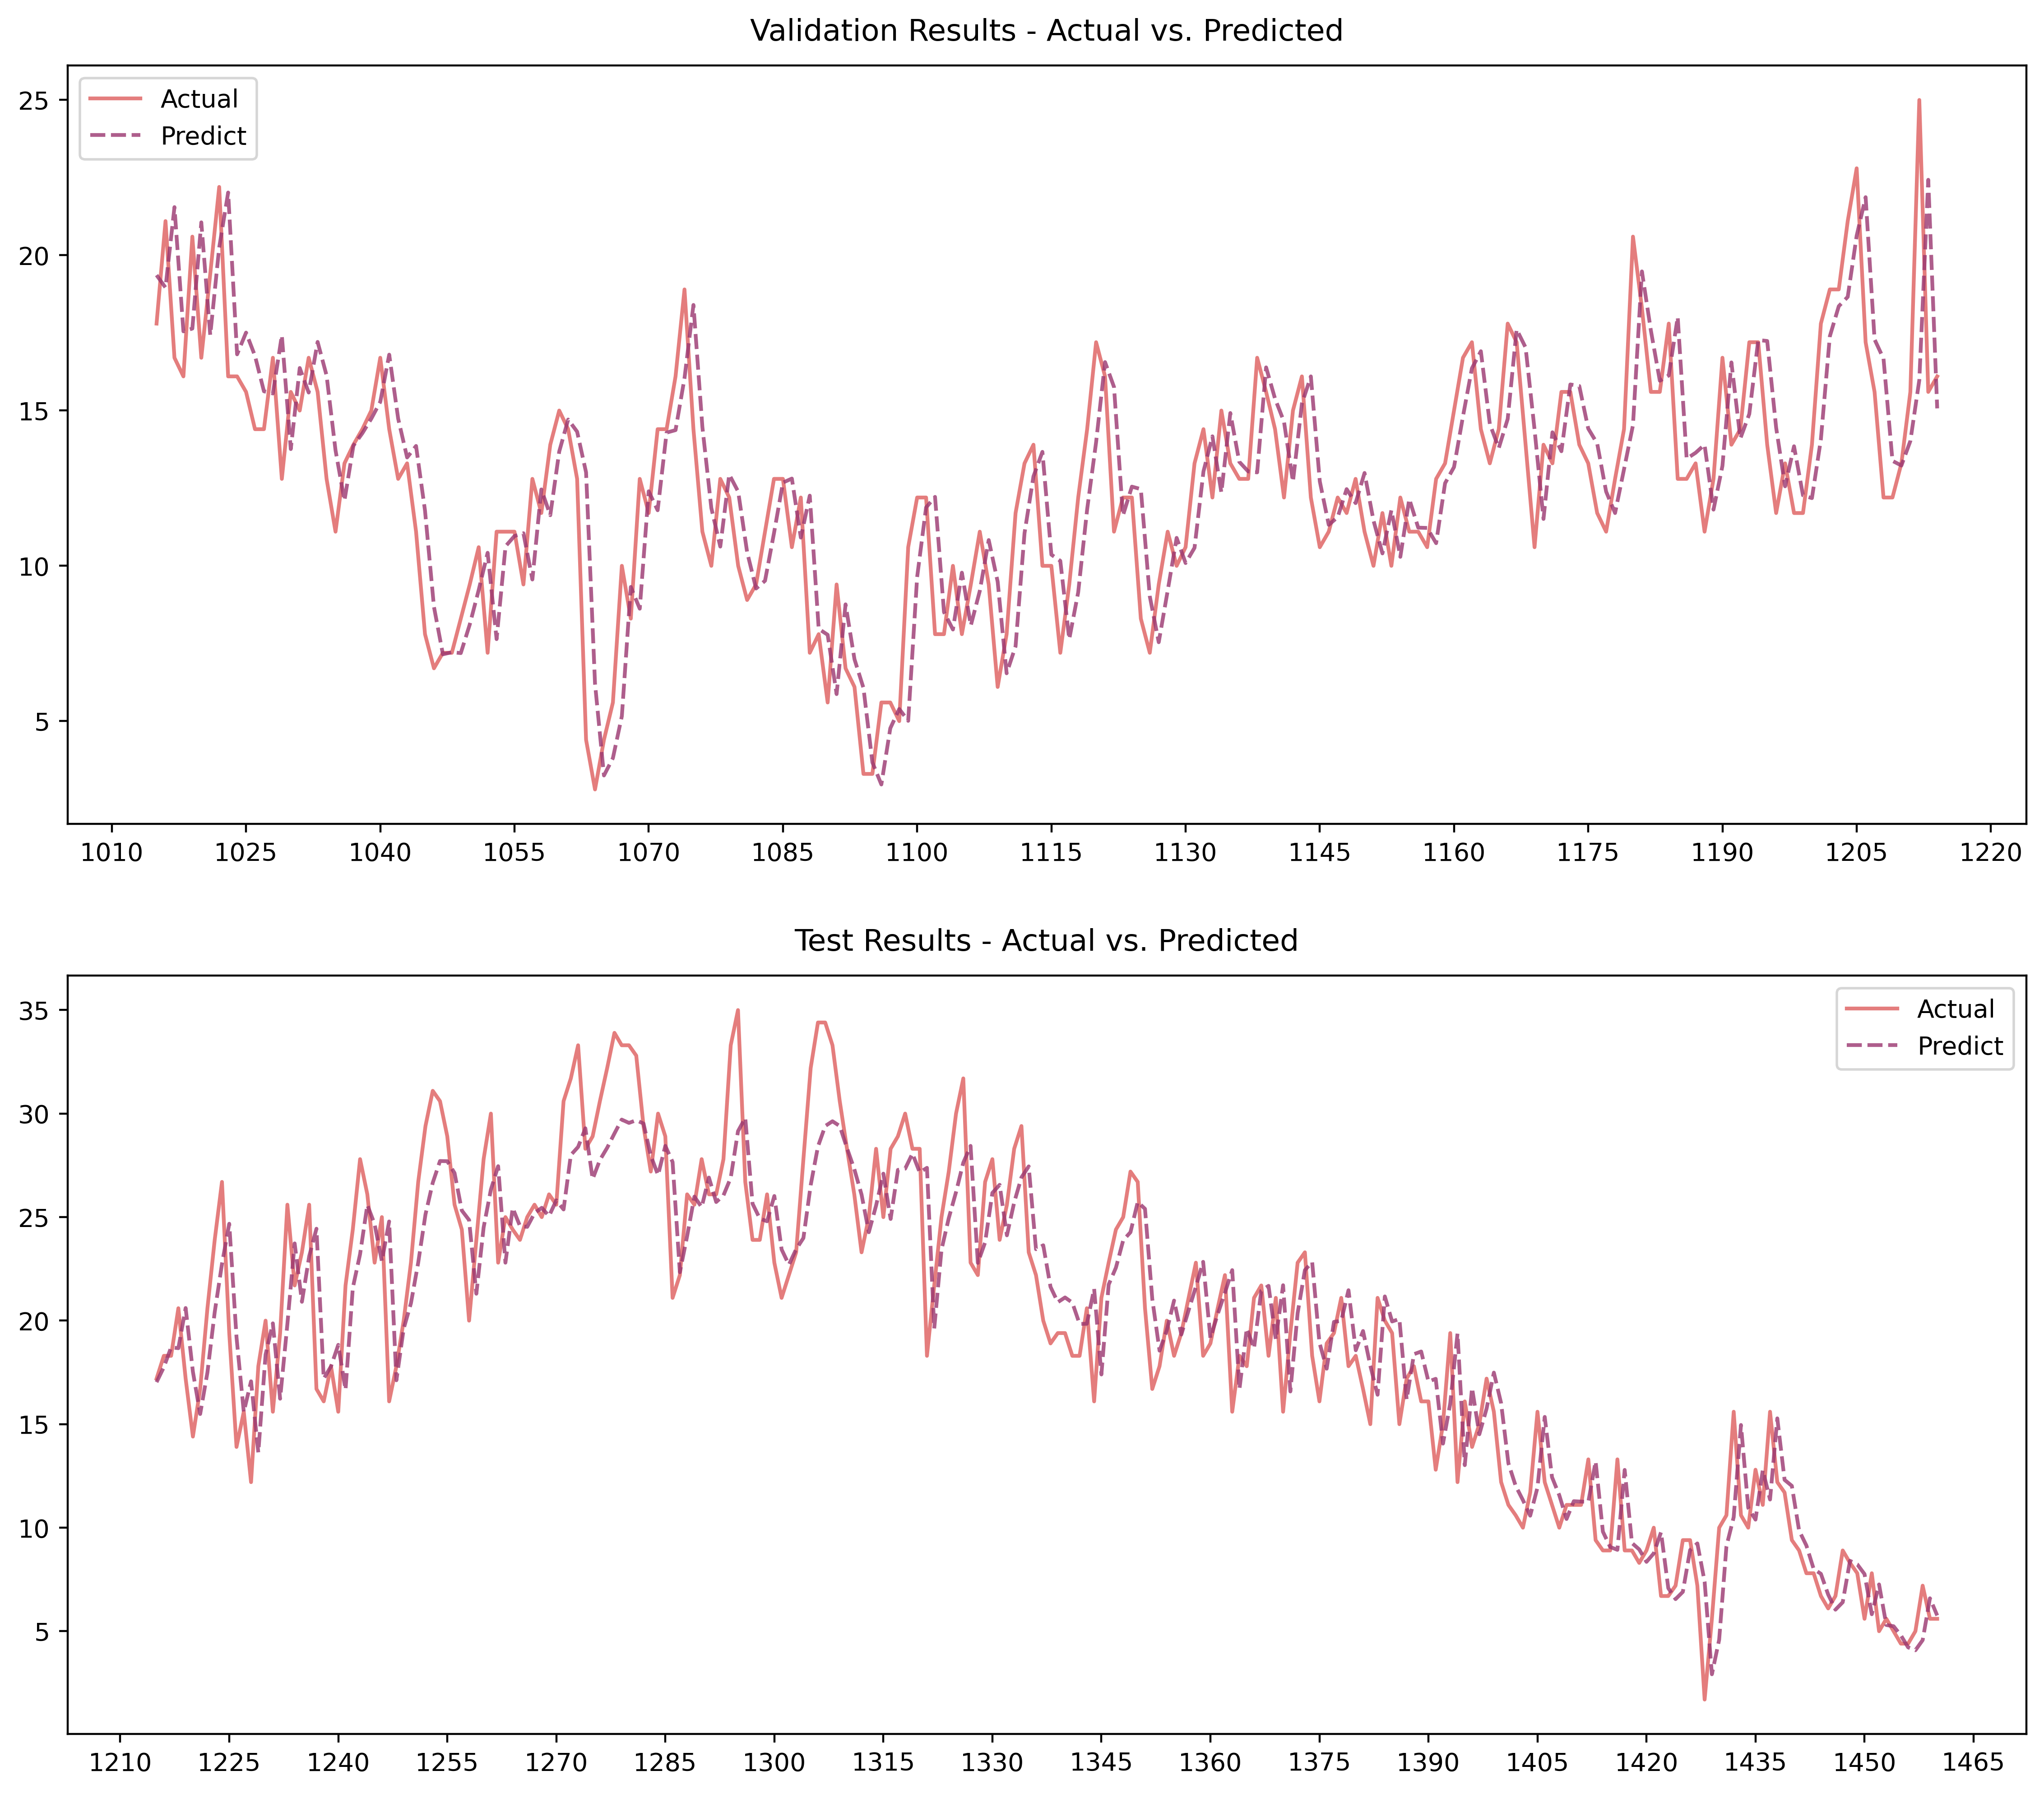

In [180]:
# Plot the Validation and Test Predictions and Actuals for Comparison

fig,axes = plt.subplots(2,1,figsize=(14,12),dpi=400)

plt.subplot(2,1,1)
plt.title("Validation Results - Actual vs. Predicted", pad=10)
sns.lineplot(df_val,alpha=0.8,palette="flare",linestyle=None);
plt.xticks(np.arange(1010, 1226, 15))

plt.subplot(2,1,2)
plt.title("Test Results - Actual vs. Predicted",pad=10)
sns.lineplot(df_test,alpha=0.8,palette="flare",linestyle=None);
plt.xticks(np.arange(1210, 1466, 15))
plt.show()

### Conclusion:

We evaluated 3 types of RNN - Recurrent Neural Network models: **SimpleRNN, LSTM - Long Short Term Memory, and GRU - Gated Recurrent Unit**

For each of these models, we used 2 types of Optimizers : **Adam** and **Stochastic Gradient Descent (SGD)** Optimizer

For each of these models, we also applied 3 types of Activation Functions: **Sigmoid, ReLU, and TanH**

For LSTM, we applied one set with **Recurrent Dropout** and another without the Recurrent Dropout

For all the models, we used a **Dropout** value of **0.2 (20%)**. In other words, during training, 20% of the neurons in a layer will be randomly "dropped out" (excluded from the calculation).

In total, we ran 24 RNN models and found that **GRU, with SDG Optimizer, and ReLU Activation function, and no Recurrent Dropout** has the best result with a **Root Mean Squared Error (RMSE)** of **2.9722**.

Looking at the results, we can also find that activation functions **Sigmoid, and TanH did not provide good results** for any of the RNN models. The training loss, validation loss, and root mean squared error (RMSE) were too high to consider these models.

Using the **GRU-SDG-ReLU** model, we are able to see a very good prediction of the **Max Temperature**.

As a future recommendation, we can look at building the model for the other 3 input sources - precipitation, temp_min, and wind. We can combine all 4 values to then predict the actual weather. The result would be one of these : **`drizzle`, `rain`, `sun`, `snow` or `fog`**

In [181]:
df.weather.unique()

array(['drizzle', 'rain', 'sun', 'snow', 'fog'], dtype=object)